# 5rd K10L195

# 101 Course of transfer learning and Fine tune 2021-01-01

## [How-to] 1. k-fold for cross validation

#### Create a simple k-fold for train classification model.

* In this short course you learned:

* data pipline

* transfer learning

* fine tune

* callbacks


todo: move to note.py


In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use("bmh")

import cv2
import tensorflow as tf

from datetime import datetime
import seaborn as sns

import errno

# albumentations
from functools import partial
# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
#     Rotate
# )
import albumentations as A

# from adabelief_tf import AdaBeliefOptimizer

In [2]:
print(tf.__version__)
print(cv2.__version__)

2.3.1
4.3.0


In [3]:
from pytictoc import TicToc

t_timer = TicToc() #create instance of class

t_timer.tic() #Start timer

### 2. Parameters

#### Image size, Batch size, toe/heel-offset.

In [4]:
BATCH_SIZE = 64 # 16 #32 #64 #128 #32 #64 #todo: reduce the BS maybe help to reduce the loss
img_height = 120 #512 #224 #100
img_width = 120 #512 #224 #100

y_offset_toe = 80
y_offset_heel = 280 #400-120=280

#### tf MirroredStrategy seting

In [5]:

# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of REPLICAS: 1

BATCH_SIZE: 64, MULTI_BATCH_SIZE: 64


In [6]:
# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

### 3. Create the training dataset W/ croped


#### Load samples as data-farame

In [7]:

# # data-org #
# ann = 'annotation_1424_merge.csv'
# im_p = 'train/images/'
# CSVNAME = ""


# # data-org-augm#
# ann = 'annotation_2848_augm.csv'
# im_p = 'train_augm/images/'
# CSVNAME = ""


# data-train # # current best dataset.1424-79.
ann = 'annotation_1345_good.csv'
im_p = 'train/images/'
CSVNAME = "K1345K10L195"

# data-augm #
# ann = 'annotation_2690_augm.csv'
# im_p = 'train_augm/images/'
# CSVNAME = ""


# # data-train-HPL-1123
# ann = 'annotation_1123_HPL_Good.csv'
# im_p = 'train/images/'
# CSVNAME = ""


df = pd.read_csv(ann)
df[1120:]

images  x1   y1  x2   y2
1120  image_6195.jpg  52  127  75  370
1121  image_6196.jpg  62  138  29  383
1122  image_6197.jpg  54  135  78  380
1123  image_6198.jpg  60  125  29  384
1124  image_6199.jpg  51  147  70  353
...              ...  ..  ...  ..  ...
1340  image_6419.jpg  60  135  70  381
1341  image_6421.jpg  53  157  76  376
1342  image_6422.jpg  49  154  33  375
1343  image_6423.jpg  64  149  76  381
1344  image_6424.jpg  55  147  36  385

[225 rows x 5 columns]

In [8]:
len(df)

1345

#### Shuffle and reset index

In [9]:
# reset index
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
df.head(10)

images  x1   y1  x2   y2
0  image_6332.jpg  60  138  27  382
1  image_0412.png  75  136  81  380
2  image_6300.jpg  55  147  26  383
3  image_0502.png  68  110  34  364
4  image_0307.png  55  131  86  383
5  image_0402.JPG  37  138  60  380
6  image_0508.png  62  139  38  380
7  image_0941.png  59  143  29  385
8  image_0837.png  63  132  30  376
9  image_0652.jpg  24  125  90  384

See, the image_####.jpg now are random.

#### Create tf.dataset (DS)

In [11]:
# from dataframe
list_ds = tf.data.Dataset.from_tensor_slices((df['images'], df['x1'], df['y1'], df['x2'], df['y2']))
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

In [12]:
len(list_ds)#.shape() #take(1)

1345

In [13]:
# check The type specification of an element of this dataset.
list_ds.element_spec


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [14]:
for f,x1,y1,x2,y2 in list_ds.take(5):
    print(f'take sample: {f} {x1} {y1} {x2} {y2}')

take sample: b'image_6332.jpg' 60 138 27 382
take sample: b'image_0412.png' 75 136 81 380
take sample: b'image_6300.jpg' 55 147 26 383
take sample: b'image_0502.png' 68 110 34 364
take sample: b'image_0307.png' 55 131 86 383


In [15]:
# use np decode to UTF-8
print(f.numpy().decode('UTF-8'))

image_0307.png


In [16]:
len(list_ds)

1345

#### Check ds iterator for consuming

In [17]:
# create a Python iterator

it_list_ds = iter(list_ds) # Make sure iter ds only once.

In [18]:
# using iter and consuming its elements using next: every print different image name.

for i in range(4):
    image, x1, y1, x2, y2 = next(it_list_ds)
    print(image.numpy(), x1.numpy(), y1.numpy())

b'image_6332.jpg' 60 138
b'image_0412.png' 75 136
b'image_6300.jpg' 55 147
b'image_0502.png' 68 110


In [19]:
# image_batch, label_batch = valid_ds_pre_s.as_numpy_iterator().next()
# pred = model.predict_on_batch(image_batch)


for i in range(4):
    image, x1, y1, x2, y2 = list_ds.as_numpy_iterator().next()# every time create a new iter, so need put iter out of above cell.
    print(image, x1, y1, x2, y2)
    
iter_test_list = list_ds.as_numpy_iterator()
print("===== Create iterator once and pull out to above cell. =====")
for i in range(4):
    image, x1, y1, x2, y2 = iter_test_list.next()
    print(image, x1, y1, x2, y2)


b'image_6332.jpg' 60 138 27 382
b'image_6332.jpg' 60 138 27 382
b'image_6332.jpg' 60 138 27 382
b'image_6332.jpg' 60 138 27 382
===== Create iterator once and pull out to above cell. =====
b'image_6332.jpg' 60 138 27 382
b'image_0412.png' 75 136 81 380
b'image_6300.jpg' 55 147 26 383
b'image_0502.png' 68 110 34 364


#### Process path to image tensor in DS

In [20]:

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe(img)
    return img, [x1,y1-y_offset_toe]#Original [0,120]
    #return img, x1, y1-y_offset_toe #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x1/120,(y1-y_offset_toe)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] , no help.

#
# map list to ds, Heel part.
#

def decode_crop_png_heel(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel(img)
    return img, [x2,y2-y_offset_heel]#Original [0,120]
    #return img, x2, y2-y_offset_heel #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x2/120,(y2-y_offset_heel)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] , no help.

#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [21]:
# Toe ds
train_ds_map_toe = list_ds.map(process_path_toe, num_parallel_calls=AUTOTUNE)

# Heel ds
train_ds_map_heel = list_ds.map(process_path_heel, num_parallel_calls=AUTOTUNE)

In [22]:
# for img, xy in train_ds_map_toe.take(1):
#     print(f'take sample: {xy}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

# for img, x, y in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# x

for img, [x, y] in train_ds_map_toe.take(1):
    print(f'take sample: {x} {y}')
    
print('f', f.dtype)
print('x', x.dtype)

take sample: 60 58
f <dtype: 'string'>
x <dtype: 'int64'>


In [23]:
x

<tf.Tensor: shape=(), dtype=int64, numpy=60>

In [24]:
# for f,x1,y1,x2,y2 in train_ds_map.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

#### [new] Split train_ds_pre with ratio of validation %

[ToDo 20210201] keep orignal validation in 0.1, but augmenting train_ds in input layer or in the tf.ds.

[2021-02-23] New k-split ds

In [25]:
# # split Toe
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

# train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
# valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

# print(f'whole samples = {len(train_ds_map_toe)}')
# print(f'val_size = {val_size}')

# print('ds_train = ', tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
# print('ds_valid = ', tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())

In [26]:
# # split Heel
# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)


# train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
# valid_ds_map_heel_s = train_ds_map_heel.take(val_size)

# print(len(train_ds_map_heel))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())

In [27]:
# ## testing cell
# kf = []
# for k in range(5):
#     kf.append(train_ds_map_heel.shard(num_shards=5, index=k))
#     print("k =", k,"num=", tf.data.experimental.cardinality(kf[k]).numpy())

In [28]:
# kf

In [29]:

# for img, [x,y] in kf[1].take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# print('y', y.dtype)

In [30]:
# ## testing cell

# range_k_0 = train_ds_map_heel.window(5)

# print(len(range_k_0))
# print(tf.data.experimental.cardinality(range_k_0).numpy())

In [31]:
# ## testing cell

# def get_train_valid_k_split():
#     x = tf.data.Dataset.range(1000)
#     val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
    
#     for k in range(5):
#         train_num = x.take(val_size + k*val_size)
#         valid_num = x.skip(k*val_size)
        
#         print("k=", k)
#         print(tf.data.experimental.cardinality(train_num).numpy())
#         print(tf.data.experimental.cardinality(valid_num).numpy())
    
    
# get_train_valid_k_split()

In [32]:
## testing cell

# 
# tf.slice
# tf.data.experimental.choose_from_datasets


# x = list_ds
# val_size = int(tf.data.experimental.cardinality(list_ds).numpy() * 0.2)
x = tf.data.Dataset.range(10)

def check_KFold_ds(x, K=5):
    
    val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
    print("val_size=", val_size)
    
    for k in range(K):
#         k_train = x.take(val_size + k*val_size)
#         k_valid = x.skip(k*val_size)
#         k_train = tf.slice(x, k*val_size, val_size) #only for pure tensors not 
#         k_valid = x.skip(k*val_size)

        # may skip twicce to performe kflod
        t_take = x.take(k*val_size)
        t_skip = x.skip(k*val_size+val_size)
        k_train = t_take.concatenate(t_skip)
        
        v_skip = x.skip(k*val_size)
        k_valid = v_skip.take(val_size)

        print("k =", k,"k*val_size+val_size", k*val_size+val_size, "k_train num=", tf.data.experimental.cardinality(k_train).numpy())


        # x = tf.data.Dataset.range(10)
#         for n in k_train:
#             print(n.numpy())
#         for n in k_valid:
#             print(n.numpy())
        
        # list_ds
#         for img, x1, y1, x2, y2 in k_train:
#             print(x1, y1)

        # train_ds_map_toe
#         for img, (x, y) in k_train:
#             print(x.numpy(), y.numpy())

    
    
    
check_KFold_ds(x)
# check_KFold_ds(list_ds)    
# check_KFold_ds(train_ds_map_toe)

val_size= 2
k = 0 k*val_size+val_size 2 k_train num= 8
k = 1 k*val_size+val_size 4 k_train num= 8
k = 2 k*val_size+val_size 6 k_train num= 8
k = 3 k*val_size+val_size 8 k_train num= 8
k = 4 k*val_size+val_size 10 k_train num= 8


In [33]:
# x = tf.data.Dataset.range(10)
# val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
# print("val_size=", val_size)

def get_KFold_ds(x, K=0):
        
    k = K
    # may skip twicce to perform kflod
    # train ds
    t_take = x.take(k*val_size)
    t_skip = x.skip(k*val_size+val_size)
    k_train = t_take.concatenate(t_skip)
    # val ds
    v_skip = x.skip(k*val_size)
    k_valid = v_skip.take(val_size)

    return k_train, k_valid

In [34]:
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)
t, v = get_KFold_ds(train_ds_map_toe, 1)

print(tf.data.experimental.cardinality(t).numpy())
print(tf.data.experimental.cardinality(v).numpy())

# for n in v:
#     print(n.numpy())

1211
134


In [35]:
train_ds_map_toe

<ParallelMapDataset shapes: ((120, 120, 3), (2,)), types: (tf.uint8, tf.int64)>

In [36]:
v

<TakeDataset shapes: ((120, 120, 3), (2,)), types: (tf.uint8, tf.int64)>

# Albumentation pipeline

In [37]:

# # for NO keypoint augment
# transforms = A.Compose([
# #             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=65, quality_upper=100, p=0.5),#A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
# #             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=1),#A.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=(1, 8), tile_grid_size=(8, 8), always_apply=False, p=0.5), #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
# #             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
# #             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
# #             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
# #             A.HorizontalFlip(),
    
#             # try other augm, seems to strong...
#             A.RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
#             A.Equalize(always_apply=False, p=0.5, mode='cv', by_channels=True),
#             A.MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.8, 1.5), per_channel=False, elementwise=False),
#             A.RandomFog(always_apply=False, p=0.5, fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.25),

# ])


# def aug_fn(image, img_size):
#     data = {"image":image}
#     aug_data = transforms(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label

# def set_shapes(img, label, img_shape=(120,120,3)):
#     img.set_shape(img_shape)
# #     label.set_shape([]) # commited for go around error
#     return img, label





# # for NO keypoint augment AND for OneOf[] for better heel loss.
# transforms_oneof = A.Compose(A.OneOf([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
#             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
#             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=.5)
# #             A.HorizontalFlip(),
#             ]),p=0.5)


# def aug_fn_oneof(image, img_size):
#     data = {"image":image}
#     aug_data = transforms_oneof(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data_oneof(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn_oneof, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label




# # Testing keypoints augment
# transforms = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA (alpha=0.1, always_apply=False, p=1),
#             A.Downscale (scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.HorizontalFlip(p=0.5),
#             ]
#             , 
#             keypoint_params=A.KeypointParams(format='xy'),  #currently not works for tf.ds yet.
#             )





# Testing keypoints augment
transforms = A.Compose([
            A.RandomBrightness(limit=0.1, p=0.2),
            A.JpegCompression(quality_lower=85, quality_upper=100, p=0.2),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.2),
            A.RandomContrast(limit=0.2, p=0.2),
            A.FancyPCA(alpha=0.1, always_apply=False, p=1.0),
            A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.2),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.2),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.2),
    
#             A.HorizontalFlip(p=0.5),
            A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.9, 0.99), ratio=(1.0, 1.0), interpolation=0, p=0.8),#xy become double need change dtype of label. # pp will outside the image.
            A.IAAAffine(scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.8),
#             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
    #2021-02-26
#             A.IAAPerspective(scale=(0.05, 0.1), keep_size=True, always_apply=False, p=0.5),#fallout image make train stop. NOT support keypoints!!!!!
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )

# Testing keypoints augment
# @tf.function
def aug_fn(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 








###  for AToe ###
# some pp will outside of image bcs p2 is close to 400.



# Testing keypoints augment
transforms_AToe = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    
#             A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=65, quality_upper=100, p=0.2),#A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.2),
#             A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA(alpha=0.1, always_apply=False, p=1),#A.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
            A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.2), #0.8~0.99 may better
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.2),
            A.CLAHE(clip_limit=(1, 8), tile_grid_size=(8, 8), always_apply=False, p=0.2), #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
    
#             A.HorizontalFlip(p=0.5),
#             A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.75, 0.9), ratio=(1.0, 1.0), interpolation=0, p=0.5),#xy become double need change dtype of label. # pp will outside the image.
            A.IAAAffine (scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.8),
#             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )


# Testing keypoints augment
# @tf.function
def aug_fn_AToe(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms_AToe(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data_AToe(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn_AToe, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 




def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
#     label.set_shape([]) # commited for go around error
    return img, label

#### prepare train_ds_prefetch

In [38]:
def configure_for_performance_cache_train(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


def configure_for_performance_cache_train_AToe(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data_AToe, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds





# def configure_for_performance_cache_train_oneof(ds, cache=True, augment=False):

    
#     """#TODO: need to check the parse logic of ds.cache.
#     if cache:
#         print("Check cache-f1 to file:", cache)
#         if isinstance(cache, str):
#             ds = ds.cache(cache)
#             print("Check cache-f2 to file:", cache)
#     else:
#         ds = ds.cache()
#         print("Check cache in memory:", cache)
#     """    
#     if cache:
#         ds = ds.cache()
#         print("Check cache in memory:Y", cache)
#     else:
#         print("Check cache in memory:N", cache)
        
#     if augment:
#         ds = ds.map(partial(process_data_oneof, img_size=120),num_parallel_calls=AUTOTUNE)
#         ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
#     ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
#     ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
#     print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
#     return ds




def configure_for_performance_cache_val(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache
    TODO:test remove ds.shuffle from val_ds.
    .
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


In [39]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe = configure_for_performance_cache_train(train_ds_map_toe)

# # Heel ds_pre
# train_ds_pre_heel = configure_for_performance_cache_val(train_ds_map_heel)

#### All split ds_prefetch
* train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
* valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

* train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
* valid_ds_map_heel_s = train_ds_map_heel.take(val_size)


In [40]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
# valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)

# # Heel ds_pre
# train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
# valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)

#### Check ds_prefetch samples

In [41]:
# # create it_ds once
# it_train_ds_pre_toe_s = iter(train_ds_pre_toe_s)

In [42]:
# %%time

# # for albu keypoint

# # for original return aug_img, , aug_xy 


# image_batch, label_batch = next(it_train_ds_pre_toe_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')


In [43]:
# # create it_ds once
# it_train_ds_pre_heel_s = iter(train_ds_pre_heel_s)

In [44]:
# %%time

# # for albu keypoint

# # for original return aug_img, , aug_xy 


# image_batch, label_batch = next(it_train_ds_pre_heel_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')

In [45]:
# # create it_ds once
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)

In [46]:
# %%time

# # for albu keypoint

# # for return aug_img, aug_xy 


# image_batch, label_batch = next(it_valid_ds_pre_toe_s)

# plt.figure(figsize=(8, 8))
# # for images, labels in valid_ds_pre_toe_s.take(1):
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')
        

### 3.Loss function

* mae
* euclidean distance
* others


        # 'x' is [[1, 1, 1]
        #         [1, 1, 1]]
        tf.reduce_sum(x) ==> 6
        tf.reduce_sum(x, 0) ==> [2, 2, 2]
        tf.reduce_sum(x, 1) ==> [3, 3]
        the function is default for 2-D array, therefor, in our 1-D [x1,y1] to [x2,y2] the axis should be '0' or just leave it.
        
        tf.sqrt need 	A tf.Tensor of type bfloat16, half, float32, float64, complex64, complex128
        so, convert it first.

should be -> tf.Tensor([56 39], shape=(2,), dtype=int64)

In [47]:
y_true = [10, 10]
y_pred = [10, 20]

# y_true = [1.00000000000000000000123, 10]
# y_pred = [1.0, 10.000000000000000000000000001]

# y_true = [1.0000123, 10]
# y_pred = [1.0, 10.0000321]


In [48]:
# mae

loss_mae = tf.keras.losses.MAE(
    y_true, y_pred
)

loss_mae

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [49]:
# ed

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.constant(y_true) - tf.constant(y_pred)), 0))

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.Variable(y_true) - tf.Variable(y_pred)), 0))

loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

loss_ed

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [50]:
def ed_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

# fix NaN in euclidean distance
# tf.maximum(d, 1e-9), to keep atlease is 1e-9.
# def ed_loss(y_true, y_pred):
#     return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0), 1e-9))


In [51]:
# check the euclidean distance loss
ed_loss(y_true, y_pred).numpy()

10.0

In [52]:
ed_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

#### mean Euclidean distance 

* here the y_true and y_pred is 2-D array. the axis use 1.


* NOTE: LB評分的mean euclidean distance功能，應該跟model.evaluate()一樣so不需重新寫。evaluate()會自動用loss (model.metrics_names)計算後在自動平均，而模型loss我們是用ed-loss取代。

In [53]:
# y_true = [[60, 76],
#        [58, 49 ],
#        [63, 67 ],
#        [58 , 57]]
# y_pred = [[59.927303, 76.471214],
#        [58.056904, 49.98754 ],
#        [63.067844, 67.03861 ],
#        [58.70202 , 57.372707]]

y_true = [[60, 70],
       [70, 80]]
y_pred = [[61, 71],
       [72, 82]]

# y_true = [(60, 70),
#        (70, 80)]
# y_pred = [(61, 71),
#        (72, 82)]

In [54]:
tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [4., 4.]], dtype=float32)>

In [55]:
tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 8.], dtype=float32)>

In [56]:
def ed_metric_2d(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1))


In [57]:
ed_metric_2d(y_true, y_pred).numpy()

array([1.4142135, 2.828427 ], dtype=float32)

In [58]:
ed_metric_2d(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.4142135, 2.828427 ], dtype=float32)>

In [59]:
# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def ed_metric_2d_mean(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)))

In [60]:
# for re-scale back xy 
# return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# return img, [(x2-60)/60,((y2-y_offset_toe)-60)/60]#normalized [-1,1] 

# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def edRescal(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast((y_true*60)+60, tf.float32) - tf.cast((y_pred*60)+60, tf.float32)), 1)))

In [61]:
ed_metric_2d_mean(y_true, y_pred).numpy()

2.1213202

In [62]:
ed_metric_2d_mean(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=2.1213202>

# EFNE Training

maybe mae better than ed loss?

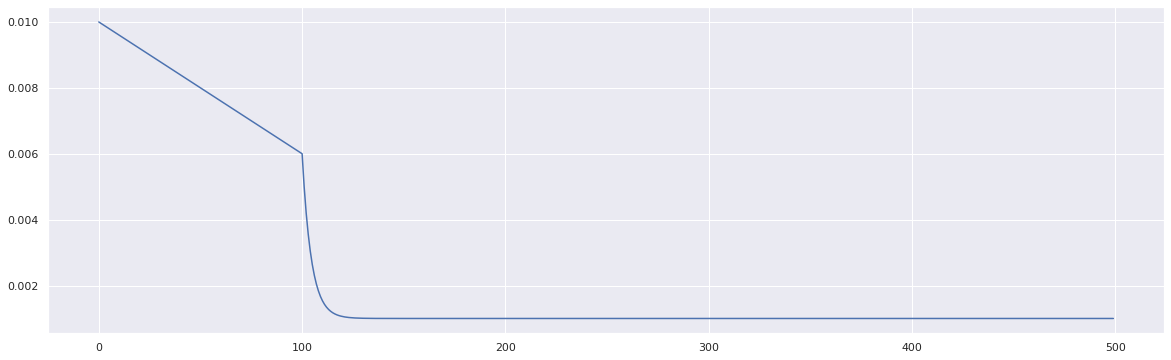

In [63]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.006
    lr_min = 0.001
    lr_start = 0.01

    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.8

    
    # warm up
    if epoch < lr_init_ep:
        lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
    elif lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [64]:
print('{} ~ {}'.format(min(y), max(y)))

0.001 ~ 0.01


In [65]:
for e, lr in zip(rng,y):
    print('{}\t {}\n'.format(e, lr))

0	 0.01

1	 0.00996

2	 0.00992

3	 0.00988

4	 0.00984

5	 0.0098

6	 0.00976

7	 0.00972

8	 0.00968

9	 0.009640000000000001

10	 0.009600000000000001

11	 0.00956

12	 0.00952

13	 0.00948

14	 0.00944

15	 0.0094

16	 0.00936

17	 0.00932

18	 0.00928

19	 0.00924

20	 0.0092

21	 0.00916

22	 0.00912

23	 0.00908

24	 0.00904

25	 0.009000000000000001

26	 0.00896

27	 0.00892

28	 0.00888

29	 0.00884

30	 0.0088

31	 0.00876

32	 0.00872

33	 0.00868

34	 0.00864

35	 0.0086

36	 0.00856

37	 0.00852

38	 0.00848

39	 0.00844

40	 0.0084

41	 0.00836

42	 0.008320000000000001

43	 0.00828

44	 0.00824

45	 0.0082

46	 0.00816

47	 0.00812

48	 0.00808

49	 0.00804

50	 0.008

51	 0.00796

52	 0.00792

53	 0.00788

54	 0.00784

55	 0.0078

56	 0.0077599999999999995

57	 0.007719999999999999

58	 0.00768

59	 0.00764

60	 0.0076

61	 0.00756

62	 0.007520000000000001

63	 0.0074800000000000005

64	 0.00744

65	 0.0074

66	 0.00736

67	 0.00732

68	 0.00728

69	 0.00724

70	 0.007

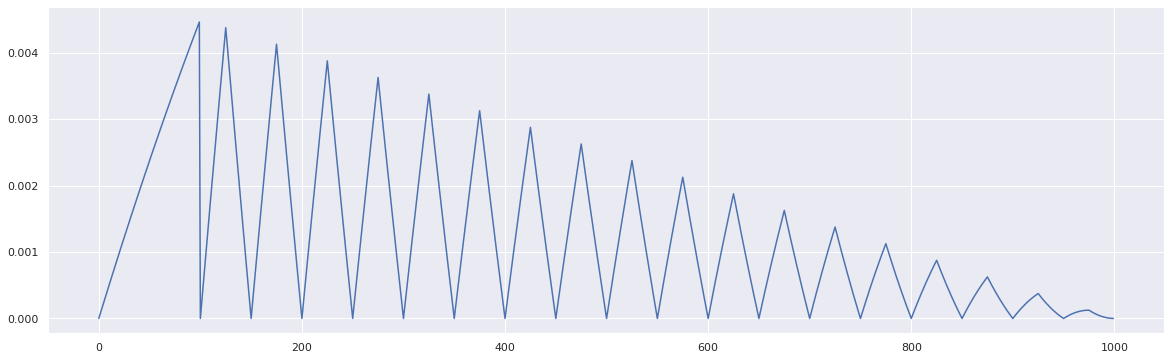

In [66]:
# clr3
# warm up 10% of epoch: it can reduce fall in local min in inital steps.


ep_num = 1000



def clr3(epoch):
    
    
    step_size = 25 # currently best for foot pp
    max_lr = 0.01 # currently best for foot pp
    base_lr = 1e-6 # 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.5

    iterations = epoch
    cycle = np.floor(1+iterations/(2*step_size))
    x = np.abs(iterations/step_size - 2*cycle + 1)
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    
    #todo: boost the lr at initial setps.
#     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
#     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
#     lr = initial_lr(epoch)
    #todo: boost the lr at fist step_size.
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr
    
    decay = ((epoch+1)/ep_num)
    base_part = 1.001 #1.1
#     print(decay)
    return lr * (base_part-decay) * lr_decay # supressed the lr!


rng = [i for i in range(ep_num)]
y = [clr3(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [67]:
print('{} ~ {}'.format(min(y), max(y)))

2.4999999999999966e-08 ~ 0.004459954505


In [68]:
# 2.4999999999999966e-08 ~ 0.004459954505 1e-2~1e-6 

In [69]:
# %%time
# """
# cosine_decay_restarts是cosine_decay的cycle版本。
# first_decay_steps是指第一次完全下降的step數，
# t_mul是指每一次循環的步數都將乘以t_mul倍，
# m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
# alpha
# """

# from matplotlib.ticker import FormatStrFormatter



# ep_num = 1000



# def CosineDecayCLRWarmUp(epoch):
    
#     #step_size = 25 # currently best for foot pp
#     max_lr = 1e-2 # currently best for foot pp
#     base_lr = 1e-8# 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 100
#     lr_sus_ep  = 0
#     lr_decay   = 0.8


#     initial_learning_rate = 1e-2
#     first_decay_steps = 100


#     lr_decayed_fn = (
#       tf.keras.experimental.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps,
#           t_mul=1.0,
#           m_mul=0.8,
#           alpha = 0.000001,
#           name="CCosineDecayRestarts"))
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
#     else:
#         lr = lr_decayed_fn(epoch)
#     return lr



# rng = [i for i in range(ep_num)]
# y = [CosineDecayCLRWarmUp(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# # plt.ylim(.0000000000000001, .01)# for too large loss
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
# plt.plot(rng, y)

In [70]:
# %%time
# """
# cosine_decay_restarts是cosine_decay的cycle版本。
# first_decay_steps是指第一次完全下降的step數，
# t_mul是指每一次循環的步數都將乘以t_mul倍，
# m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
# alpha
# """

# from matplotlib.ticker import FormatStrFormatter



# ep_num = 1000



# def CosineDecayCLRWarmUpLSW(epoch):
    
#     #step_size = 25 # currently best for foot pp
#     max_lr = 1e-3 # currently best for foot pp
#     base_lr = 1e-6# 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 20
#     lr_sus_ep  = 0
#     lr_decay   = 0.8


#     initial_learning_rate = 1e-3
#     first_decay_steps = 50


#     lr_decayed_fn = (
#       tf.keras.experimental.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps,
#           t_mul=1.0,
#           m_mul=0.8,
#           alpha = 0.000001,
#           name="CCosineDecayRestarts"))
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
#     else:
#         lr = lr_decayed_fn(epoch-lr_ramp_ep)
#     return lr



# rng = [i for i in range(ep_num)]
# y = [CosineDecayCLRWarmUpLSW(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# # plt.ylim(.0000000000000001, .01)# for too large loss
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
# plt.plot(rng, y)

CPU times: user 602 ms, sys: 61.3 ms, total: 664 ms
Wall time: 566 ms


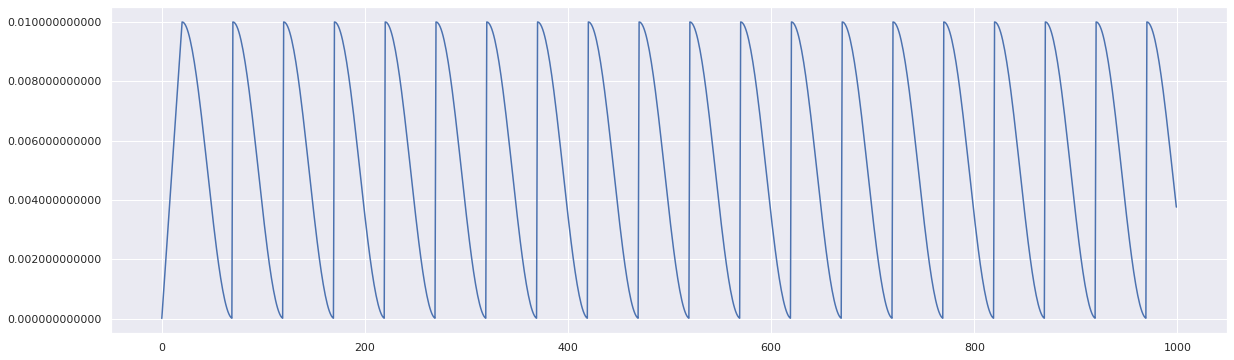

In [71]:
%%time
"""
cosine_decay_restarts是cosine_decay的cycle版本。
first_decay_steps是指第一次完全下降的step數，
t_mul是指每一次循環的步數都將乘以t_mul倍，
m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
alpha
"""

from matplotlib.ticker import FormatStrFormatter



ep_num = 1000



def CosineDecayCLRWarmUpLSW_2(epoch):
    
    #step_size = 25 # currently best for foot pp
    max_lr = 1e-2 # currently best for foot pp
    base_lr = 1e-6# 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 20
    lr_sus_ep  = 0
    #lr_decay   = 0.8


    initial_learning_rate = 1e-2
    first_decay_steps = 50


    lr_decayed_fn = (
      tf.keras.experimental.CosineDecayRestarts(
          initial_learning_rate,
          first_decay_steps,
          t_mul=1,
          m_mul=1,
          alpha = 0.000001,
          name="CCosineDecayRestarts"))
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
    else:
        lr = lr_decayed_fn(epoch-lr_ramp_ep)
    return lr



rng = [i for i in range(ep_num)]
y = [CosineDecayCLRWarmUpLSW_2(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
# plt.ylim(.0000000000000001, .01)# for too large loss
ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
plt.plot(rng, y)

In [72]:
print('{} ~ {}'.format(min(y), max(y)))

1e-06 ~ 0.009999999776482582


In [73]:
# 1.8774175103430935e-08 ~ 0.0010000000474974513 1e-3 1e-6

In [74]:
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-12)

In [75]:
# Callback for printing the LR at the end of each epoch.
class PrintLRtoe(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
#     def on_epoch_end(self, epoch, logs=None):
#         print('\n[{}] Learning rate for epoch {} is {}'.format(
#             datetime.now().strftime("%Y%m%d-%H%M-%S"), 
#             epoch + 1,
#             self.model.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_toe.optimizer._decayed_lr(tf.float32).numpy()))

In [76]:
# Callback for printing the LR at the end of each epoch.
class PrintLRheel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
#                                               model_heel.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_heel.optimizer._decayed_lr(tf.float32).numpy()))

### Output dir and models

In [77]:
def mk_log_dir(log_dir_name):
    try:
        os.makedirs(log_dir_name)
    except OSError as e:
        print("This log dir exist.")
        if e.errno != errno.EEXIST:
            raise ValueError("we got problem.")

In [78]:
monitor = 'val_loss' #'val_loss' 'val_accuracy' if use ed_loss it still the loss here.

log_dir_name = datetime.now().strftime("%Y%m%d-%H%M%S") 

# mk_log_dir(datetime.now().strftime("%Y%m%d-%H%M%S") )  

In [79]:
# use once at the time
mk_log_dir(log_dir_name)

# Toe

In [80]:
model_name = 'EfficientNetB0'

In [81]:
#get_best_model_name

# best_model_name = './' + model_name + '_bs-' + str(BATCH_SIZE) + '_s-' + str(img_height) + '_' + "ep-{epoch:02d}-vloss-{val_loss:.2f}" +'_best-weight.h5'
# best_model_name = '{model_name}-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#best_model_name = './' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + monitor + '_best.h5'
# best_model_name = './Leaf_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

# best_model_name = './cop' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

def get_best_model_name(th, K):
    return './' + log_dir_name + '/' + th + '_K' + K + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

# th = 'toe'
# # th = 'heel'

# # print(get_best_model_name(th,K))

# best_model_name = get_best_model_name(th, K)


# best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
#                              save_best_only = True, 
#                              save_weights_only = False,
#                              monitor = monitor, 
#                              mode = 'auto', verbose = 1)
# print('best_model_name:', best_model_name)

In [82]:
logdir = log_dir_name + "/logs/toe/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [83]:
# callbacks = [
# #     tensorboard_callback,
#     best_model_save,
#     tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=20), #patience=step_size or ep_num
# #     lr_reduceonplateau,
#     tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
#     PrintLRtoe()
# ]

In [84]:
# Transfer learning from pre-trained weights
def build_efn_model(outputnum, top_dropout_rate, drop_connect_rate):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}

    # Freeze the pretrained weights
    base_model.trainable = False
    print("base_model.trainable : ", base_model.trainable)

    # Rebuild top
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
    dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
    outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

    # Compile new model
    model = tf.keras.Model(base_model.input, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)

    
    return model

In [85]:
# """Supervised pre-training 減少每次fold都要重新train的時間
# 只先改toe"""

# # Transfer learning from pre-trained weights
# def load_pretrained_efn_model():
#     pre_model_toe_name = "20210224-200728/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5"
#     model = tf.keras.models.load_model(pre_model_toe_name,compile=False)

#     # Freeze the pretrained weights
#     model.trainable = False
# #     print("base_model.trainable : ", base_model.trainable)

# #     # Rebuild top
# #     gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# #     BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
# #     dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
# #     outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

# #     # Compile new model
# #     model = tf.keras.Model(base_model.input, outputs, name=model_name)


# #     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 4 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             print('layer trainable +1', layer.name)
#             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)

    
#     return model

In [86]:
def unfreeze_model(model):
#
#'block7a_expand_conv'20 'block6c_expand_conv'50 'block6a_expand_conv'79 'block5b_expand_conv'109 'block4a_expand_conv' 166  block3a_expand_conv 195
#
    model.trainable = True
    set_trainable = False
    for layer in model.layers:
        if layer.name == 'block3a_expand_conv': 
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)


In [87]:
# top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
# drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
# outputnum = 2
# with strategy.scope():
#     model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)

In [88]:
# len(model_toe.layers)

In [89]:
# tt = 0
# nt = 0
# for layer in model_toe.layers:
#     if layer.trainable:
#         tt +=1
#         print(f'{layer.name}')
#     else:
#         nt +=1
# print(f'tt: {tt}, nt:{nt}')

In [90]:
def count_model_trainOrNot_layers(model, printlayers=False):
    tt = 0
    nt = 0
    for layer in model.layers:
        if layer.trainable:
            tt +=1
            if printlayers:
                print(f'{layer.name}')
        else:
            nt +=1
    print('\n*********************************** Start fine tune ***********************************')
    print(f'tt: {tt}, nt:{nt}, total layers:{tt+nt}')
    print('*********************************** Start fine tune ***********************************')

In [91]:
# count_model_trainOrNot_layers(model_toe)

In [92]:
# model_toe.summary()

In [93]:
# %%time

# # fit the model on all data
# history_toe = model_toe.fit(train_ds_pre_toe_s, 
#                       verbose=1, 
#                       epochs=ep_num_transf, 
#                       validation_data=valid_ds_pre_toe_s, 
#                       callbacks=callbacks)#, validation_split=0.1)

# K-Fold Training

2021-02-23 v1

### Toe K-model

In [94]:
%%time

# big K = 5 (fold 0 ~ 4) 
KFlodNum = 10



history_toe = []
history_toe_finetune = []

#above until 'train_ds_map_toe now' to 'train_ds_map_toe_s', 'valid_ds_map_toe_s'
for k in range(KFlodNum):
    
    
    # Split data to train/valid with K-Fold #
    print("\n \n K = ", k, "\n")
    # Toe split
    train_ds_map_toe_s, valid_ds_map_toe_s = get_KFold_ds(train_ds_map_toe, K=k)
    
    # Toe ds_pre
    train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
    valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)
    
    
#     # heel split
#     train_ds_map_heel_s, valid_ds_map_heel_s = get_KFold_ds(train_ds_map_heel, K=k)
#     # Heel ds_pre
#     train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
#     valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)
    
    
    # Train K-Model with transfer learnling #
    
    # Toe model, TL
    th = 'toe'
    # th = 'heel'
    best_model_name = get_best_model_name(th, K=str(k))
    best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = monitor, 
                                 mode = 'auto', verbose = 1)
    callbacks_toe_tl = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=30), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
                        PrintLRtoe()
                        ]
    callbacks_toe_fn = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=150), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp, CosineDecayCLRWarmUpLSW
                        PrintLRtoe()
                    ]
    print('best_model_name:', best_model_name)


    top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
    drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
    outputnum = 2
    with strategy.scope():
        model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)
#         model_toe = load_pretrained_efn_model() # from 20210224-200728 ed5.3
#         count_model_trainOrNot_layers(model_toe)
        
    # fit the model on all data
    hist = model_toe.fit(train_ds_pre_toe_s, 
                          verbose=1, 
                          epochs=ep_num_transf, 
                          validation_data=valid_ds_pre_toe_s, 
                          callbacks=callbacks_toe_tl)#, validation_split=0.1)
    history_toe.append(hist)
    
      
    # Train K-Model with fine tune #
    
    # Toe model, FT
    unfreeze_model(model_toe)
    count_model_trainOrNot_layers(model_toe)
    # fit the model on all data
    hist = model_toe.fit(train_ds_pre_toe_s, 
                          verbose=1, 
                          epochs=ep_num, 
                          validation_data=valid_ds_pre_toe_s, 
                          callbacks=callbacks_toe_fn)#, validation_split=0.1)
    history_toe_finetune.append(hist)



 
 K =  0 

Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
best_model_name: ./20210302-234745/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

16/19 [========================>.....] - ETA: 0s - loss: 14.2927
Epoch 00017: val_loss did not improve from 11.65487
19/19 [==============================] - 0s 23ms/step - loss: 14.2201 - val_loss: 11.7328

[20210302-2349-32] Learning rate for epoch 18 is 0.009320000186562538
Epoch 18/500
19/19 [==============================] - ETA: 0s - loss: 14.6309
Epoch 00018: val_loss did not improve from 11.65487
19/19 [==============================] - 0s 23ms/step - loss: 14.6309 - val_loss: 11.8890

[20210302-2349-36] Learning rate for epoch 19 is 0.009279999881982803
Epoch 19/500
16/19 [========================>.....] - ETA: 0s - loss: 14.2972
Epoch 00019: val_loss improved from 11.65487 to 11.62066, saving model to ./20210302-234745/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 41ms/step - loss: 14.4180 - val_loss: 11.6207

[20210302-2349-41] Learning rate for epoch 20 is 0.009239999577403069
Epoch 20/500
19/19 [==============================]


[20210302-2351-16] Learning rate for epoch 44 is 0.00827999971807003
Epoch 44/500
19/19 [==============================] - ETA: 0s - loss: 13.3475
Epoch 00044: val_loss did not improve from 11.25142
19/19 [==============================] - 0s 22ms/step - loss: 13.3475 - val_loss: 11.4251

[20210302-2351-19] Learning rate for epoch 45 is 0.00824000034481287
Epoch 45/500
16/19 [========================>.....] - ETA: 0s - loss: 13.2882
Epoch 00045: val_loss did not improve from 11.25142
19/19 [==============================] - 0s 22ms/step - loss: 13.1446 - val_loss: 11.8265

[20210302-2351-23] Learning rate for epoch 46 is 0.008200000040233135
Epoch 46/500
19/19 [==============================] - ETA: 0s - loss: 13.1517
Epoch 00046: val_loss did not improve from 11.25142
19/19 [==============================] - 0s 22ms/step - loss: 13.1517 - val_loss: 11.2737

[20210302-2351-27] Learning rate for epoch 47 is 0.0081599997356534
Epoch 47/500
19/19 [==============================] - ETA: 0

16/19 [========================>.....] - ETA: 0s - loss: 13.2689
Epoch 00070: val_loss did not improve from 10.85886
19/19 [==============================] - 0s 22ms/step - loss: 13.4797 - val_loss: 10.9943

[20210302-2353-03] Learning rate for epoch 71 is 0.007199999876320362
Epoch 71/500
16/19 [========================>.....] - ETA: 0s - loss: 13.1719
Epoch 00071: val_loss did not improve from 10.85886
19/19 [==============================] - 0s 23ms/step - loss: 13.1382 - val_loss: 11.2539

[20210302-2353-07] Learning rate for epoch 72 is 0.007160000037401915
Epoch 72/500
16/19 [========================>.....] - ETA: 0s - loss: 13.1312
Epoch 00072: val_loss did not improve from 10.85886
19/19 [==============================] - 0s 22ms/step - loss: 13.1366 - val_loss: 10.9729

[20210302-2353-11] Learning rate for epoch 73 is 0.007120000198483467
Epoch 73/500
19/19 [==============================] - ETA: 0s - loss: 13.1893
Epoch 00073: val_loss did not improve from 10.85886
19/19 [===


[20210302-2356-17] Learning rate for epoch 6 is 0.000249222619459033
Epoch 6/1000
19/19 [==============================] - ETA: 0s - loss: 11.9629
Epoch 00006: val_loss improved from 10.85886 to 10.69522, saving model to ./20210302-234745/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 96ms/step - loss: 11.9629 - val_loss: 10.6952

[20210302-2356-22] Learning rate for epoch 7 is 0.0002986671752296388
Epoch 7/1000
19/19 [==============================] - ETA: 0s - loss: 11.9075
Epoch 00007: val_loss improved from 10.69522 to 9.60553, saving model to ./20210302-234745/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 93ms/step - loss: 11.9075 - val_loss: 9.6055

[20210302-2356-28] Learning rate for epoch 8 is 0.00034801175934262574
Epoch 8/1000
19/19 [==============================] - ETA: 0s - loss: 11.0766
Epoch 00008: val_loss improved from 9.60553 to 9.46230, saving model to ./20210302-234745/toe


[20210302-2358-28] Learning rate for epoch 33 is 0.0015491291414946318
Epoch 33/1000
19/19 [==============================] - ETA: 0s - loss: 8.3055
Epoch 00033: val_loss did not improve from 8.31957
19/19 [==============================] - 1s 63ms/step - loss: 8.3055 - val_loss: 9.6298

[20210302-2358-33] Learning rate for epoch 34 is 0.00159587396774441
Epoch 34/1000
19/19 [==============================] - ETA: 0s - loss: 8.1374
Epoch 00034: val_loss did not improve from 8.31957
19/19 [==============================] - 1s 64ms/step - loss: 8.1374 - val_loss: 9.9733

[20210302-2358-38] Learning rate for epoch 35 is 0.001642518793232739
Epoch 35/1000
19/19 [==============================] - ETA: 0s - loss: 7.9946
Epoch 00035: val_loss did not improve from 8.31957
19/19 [==============================] - 1s 63ms/step - loss: 7.9946 - val_loss: 9.2937

[20210302-2358-42] Learning rate for epoch 36 is 0.0016890636179596186
Epoch 36/1000
19/19 [==============================] - ETA: 0s -

19/19 [==============================] - ETA: 0s - loss: 6.9721
Epoch 00060: val_loss did not improve from 7.35246
19/19 [==============================] - 1s 65ms/step - loss: 6.9721 - val_loss: 8.0909

[20210303-0000-43] Learning rate for epoch 61 is 0.002820187946781516
Epoch 61/1000
19/19 [==============================] - ETA: 0s - loss: 7.1360
Epoch 00061: val_loss did not improve from 7.35246
19/19 [==============================] - 1s 64ms/step - loss: 7.1360 - val_loss: 8.1136

[20210303-0000-48] Learning rate for epoch 62 is 0.0028641331009566784
Epoch 62/1000
19/19 [==============================] - ETA: 0s - loss: 7.1339
Epoch 00062: val_loss did not improve from 7.35246
19/19 [==============================] - 1s 64ms/step - loss: 7.1339 - val_loss: 8.7272

[20210303-0000-52] Learning rate for epoch 63 is 0.0029079781379550695
Epoch 63/1000
19/19 [==============================] - ETA: 0s - loss: 6.9726
Epoch 00063: val_loss did not improve from 7.35246
19/19 [============

19/19 [==============================] - ETA: 0s - loss: 6.6743
Epoch 00088: val_loss did not improve from 7.16989
19/19 [==============================] - 1s 65ms/step - loss: 6.6743 - val_loss: 8.1879

[20210303-0002-57] Learning rate for epoch 89 is 0.004012854769825935
Epoch 89/1000
19/19 [==============================] - ETA: 0s - loss: 6.8292
Epoch 00089: val_loss did not improve from 7.16989
19/19 [==============================] - 1s 64ms/step - loss: 6.8292 - val_loss: 7.6600

[20210303-0003-01] Learning rate for epoch 90 is 0.00405400013551116
Epoch 90/1000
19/19 [==============================] - ETA: 0s - loss: 6.4627
Epoch 00090: val_loss did not improve from 7.16989
19/19 [==============================] - 1s 70ms/step - loss: 6.4627 - val_loss: 7.4418

[20210303-0003-06] Learning rate for epoch 91 is 0.004095045384019613
Epoch 91/1000
19/19 [==============================] - ETA: 0s - loss: 6.5716
Epoch 00091: val_loss improved from 7.16989 to 7.12093, saving model to .

19/19 [==============================] - ETA: 0s - loss: 6.2192
Epoch 00115: val_loss did not improve from 6.79260
19/19 [==============================] - 1s 63ms/step - loss: 6.2192 - val_loss: 7.2166

[20210303-0005-06] Learning rate for epoch 116 is 0.0026551769115030766
Epoch 116/1000
19/19 [==============================] - ETA: 0s - loss: 5.8446
Epoch 00116: val_loss did not improve from 6.79260
19/19 [==============================] - 1s 65ms/step - loss: 5.8446 - val_loss: 6.9888

[20210303-0005-11] Learning rate for epoch 117 is 0.0028289591427892447
Epoch 117/1000
19/19 [==============================] - ETA: 0s - loss: 6.1595
Epoch 00117: val_loss did not improve from 6.79260
19/19 [==============================] - 1s 64ms/step - loss: 6.1595 - val_loss: 7.6255

[20210303-0005-16] Learning rate for epoch 118 is 0.0030023413710296154
Epoch 118/1000
19/19 [==============================] - ETA: 0s - loss: 6.1671
Epoch 00118: val_loss did not improve from 6.79260
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 5.8141
Epoch 00143: val_loss did not improve from 6.79260
19/19 [==============================] - 1s 64ms/step - loss: 5.8141 - val_loss: 7.3310

[20210303-0007-20] Learning rate for epoch 144 is 0.0012001085560768843
Epoch 144/1000
19/19 [==============================] - ETA: 0s - loss: 5.7383
Epoch 00144: val_loss did not improve from 6.79260
19/19 [==============================] - 1s 65ms/step - loss: 5.7383 - val_loss: 6.9422

[20210303-0007-24] Learning rate for epoch 145 is 0.0010275252861902118
Epoch 145/1000
19/19 [==============================] - ETA: 0s - loss: 5.3558
Epoch 00145: val_loss did not improve from 6.79260
19/19 [==============================] - 1s 64ms/step - loss: 5.3558 - val_loss: 6.9934


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 00013: val_loss improved from 10.45069 to 10.10104, saving model to ./20210302-234745/toe_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 52ms/step - loss: 15.1270 - val_loss: 10.1010

[20210303-0055-45] Learning rate for epoch 14 is 0.009479999542236328
Epoch 14/500
16/19 [========================>.....] - ETA: 0s - loss: 14.9312
Epoch 00014: val_loss did not improve from 10.10104
19/19 [==============================] - 0s 22ms/step - loss: 15.0526 - val_loss: 10.3324

[20210303-0055-49] Learning rate for epoch 15 is 0.009440000168979168
Epoch 15/500
19/19 [==============================] - ETA: 0s - loss: 14.7504
Epoch 00015: val_loss did not improve from 10.10104
19/19 [==============================] - 0s 22ms/step - loss: 14.7504 - val_loss: 10.1477

[20210303-0055-53] Learning rate for epoch 16 is 0.009399999864399433
Epoch 16/500
16/19 [========================>.....] - ETA: 0s - loss: 14.6835
Epoch 00016: val_loss improved from 1


[20210303-0057-28] Learning rate for epoch 40 is 0.008440000005066395
Epoch 40/500
17/19 [=========================>....] - ETA: 0s - loss: 13.5270
Epoch 00040: val_loss did not improve from 9.37234
19/19 [==============================] - 0s 22ms/step - loss: 13.4942 - val_loss: 9.8402

[20210303-0057-33] Learning rate for epoch 41 is 0.00839999970048666
Epoch 41/500
19/19 [==============================] - ETA: 0s - loss: 13.8696
Epoch 00041: val_loss did not improve from 9.37234
19/19 [==============================] - 0s 23ms/step - loss: 13.8696 - val_loss: 9.7046

[20210303-0057-37] Learning rate for epoch 42 is 0.0083600003272295
Epoch 42/500
16/19 [========================>.....] - ETA: 0s - loss: 13.2286
Epoch 00042: val_loss did not improve from 9.37234
19/19 [==============================] - 0s 22ms/step - loss: 13.2504 - val_loss: 9.5498

[20210303-0057-41] Learning rate for epoch 43 is 0.008320000022649765
Epoch 43/500
19/19 [==============================] - ETA: 0s - l

19/19 [==============================] - ETA: 0s - loss: 13.1714
Epoch 00067: val_loss did not improve from 9.28952
19/19 [==============================] - 0s 22ms/step - loss: 13.1714 - val_loss: 9.7683

[20210303-0059-19] Learning rate for epoch 68 is 0.007319999858736992
Epoch 68/500
16/19 [========================>.....] - ETA: 0s - loss: 13.3628
Epoch 00068: val_loss did not improve from 9.28952
19/19 [==============================] - 0s 22ms/step - loss: 13.4656 - val_loss: 9.3074

[20210303-0059-23] Learning rate for epoch 69 is 0.007280000019818544
Epoch 69/500
19/19 [==============================] - ETA: 0s - loss: 13.3814
Epoch 00069: val_loss did not improve from 9.28952
19/19 [==============================] - 0s 23ms/step - loss: 13.3814 - val_loss: 9.3898

[20210303-0059-27] Learning rate for epoch 70 is 0.007240000180900097
Epoch 70/500
19/19 [==============================] - ETA: 0s - loss: 13.1067
Epoch 00070: val_loss did not improve from 9.28952
19/19 [==========


[20210303-0101-06] Learning rate for epoch 95 is 0.006240000016987324
Epoch 95/500
16/19 [========================>.....] - ETA: 0s - loss: 13.1746
Epoch 00095: val_loss did not improve from 9.16010
19/19 [==============================] - 0s 22ms/step - loss: 13.1198 - val_loss: 9.5965

[20210303-0101-09] Learning rate for epoch 96 is 0.006200000178068876
Epoch 96/500
17/19 [=========================>....] - ETA: 0s - loss: 13.0687
Epoch 00096: val_loss did not improve from 9.16010
19/19 [==============================] - 0s 22ms/step - loss: 13.2121 - val_loss: 9.2600

[20210303-0101-13] Learning rate for epoch 97 is 0.0061599998734891415
Epoch 97/500
17/19 [=========================>....] - ETA: 0s - loss: 13.1702
Epoch 00097: val_loss did not improve from 9.16010
19/19 [==============================] - 0s 22ms/step - loss: 13.2072 - val_loss: 9.4530

[20210303-0101-17] Learning rate for epoch 98 is 0.006120000034570694
Epoch 98/500
16/19 [========================>.....] - ETA: 0s

19/19 [==============================] - ETA: 0s - loss: 11.7302
Epoch 00006: val_loss did not improve from 9.16010
19/19 [==============================] - 1s 67ms/step - loss: 11.7302 - val_loss: 9.3595

[20210303-0103-45] Learning rate for epoch 7 is 0.0002986671752296388
Epoch 7/1000
19/19 [==============================] - ETA: 0s - loss: 11.5391
Epoch 00007: val_loss improved from 9.16010 to 8.45834, saving model to ./20210302-234745/toe_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 124ms/step - loss: 11.5391 - val_loss: 8.4583

[20210303-0103-51] Learning rate for epoch 8 is 0.00034801175934262574
Epoch 8/1000
19/19 [==============================] - ETA: 0s - loss: 11.2933
Epoch 00008: val_loss improved from 8.45834 to 7.85771, saving model to ./20210302-234745/toe_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 94ms/step - loss: 11.2933 - val_loss: 7.8577

[20210303-0103-56] Learning rate for e

19/19 [==============================] - ETA: 0s - loss: 8.3655
Epoch 00033: val_loss did not improve from 7.30459
19/19 [==============================] - 1s 64ms/step - loss: 8.3655 - val_loss: 8.7441

[20210303-0105-57] Learning rate for epoch 34 is 0.00159587396774441
Epoch 34/1000
19/19 [==============================] - ETA: 0s - loss: 8.4012
Epoch 00034: val_loss did not improve from 7.30459
19/19 [==============================] - 1s 65ms/step - loss: 8.4012 - val_loss: 9.2529

[20210303-0106-02] Learning rate for epoch 35 is 0.001642518793232739
Epoch 35/1000
19/19 [==============================] - ETA: 0s - loss: 8.0203
Epoch 00035: val_loss did not improve from 7.30459
19/19 [==============================] - 1s 63ms/step - loss: 8.0203 - val_loss: 7.8187

[20210303-0106-06] Learning rate for epoch 36 is 0.0016890636179596186
Epoch 36/1000
19/19 [==============================] - ETA: 0s - loss: 8.1911
Epoch 00036: val_loss did not improve from 7.30459
19/19 [==============


[20210303-0108-03] Learning rate for epoch 60 is 0.0027761429082602262
Epoch 60/1000
19/19 [==============================] - ETA: 0s - loss: 7.0581
Epoch 00060: val_loss did not improve from 5.66509
19/19 [==============================] - 1s 65ms/step - loss: 7.0581 - val_loss: 6.4006

[20210303-0108-08] Learning rate for epoch 61 is 0.002820187946781516
Epoch 61/1000
19/19 [==============================] - ETA: 0s - loss: 7.2739
Epoch 00061: val_loss did not improve from 5.66509
19/19 [==============================] - 1s 68ms/step - loss: 7.2739 - val_loss: 6.2555

[20210303-0108-13] Learning rate for epoch 62 is 0.0028641331009566784
Epoch 62/1000
19/19 [==============================] - ETA: 0s - loss: 7.2067
Epoch 00062: val_loss did not improve from 5.66509
19/19 [==============================] - 1s 66ms/step - loss: 7.2067 - val_loss: 7.4231

[20210303-0108-17] Learning rate for epoch 63 is 0.0029079781379550695
Epoch 63/1000
19/19 [==============================] - ETA: 0s

19/19 [==============================] - ETA: 0s - loss: 6.7394
Epoch 00088: val_loss did not improve from 5.55823
19/19 [==============================] - 1s 65ms/step - loss: 6.7394 - val_loss: 7.0347

[20210303-0110-22] Learning rate for epoch 89 is 0.004012854769825935
Epoch 89/1000
19/19 [==============================] - ETA: 0s - loss: 6.8606
Epoch 00089: val_loss did not improve from 5.55823
19/19 [==============================] - 1s 64ms/step - loss: 6.8606 - val_loss: 6.2922

[20210303-0110-27] Learning rate for epoch 90 is 0.00405400013551116
Epoch 90/1000
19/19 [==============================] - ETA: 0s - loss: 6.5706
Epoch 00090: val_loss did not improve from 5.55823
19/19 [==============================] - 1s 65ms/step - loss: 6.5706 - val_loss: 8.8884

[20210303-0110-32] Learning rate for epoch 91 is 0.004095045384019613
Epoch 91/1000
19/19 [==============================] - ETA: 0s - loss: 6.5418
Epoch 00091: val_loss did not improve from 5.55823
19/19 [===============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 5.9614
Epoch 00174: val_loss did not improve from 5.64224
19/19 [==============================] - 1s 65ms/step - loss: 5.9614 - val_loss: 7.2386

[20210303-0201-31] Learning rate for epoch 175 is 0.003964816685765982
Epoch 175/1000
19/19 [==============================] - ETA: 0s - loss: 5.9715
Epoch 00175: val_loss did not improve from 5.64224
19/19 [==============================] - 1s 63ms/step - loss: 5.9715 - val_loss: 6.8235

[20210303-0201-36] Learning rate for epoch 176 is 0.004124999977648258
Epoch 176/1000
19/19 [==============================] - ETA: 0s - loss: 6.1231
Epoch 00176: val_loss did not improve from 5.64224
19/19 [==============================] - 1s 64ms/step - loss: 6.1231 - val_loss: 7.8655

[20210303-0201-40] Learning rate for epoch 177 is 0.003955216612666845
Epoch 177/1000
19/19 [==============================] - ETA: 0s - loss: 6.1267
Epoch 00177: val_loss did not improve from 5.64224
19/19 [========

19/19 [==============================] - ETA: 0s - loss: 5.2614
Epoch 00202: val_loss did not improve from 5.64224
19/19 [==============================] - 1s 63ms/step - loss: 5.2614 - val_loss: 6.1738

[20210303-0203-43] Learning rate for epoch 203 is 0.00031956707243807614
Epoch 203/1000
19/19 [==============================] - ETA: 0s - loss: 5.0056
Epoch 00203: val_loss did not improve from 5.64224
19/19 [==============================] - 1s 63ms/step - loss: 5.0056 - val_loss: 6.1335

[20210303-0203-48] Learning rate for epoch 204 is 0.00047855067532509565
Epoch 204/1000
19/19 [==============================] - ETA: 0s - loss: 5.3575
Epoch 00204: val_loss did not improve from 5.64224
19/19 [==============================] - 1s 64ms/step - loss: 5.3575 - val_loss: 6.0001

[20210303-0203-52] Learning rate for epoch 205 is 0.0006371343042701483
Epoch 205/1000
19/19 [==============================] - ETA: 0s - loss: 5.3664
Epoch 00205: val_loss did not improve from 5.64224
19/19 [===

19/19 [==============================] - ETA: 0s - loss: 5.8299
Epoch 00230: val_loss did not improve from 5.64224
19/19 [==============================] - 1s 64ms/step - loss: 5.8299 - val_loss: 7.0445

[20210303-0205-55] Learning rate for epoch 231 is 0.00308007700368762
Epoch 231/1000
19/19 [==============================] - ETA: 0s - loss: 5.7109
Epoch 00231: val_loss did not improve from 5.64224
19/19 [==============================] - 1s 63ms/step - loss: 5.7109 - val_loss: 6.7571

[20210303-0206-00] Learning rate for epoch 232 is 0.002922292333096266
Epoch 232/1000
19/19 [==============================] - ETA: 0s - loss: 5.7357
Epoch 00232: val_loss did not improve from 5.64224
19/19 [==============================] - 1s 64ms/step - loss: 5.7357 - val_loss: 6.6277

[20210303-0206-04] Learning rate for epoch 233 is 0.002764907432720065
Epoch 233/1000
19/19 [==============================] - ETA: 0s - loss: 5.5255
Epoch 00233: val_loss did not improve from 5.64224
19/19 [=========

base_model.trainable :  False

[20210303-0208-06] Learning rate for epoch 1 is 0.009999999776482582
Epoch 1/500
18/19 [===========================>..] - ETA: 0s - loss: 74.2898
Epoch 00001: val_loss improved from inf to 57.96706, saving model to ./20210302-234745/toe_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 6s 333ms/step - loss: 73.8237 - val_loss: 57.9671

[20210303-0208-25] Learning rate for epoch 2 is 0.009960000403225422
Epoch 2/500
19/19 [==============================] - ETA: 0s - loss: 34.3785
Epoch 00002: val_loss improved from 57.96706 to 19.80154, saving model to ./20210302-234745/toe_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 3s 168ms/step - loss: 34.3785 - val_loss: 19.8015

[20210303-0208-31] Learning rate for epoch 3 is 0.009920000098645687
Epoch 3/500
19/19 [==============================] - ETA: 0s - loss: 21.3871
Epoch 00003: val_loss improved from 19.80154 to 14.78337, saving model

17/19 [=========================>....] - ETA: 0s - loss: 14.3567
Epoch 00023: val_loss did not improve from 9.54420
19/19 [==============================] - 0s 22ms/step - loss: 14.3898 - val_loss: 9.6333

[20210303-0210-04] Learning rate for epoch 24 is 0.009080000221729279
Epoch 24/500
19/19 [==============================] - ETA: 0s - loss: 14.3644
Epoch 00024: val_loss did not improve from 9.54420
19/19 [==============================] - 0s 23ms/step - loss: 14.3644 - val_loss: 9.8643

[20210303-0210-08] Learning rate for epoch 25 is 0.009039999917149544
Epoch 25/500
16/19 [========================>.....] - ETA: 0s - loss: 14.0701
Epoch 00025: val_loss did not improve from 9.54420
19/19 [==============================] - 0s 22ms/step - loss: 14.1503 - val_loss: 9.6414

[20210303-0210-12] Learning rate for epoch 26 is 0.008999999612569809
Epoch 26/500
19/19 [==============================] - ETA: 0s - loss: 14.3718
Epoch 00026: val_loss improved from 9.54420 to 9.47382, saving model

16/19 [========================>.....] - ETA: 0s - loss: 13.6869
Epoch 00051: val_loss did not improve from 9.47334
19/19 [==============================] - 0s 22ms/step - loss: 13.4704 - val_loss: 9.6945

[20210303-0211-55] Learning rate for epoch 52 is 0.007960000075399876
Epoch 52/500
16/19 [========================>.....] - ETA: 0s - loss: 13.6901
Epoch 00052: val_loss did not improve from 9.47334
19/19 [==============================] - 0s 22ms/step - loss: 13.5891 - val_loss: 9.6128

[20210303-0211-59] Learning rate for epoch 53 is 0.00791999977082014
Epoch 53/500
16/19 [========================>.....] - ETA: 0s - loss: 13.3133
Epoch 00053: val_loss did not improve from 9.47334
19/19 [==============================] - 0s 22ms/step - loss: 13.4204 - val_loss: 9.6650

[20210303-0212-02] Learning rate for epoch 54 is 0.00788000039756298
Epoch 54/500
16/19 [========================>.....] - ETA: 0s - loss: 13.3096
Epoch 00054: val_loss did not improve from 9.47334
19/19 [============


[20210303-0213-38] Learning rate for epoch 78 is 0.006920000072568655
Epoch 78/500
19/19 [==============================] - ETA: 0s - loss: 13.2656
Epoch 00078: val_loss did not improve from 9.26688
19/19 [==============================] - 0s 23ms/step - loss: 13.2656 - val_loss: 9.2872

[20210303-0213-42] Learning rate for epoch 79 is 0.00687999976798892
Epoch 79/500
16/19 [========================>.....] - ETA: 0s - loss: 13.4138
Epoch 00079: val_loss did not improve from 9.26688
19/19 [==============================] - 0s 22ms/step - loss: 13.4102 - val_loss: 9.3019

[20210303-0213-46] Learning rate for epoch 80 is 0.006839999929070473
Epoch 80/500
19/19 [==============================] - ETA: 0s - loss: 13.2894
Epoch 00080: val_loss did not improve from 9.26688
19/19 [==============================] - 0s 24ms/step - loss: 13.2894 - val_loss: 9.3780

[20210303-0213-50] Learning rate for epoch 81 is 0.006800000090152025
Epoch 81/500
16/19 [========================>.....] - ETA: 0s -


[20210303-0216-17] Learning rate for epoch 12 is 0.0005443901172839105
Epoch 12/1000
19/19 [==============================] - ETA: 0s - loss: 10.7528
Epoch 00012: val_loss did not improve from 7.21456
19/19 [==============================] - 1s 65ms/step - loss: 10.7528 - val_loss: 7.8273

[20210303-0216-22] Learning rate for epoch 13 is 0.0005932347266934812
Epoch 13/1000
19/19 [==============================] - ETA: 0s - loss: 10.5500
Epoch 00013: val_loss improved from 7.21456 to 7.21126, saving model to ./20210302-234745/toe_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 91ms/step - loss: 10.5500 - val_loss: 7.2113

[20210303-0216-27] Learning rate for epoch 14 is 0.0006419793353416026
Epoch 14/1000
19/19 [==============================] - ETA: 0s - loss: 10.2837
Epoch 00014: val_loss did not improve from 7.21126
19/19 [==============================] - 1s 64ms/step - loss: 10.2837 - val_loss: 7.2832

[20210303-0216-32] Learning rate for e

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 5.8779
Epoch 00228: val_loss did not improve from 5.16561
19/19 [==============================] - 1s 64ms/step - loss: 5.8779 - val_loss: 5.6735

[20210303-0304-01] Learning rate for epoch 229 is 0.003396846354007721
Epoch 229/1000
19/19 [==============================] - ETA: 0s - loss: 6.0381
Epoch 00229: val_loss did not improve from 5.16561
19/19 [==============================] - 1s 64ms/step - loss: 6.0381 - val_loss: 6.1555

[20210303-0304-06] Learning rate for epoch 230 is 0.003238261677324772
Epoch 230/1000
19/19 [==============================] - ETA: 0s - loss: 6.0387
Epoch 00230: val_loss did not improve from 5.16561
19/19 [==============================] - 1s 65ms/step - loss: 6.0387 - val_loss: 7.0095

[20210303-0304-10] Learning rate for epoch 231 is 0.00308007700368762
Epoch 231/1000
19/19 [==============================] - ETA: 0s - loss: 6.0015
Epoch 00231: val_loss did not improve from 5.16561
19/19 [=========

19/19 [==============================] - ETA: 0s - loss: 5.5535
Epoch 00256: val_loss did not improve from 5.16561
19/19 [==============================] - 1s 65ms/step - loss: 5.5535 - val_loss: 5.2649

[20210303-0306-14] Learning rate for epoch 257 is 0.0008930827025324106
Epoch 257/1000
19/19 [==============================] - ETA: 0s - loss: 5.4220
Epoch 00257: val_loss did not improve from 5.16561
19/19 [==============================] - 1s 64ms/step - loss: 5.4220 - val_loss: 5.3674

[20210303-0306-19] Learning rate for epoch 258 is 0.0010404675267636776
Epoch 258/1000
19/19 [==============================] - ETA: 0s - loss: 5.2336
Epoch 00258: val_loss did not improve from 5.16561
19/19 [==============================] - 1s 67ms/step - loss: 5.2336 - val_loss: 5.3239

[20210303-0306-23] Learning rate for epoch 259 is 0.0011874522315338254
Epoch 259/1000
19/19 [==============================] - ETA: 0s - loss: 5.3467
Epoch 00259: val_loss improved from 5.16561 to 5.16126, saving 

19/19 [==============================] - ETA: 0s - loss: 5.5299
Epoch 00284: val_loss did not improve from 5.16126
19/19 [==============================] - 1s 64ms/step - loss: 5.5299 - val_loss: 5.9121

[20210303-0308-28] Learning rate for epoch 285 is 0.0022913289722055197
Epoch 285/1000
19/19 [==============================] - ETA: 0s - loss: 5.5482
Epoch 00285: val_loss did not improve from 5.16126
19/19 [==============================] - 1s 65ms/step - loss: 5.5482 - val_loss: 6.3065

[20210303-0308-32] Learning rate for epoch 286 is 0.0021451429929584265
Epoch 286/1000
19/19 [==============================] - ETA: 0s - loss: 5.7390
Epoch 00286: val_loss did not improve from 5.16126
19/19 [==============================] - 1s 64ms/step - loss: 5.7390 - val_loss: 5.6859

[20210303-0308-37] Learning rate for epoch 287 is 0.0019993570167571306
Epoch 287/1000
19/19 [==============================] - ETA: 0s - loss: 5.5865
Epoch 00287: val_loss did not improve from 5.16126
19/19 [=====


[20210303-0310-37] Learning rate for epoch 312 is 0.0015159929171204567
Epoch 312/1000
19/19 [==============================] - ETA: 0s - loss: 5.4500
Epoch 00312: val_loss did not improve from 5.07460
19/19 [==============================] - 1s 64ms/step - loss: 5.4500 - val_loss: 5.2823

[20210303-0310-41] Learning rate for epoch 313 is 0.0016513789305463433
Epoch 313/1000
19/19 [==============================] - ETA: 0s - loss: 5.2745
Epoch 00313: val_loss did not improve from 5.07460
19/19 [==============================] - 1s 65ms/step - loss: 5.2745 - val_loss: 5.2798

[20210303-0310-46] Learning rate for epoch 314 is 0.0017863648245111108
Epoch 314/1000
19/19 [==============================] - ETA: 0s - loss: 5.2746
Epoch 00314: val_loss did not improve from 5.07460
19/19 [==============================] - 1s 63ms/step - loss: 5.2746 - val_loss: 5.5663

[20210303-0310-51] Learning rate for epoch 315 is 0.0019209509482607245
Epoch 315/1000
19/19 [==============================] 

19/19 [==============================] - ETA: 0s - loss: 5.3860
Epoch 00340: val_loss did not improve from 5.07460
19/19 [==============================] - 1s 64ms/step - loss: 5.3860 - val_loss: 5.4892

[20210303-0312-54] Learning rate for epoch 341 is 0.0013201979454606771
Epoch 341/1000
19/19 [==============================] - ETA: 0s - loss: 5.2033
Epoch 00341: val_loss did not improve from 5.07460
19/19 [==============================] - 1s 65ms/step - loss: 5.2033 - val_loss: 5.2771

[20210303-0312-59] Learning rate for epoch 342 is 0.0011864108964800835
Epoch 342/1000
19/19 [==============================] - ETA: 0s - loss: 5.3460
Epoch 00342: val_loss did not improve from 5.07460
19/19 [==============================] - 1s 64ms/step - loss: 5.3460 - val_loss: 5.1628

[20210303-0313-03] Learning rate for epoch 343 is 0.0010530237341299653
Epoch 343/1000
19/19 [==============================] - ETA: 0s - loss: 5.4351
Epoch 00343: val_loss did not improve from 5.07460
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 5.6192
Epoch 00368: val_loss did not improve from 5.07460
19/19 [==============================] - 1s 66ms/step - loss: 5.6192 - val_loss: 5.3860

[20210303-0315-06] Learning rate for epoch 369 is 0.0022752885706722736
Epoch 369/1000
19/19 [==============================] - ETA: 0s - loss: 5.2251
Epoch 00369: val_loss did not improve from 5.07460
19/19 [==============================] - 1s 63ms/step - loss: 5.2251 - val_loss: 5.1915

[20210303-0315-11] Learning rate for epoch 370 is 0.0023978757672011852
Epoch 370/1000
19/19 [==============================] - ETA: 0s - loss: 5.7000
Epoch 00370: val_loss did not improve from 5.07460
19/19 [==============================] - 1s 68ms/step - loss: 5.7000 - val_loss: 5.8144

[20210303-0315-16] Learning rate for epoch 371 is 0.0025200629606842995
Epoch 371/1000
 6/19 [========>.....................] - ETA: 0s - loss: 5.0154

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 5.5797
Epoch 00370: val_loss did not improve from 5.99747
19/19 [==============================] - 1s 64ms/step - loss: 5.5797 - val_loss: 7.5356

[20210303-0358-29] Learning rate for epoch 371 is 0.0025200629606842995
Epoch 371/1000
19/19 [==============================] - ETA: 0s - loss: 5.3305
Epoch 00371: val_loss did not improve from 5.99747
19/19 [==============================] - 1s 65ms/step - loss: 5.3305 - val_loss: 7.0793

[20210303-0358-34] Learning rate for epoch 372 is 0.00264185038395226
Epoch 372/1000
19/19 [==============================] - ETA: 0s - loss: 5.6296
Epoch 00372: val_loss did not improve from 5.99747
19/19 [==============================] - 1s 64ms/step - loss: 5.6296 - val_loss: 6.9997

[20210303-0358-39] Learning rate for epoch 373 is 0.0027632375713437796
Epoch 373/1000
19/19 [==============================] - ETA: 0s - loss: 5.4048
Epoch 00373: val_loss did not improve from 5.99747
19/19 [=======

19/19 [==============================] - ETA: 0s - loss: 5.0521
Epoch 00398: val_loss did not improve from 5.99747
19/19 [==============================] - 1s 63ms/step - loss: 5.0521 - val_loss: 6.4912

[20210303-0400-42] Learning rate for epoch 399 is 0.00024107692297548056
Epoch 399/1000
19/19 [==============================] - ETA: 0s - loss: 5.0780
Epoch 00399: val_loss did not improve from 5.99747
19/19 [==============================] - 1s 65ms/step - loss: 5.0780 - val_loss: 6.3008

[20210303-0400-47] Learning rate for epoch 400 is 0.00012048848293488845
Epoch 400/1000
19/19 [==============================] - ETA: 0s - loss: 5.4041
Epoch 00400: val_loss did not improve from 5.99747
19/19 [==============================] - 1s 63ms/step - loss: 5.4041 - val_loss: 6.2828

[20210303-0400-51] Learning rate for epoch 401 is 3.000000106112566e-07
Epoch 401/1000
19/19 [==============================] - ETA: 0s - loss: 4.9059
Epoch 00401: val_loss did not improve from 5.99747
19/19 [===

19/19 [==============================] - ETA: 0s - loss: 5.6471
Epoch 00426: val_loss did not improve from 5.99747
19/19 [==============================] - 1s 65ms/step - loss: 5.6471 - val_loss: 6.6387

[20210303-0402-55] Learning rate for epoch 427 is 0.0027552114333957434
Epoch 427/1000
19/19 [==============================] - ETA: 0s - loss: 5.3375
Epoch 00427: val_loss did not improve from 5.99747
19/19 [==============================] - 1s 64ms/step - loss: 5.3375 - val_loss: 6.6476

[20210303-0403-00] Learning rate for epoch 428 is 0.0026358228642493486
Epoch 428/1000
19/19 [==============================] - ETA: 0s - loss: 5.4387
Epoch 00428: val_loss did not improve from 5.99747
19/19 [==============================] - 1s 63ms/step - loss: 5.4387 - val_loss: 6.7112

[20210303-0403-04] Learning rate for epoch 429 is 0.0025168342981487513
Epoch 429/1000
19/19 [==============================] - ETA: 0s - loss: 5.3041
Epoch 00429: val_loss did not improve from 5.99747
19/19 [=====

 4/19 [=====>........................] - ETA: 0s - loss: 5.0839

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 4.8948
Epoch 00500: val_loss did not improve from 5.99747
19/19 [==============================] - 1s 65ms/step - loss: 4.8948 - val_loss: 6.4019

[20210303-0408-46] Learning rate for epoch 501 is 2.499999993688107e-07
Epoch 501/1000
19/19 [==============================] - ETA: 0s - loss: 5.1504
Epoch 00501: val_loss did not improve from 5.99747
19/19 [==============================] - 1s 64ms/step - loss: 5.1504 - val_loss: 6.3821

[20210303-0408-51] Learning rate for epoch 502 is 0.00010003952047554776
Epoch 502/1000
19/19 [==============================] - ETA: 0s - loss: 5.3589
Epoch 00502: val_loss did not improve from 5.99747
19/19 [==============================] - 1s 65ms/step - loss: 5.3589 - val_loss: 6.3744

 
 K =  7 

Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", 


[20210303-0410-39] Learning rate for epoch 20 is 0.009239999577403069
Epoch 20/500
19/19 [==============================] - ETA: 0s - loss: 14.2433
Epoch 00020: val_loss improved from 10.97657 to 10.92636, saving model to ./20210302-234745/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 52ms/step - loss: 14.2433 - val_loss: 10.9264

[20210303-0410-43] Learning rate for epoch 21 is 0.009200000204145908
Epoch 21/500
16/19 [========================>.....] - ETA: 0s - loss: 14.3691
Epoch 00021: val_loss improved from 10.92636 to 10.91017, saving model to ./20210302-234745/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 41ms/step - loss: 14.3201 - val_loss: 10.9102

[20210303-0410-48] Learning rate for epoch 22 is 0.009159999899566174
Epoch 22/500
19/19 [==============================] - ETA: 0s - loss: 14.3718
Epoch 00022: val_loss did not improve from 10.91017
19/19 [==============================] 


[20210303-0412-26] Learning rate for epoch 47 is 0.0081599997356534
Epoch 47/500
16/19 [========================>.....] - ETA: 0s - loss: 13.1976
Epoch 00047: val_loss did not improve from 10.62824
19/19 [==============================] - 0s 22ms/step - loss: 13.2108 - val_loss: 10.7675

[20210303-0412-30] Learning rate for epoch 48 is 0.00812000036239624
Epoch 48/500
16/19 [========================>.....] - ETA: 0s - loss: 13.3027
Epoch 00048: val_loss did not improve from 10.62824
19/19 [==============================] - 0s 22ms/step - loss: 13.4078 - val_loss: 10.6462

[20210303-0412-33] Learning rate for epoch 49 is 0.008080000057816505
Epoch 49/500
16/19 [========================>.....] - ETA: 0s - loss: 13.4516
Epoch 00049: val_loss improved from 10.62824 to 10.60397, saving model to ./20210302-234745/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 42ms/step - loss: 13.4925 - val_loss: 10.6040

[20210303-0412-38] Learning rate for epo


[20210303-0414-15] Learning rate for epoch 75 is 0.007040000054985285
Epoch 75/500
19/19 [==============================] - ETA: 0s - loss: 13.0354
Epoch 00075: val_loss did not improve from 10.60397
19/19 [==============================] - 0s 23ms/step - loss: 13.0354 - val_loss: 10.7539

[20210303-0414-19] Learning rate for epoch 76 is 0.007000000216066837
Epoch 76/500
17/19 [=========================>....] - ETA: 0s - loss: 13.4076
Epoch 00076: val_loss improved from 10.60397 to 10.49298, saving model to ./20210302-234745/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 46ms/step - loss: 13.3388 - val_loss: 10.4930

[20210303-0414-24] Learning rate for epoch 77 is 0.0069599999114871025
Epoch 77/500
19/19 [==============================] - ETA: 0s - loss: 13.0472
Epoch 00077: val_loss did not improve from 10.49298
19/19 [==============================] - 0s 23ms/step - loss: 13.0472 - val_loss: 10.5539

[20210303-0414-27] Learning rate for

16/19 [========================>.....] - ETA: 0s - loss: 12.7073
Epoch 00102: val_loss did not improve from 10.39002
19/19 [==============================] - 0s 22ms/step - loss: 12.6875 - val_loss: 10.5057

[20210303-0416-05] Learning rate for epoch 103 is 0.00419999985024333
Epoch 103/500
19/19 [==============================] - ETA: 0s - loss: 12.9538
Epoch 00103: val_loss did not improve from 10.39002
19/19 [==============================] - 0s 22ms/step - loss: 12.9538 - val_loss: 10.4124

[20210303-0416-09] Learning rate for epoch 104 is 0.0035600000992417336
Epoch 104/500
17/19 [=========================>....] - ETA: 0s - loss: 12.8700
Epoch 00104: val_loss did not improve from 10.39002
19/19 [==============================] - 0s 26ms/step - loss: 12.8884 - val_loss: 10.4047

[20210303-0416-13] Learning rate for epoch 105 is 0.0030479999259114265
Epoch 105/500
17/19 [=========================>....] - ETA: 0s - loss: 12.7448
Epoch 00105: val_loss improved from 10.39002 to 10.3581


[20210303-0417-49] Learning rate for epoch 129 is 0.0010096713667735457
Epoch 129/500
19/19 [==============================] - ETA: 0s - loss: 12.7268
Epoch 00129: val_loss did not improve from 10.33712
19/19 [==============================] - 0s 22ms/step - loss: 12.7268 - val_loss: 10.4232

[20210303-0417-53] Learning rate for epoch 130 is 0.0010077371262013912
Epoch 130/500
16/19 [========================>.....] - ETA: 0s - loss: 12.8207
Epoch 00130: val_loss did not improve from 10.33712
19/19 [==============================] - 1s 28ms/step - loss: 12.6455 - val_loss: 10.4143

[20210303-0417-57] Learning rate for epoch 131 is 0.0010061897337436676
Epoch 131/500
19/19 [==============================] - ETA: 0s - loss: 12.8824
Epoch 00131: val_loss did not improve from 10.33712
19/19 [==============================] - 0s 23ms/step - loss: 12.8824 - val_loss: 10.4495

[20210303-0418-00] Learning rate for epoch 132 is 0.00100495177321136
Epoch 132/500
16/19 [========================>.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 5.4408
Epoch 00189: val_loss did not improve from 5.65465
19/19 [==============================] - 1s 65ms/step - loss: 5.4408 - val_loss: 5.7932

[20210303-0502-17] Learning rate for epoch 190 is 0.0017844270914793015
Epoch 190/1000
19/19 [==============================] - ETA: 0s - loss: 5.6020
Epoch 00190: val_loss did not improve from 5.65465
19/19 [==============================] - 1s 64ms/step - loss: 5.6020 - val_loss: 5.8426

[20210303-0502-22] Learning rate for epoch 191 is 0.0016202429542317986
Epoch 191/1000
19/19 [==============================] - ETA: 0s - loss: 5.6265
Epoch 00191: val_loss did not improve from 5.65465
19/19 [==============================] - 1s 64ms/step - loss: 5.6265 - val_loss: 5.7586

[20210303-0502-27] Learning rate for epoch 192 is 0.001456458936445415
Epoch 192/1000
19/19 [==============================] - ETA: 0s - loss: 5.4329
Epoch 00192: val_loss did not improve from 5.65465
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.5359
Epoch 00217: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 65ms/step - loss: 5.5359 - val_loss: 6.5879

[20210303-0504-30] Learning rate for epoch 218 is 0.0026623252779245377
Epoch 218/1000
19/19 [==============================] - ETA: 0s - loss: 5.7383
Epoch 00218: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 64ms/step - loss: 5.7383 - val_loss: 6.3636

[20210303-0504-35] Learning rate for epoch 219 is 0.0028153094463050365
Epoch 219/1000
19/19 [==============================] - ETA: 0s - loss: 5.5586
Epoch 00219: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 65ms/step - loss: 5.5586 - val_loss: 5.7946

[20210303-0504-40] Learning rate for epoch 220 is 0.002967893611639738
Epoch 220/1000
19/19 [==============================] - ETA: 0s - loss: 5.6964
Epoch 00220: val_loss did not improve from 5.58261
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.3563
Epoch 00245: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 65ms/step - loss: 5.3563 - val_loss: 5.8567

[20210303-0506-44] Learning rate for epoch 246 is 0.0007553020259365439
Epoch 246/1000
19/19 [==============================] - ETA: 0s - loss: 5.5747
Epoch 00246: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 64ms/step - loss: 5.5747 - val_loss: 5.9342

[20210303-0506-49] Learning rate for epoch 247 is 0.0006035167025402188
Epoch 247/1000
19/19 [==============================] - ETA: 0s - loss: 5.4847
Epoch 00247: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 65ms/step - loss: 5.4847 - val_loss: 5.9141

[20210303-0506-54] Learning rate for epoch 248 is 0.00045213132398203015
Epoch 248/1000
19/19 [==============================] - ETA: 0s - loss: 5.3458
Epoch 00248: val_loss did not improve from 5.58261
19/19 [====

19/19 [==============================] - ETA: 0s - loss: 5.6653
Epoch 00273: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 63ms/step - loss: 5.6653 - val_loss: 6.4570

[20210303-0508-57] Learning rate for epoch 274 is 0.0033442291896790266
Epoch 274/1000
19/19 [==============================] - ETA: 0s - loss: 5.7876
Epoch 00274: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 66ms/step - loss: 5.7876 - val_loss: 6.1837

[20210303-0509-02] Learning rate for epoch 275 is 0.003484814427793026
Epoch 275/1000
19/19 [==============================] - ETA: 0s - loss: 5.6819
Epoch 00275: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 63ms/step - loss: 5.6819 - val_loss: 6.4656

[20210303-0509-07] Learning rate for epoch 276 is 0.0036249998956918716
Epoch 276/1000
19/19 [==============================] - ETA: 0s - loss: 5.6203
Epoch 00276: val_loss did not improve from 5.58261
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.1630
Epoch 00301: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 66ms/step - loss: 5.1630 - val_loss: 5.7884

[20210303-0511-10] Learning rate for epoch 302 is 0.00014013552572578192
Epoch 302/1000
19/19 [==============================] - ETA: 0s - loss: 5.2043
Epoch 00302: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 65ms/step - loss: 5.2043 - val_loss: 5.8317

[20210303-0511-15] Learning rate for epoch 303 is 0.00027952107484452426
Epoch 303/1000
19/19 [==============================] - ETA: 0s - loss: 5.2382
Epoch 00303: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 63ms/step - loss: 5.2382 - val_loss: 5.8573

[20210303-0511-20] Learning rate for epoch 304 is 0.0004185066791251302
Epoch 304/1000
19/19 [==============================] - ETA: 0s - loss: 5.2895
Epoch 00304: val_loss did not improve from 5.58261
19/19 [===

19/19 [==============================] - ETA: 0s - loss: 5.7517
Epoch 00329: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 65ms/step - loss: 5.7517 - val_loss: 6.1598

[20210303-0513-23] Learning rate for epoch 330 is 0.0028182535897940397
Epoch 330/1000
19/19 [==============================] - ETA: 0s - loss: 5.7072
Epoch 00330: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 64ms/step - loss: 5.7072 - val_loss: 6.3242

[20210303-0513-28] Learning rate for epoch 331 is 0.0026800669729709625
Epoch 331/1000
19/19 [==============================] - ETA: 0s - loss: 5.5603
Epoch 00331: val_loss did not improve from 5.58261
19/19 [==============================] - 1s 63ms/step - loss: 5.5603 - val_loss: 6.9610

[20210303-0513-32] Learning rate for epoch 332 is 0.0025422803591936827
Epoch 332/1000
11/19 [================>.............] - ETA: 0s - loss: 5.1898

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [95]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
# h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
#     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
#     h_vl.append(h_v)

# t_vl = np.mean(t_vl, axis=0)
# h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

t_vl

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9


[6.5806498527526855,
 5.938758850097656,
 5.263854503631592,
 5.642242908477783,
 5.425873279571533,
 5.0745954513549805,
 5.997468948364258,
 5.580270767211914,
 5.582614898681641,
 5.563669681549072]

In [96]:
np.savetxt(f'{log_dir_name}/toe_FNED.txt', t_vl)

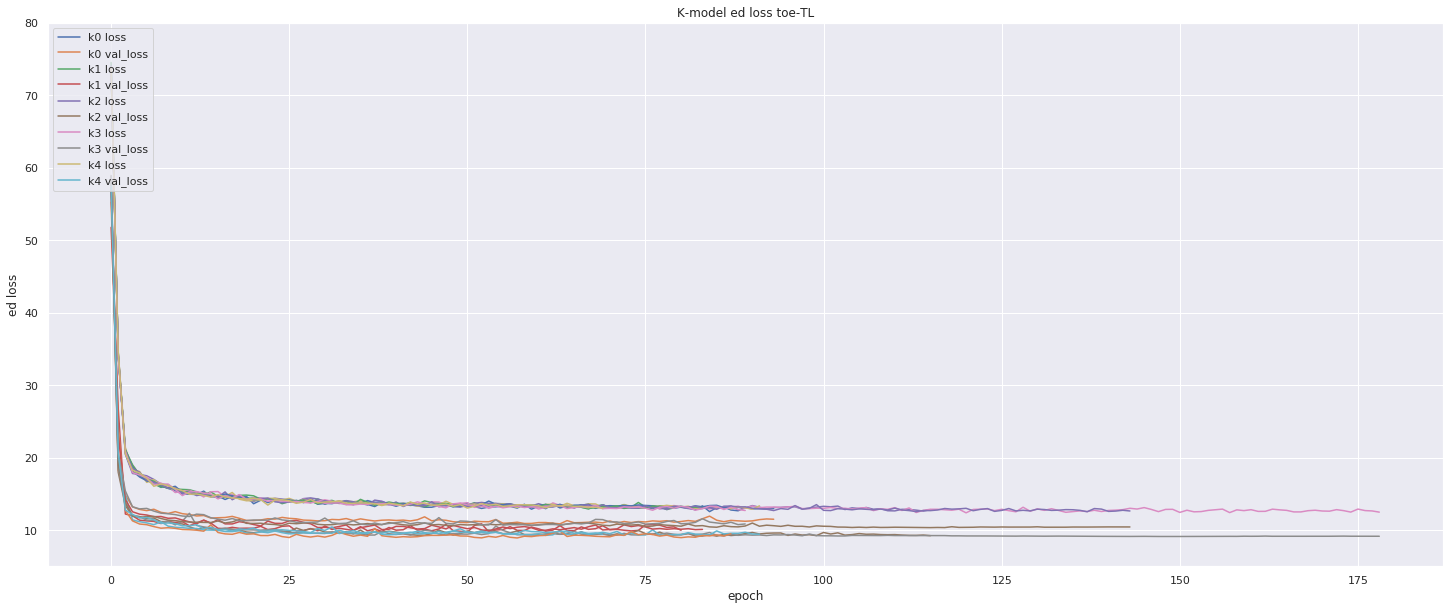

In [97]:
# Sum plot losses toe-tl

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_toe[k].history['loss'])
    plt.plot(history_toe[k].history['val_loss'])

    
plt.title('K-model ed loss toe-TL')
plt.ylabel('ed loss'), plt.ylim(5, 80)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_Ksum_TL.png', bbox_inches = 'tight')

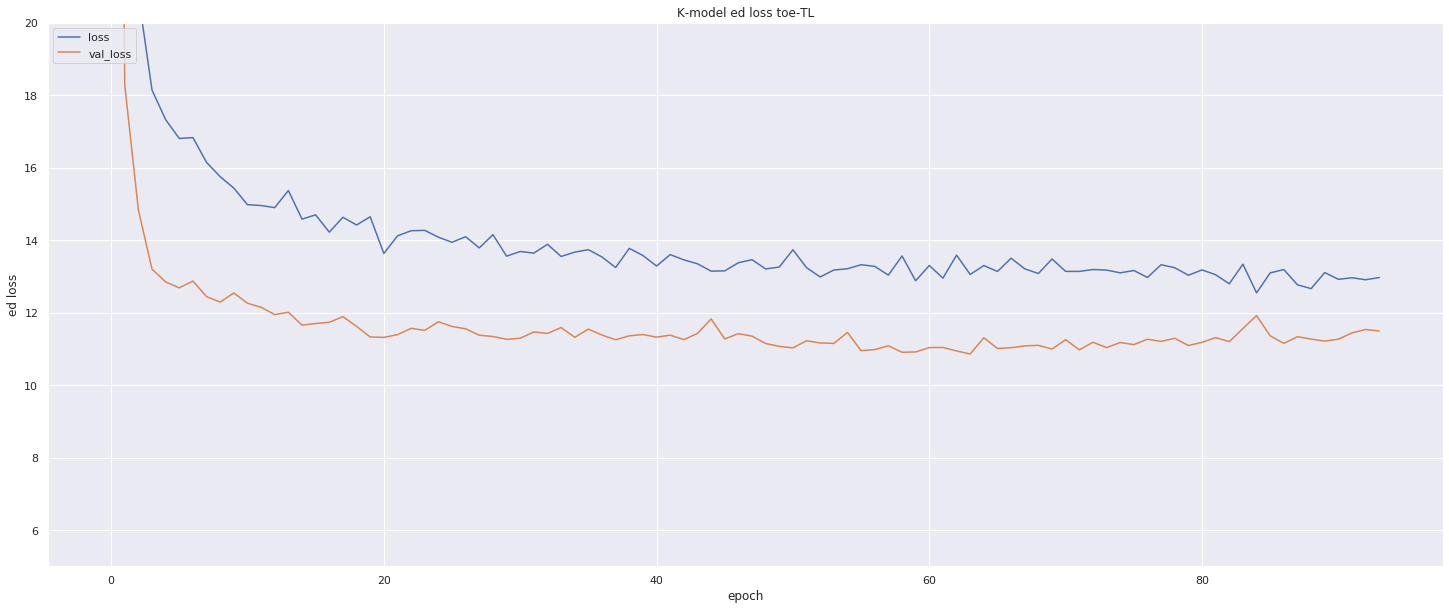

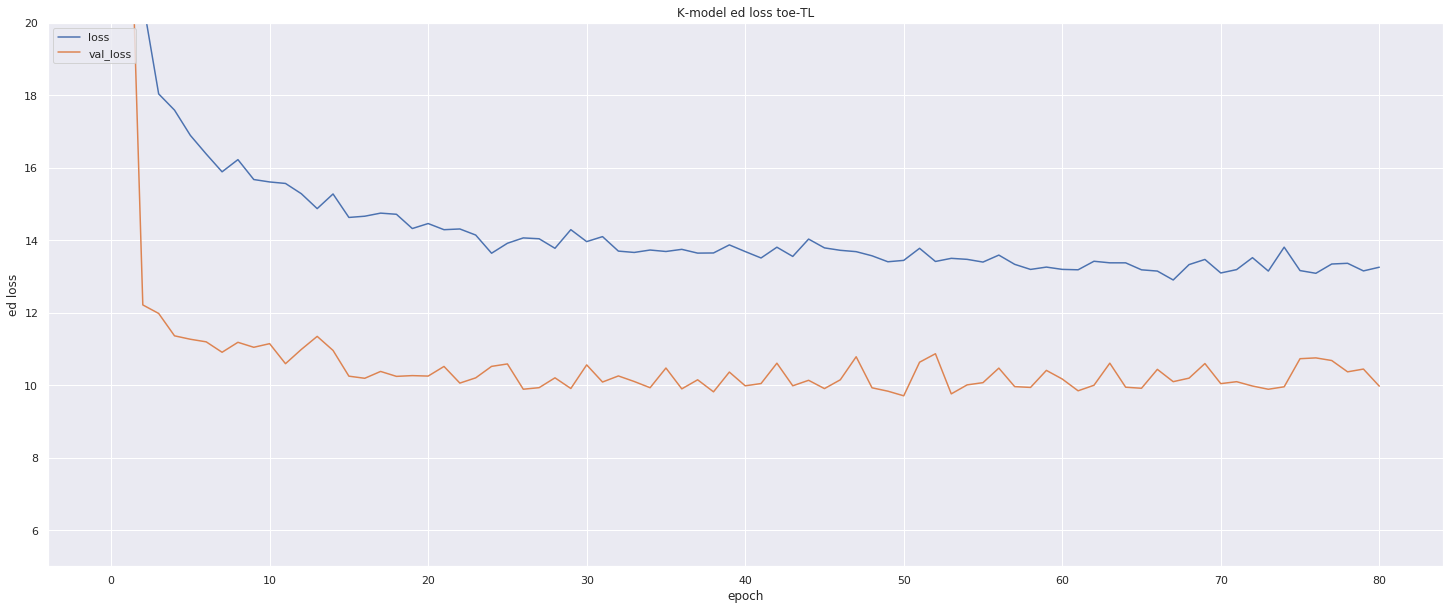

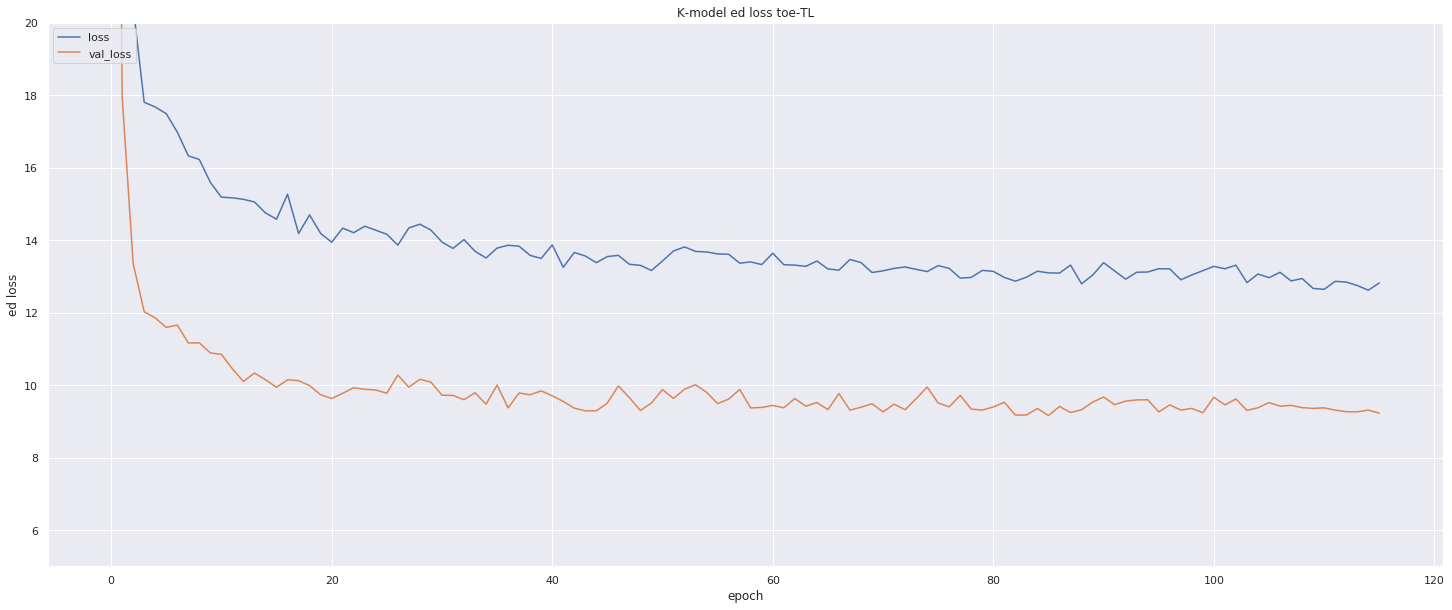

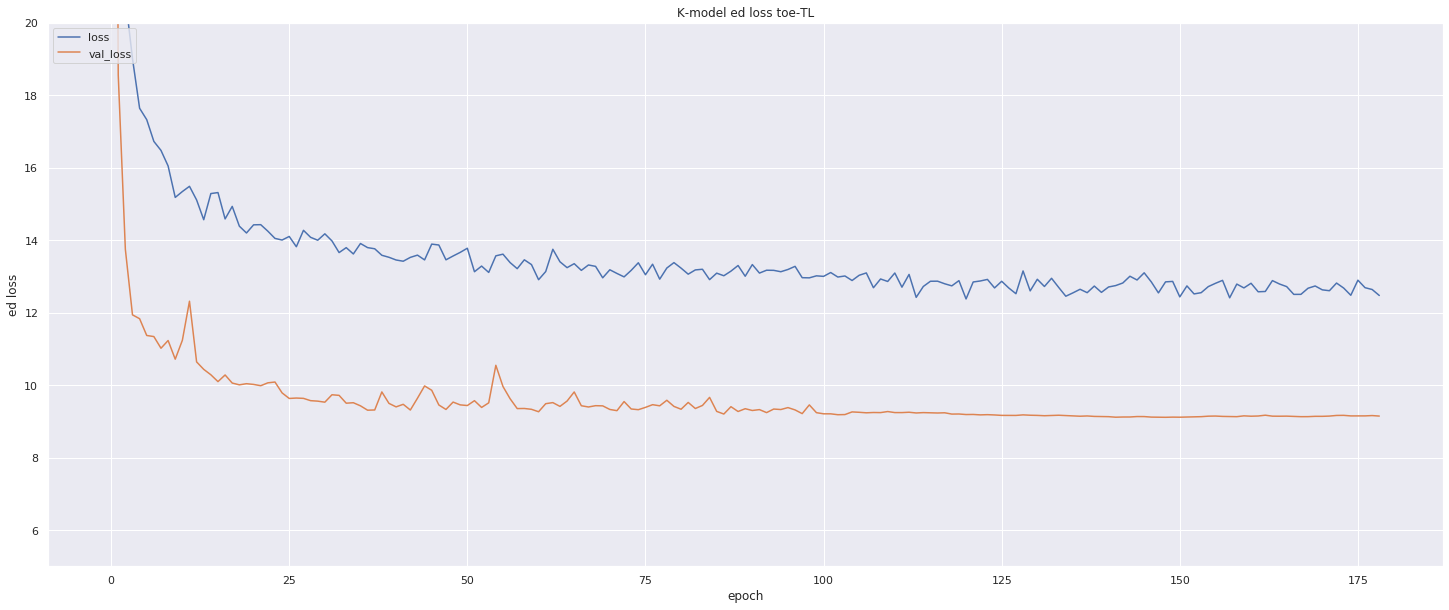

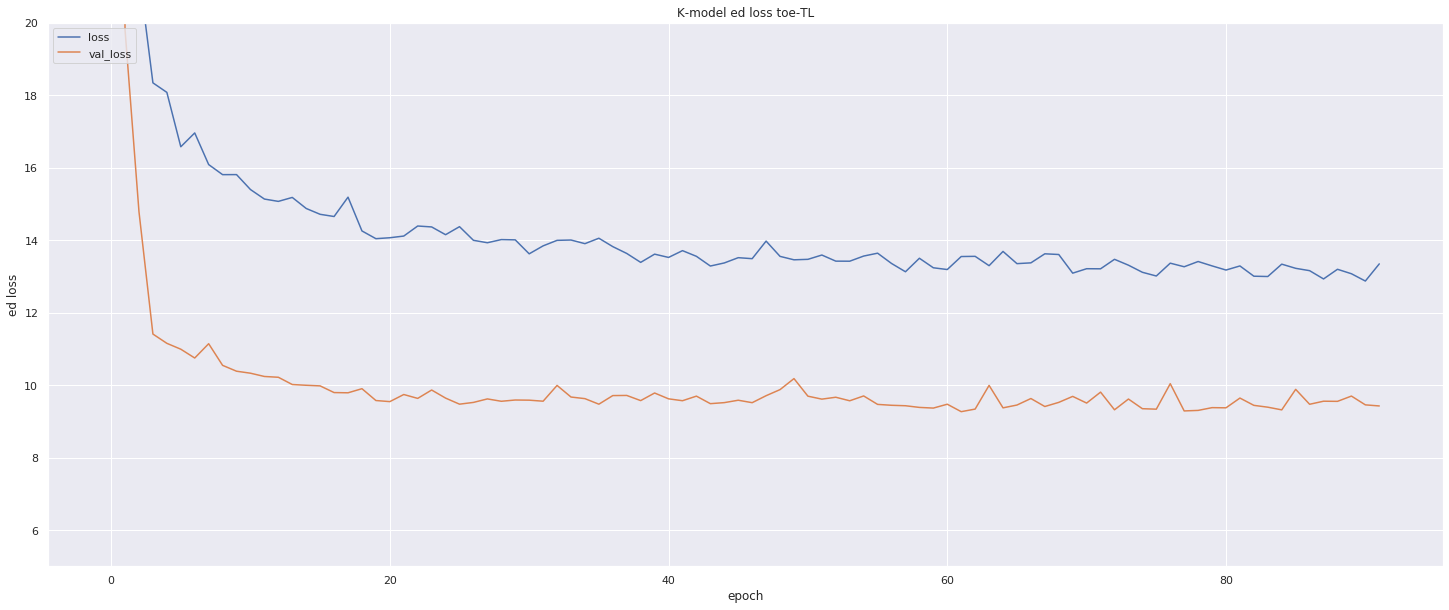

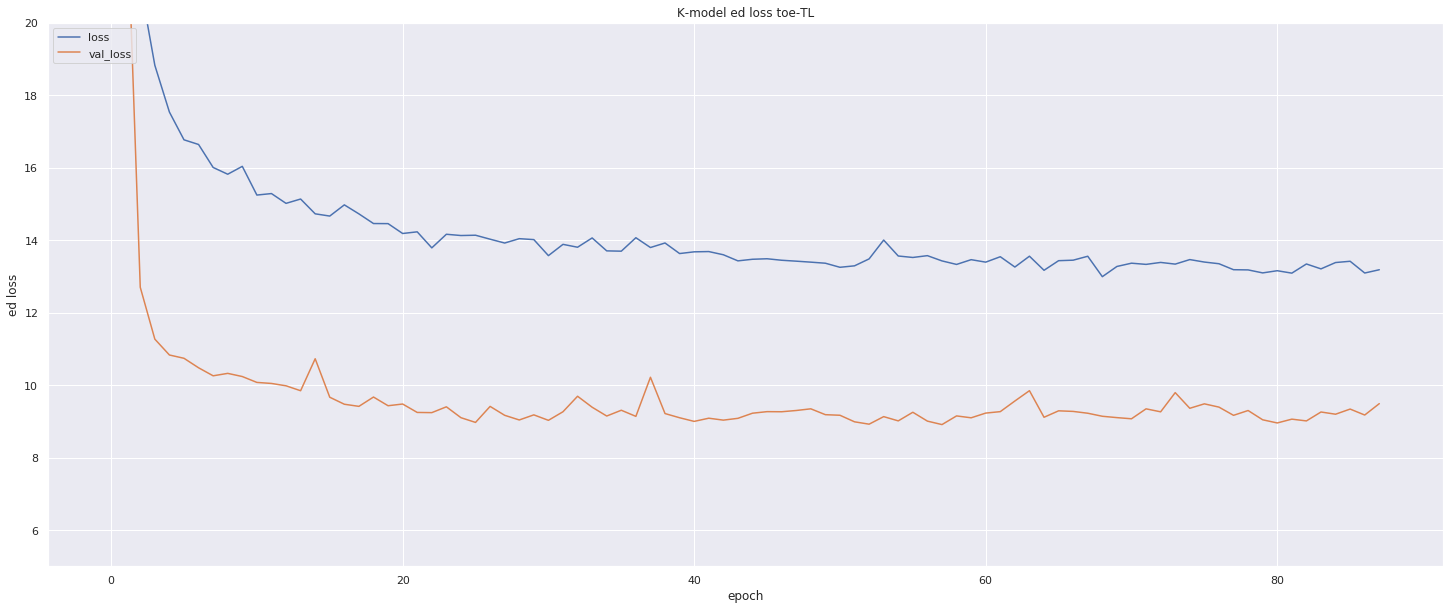

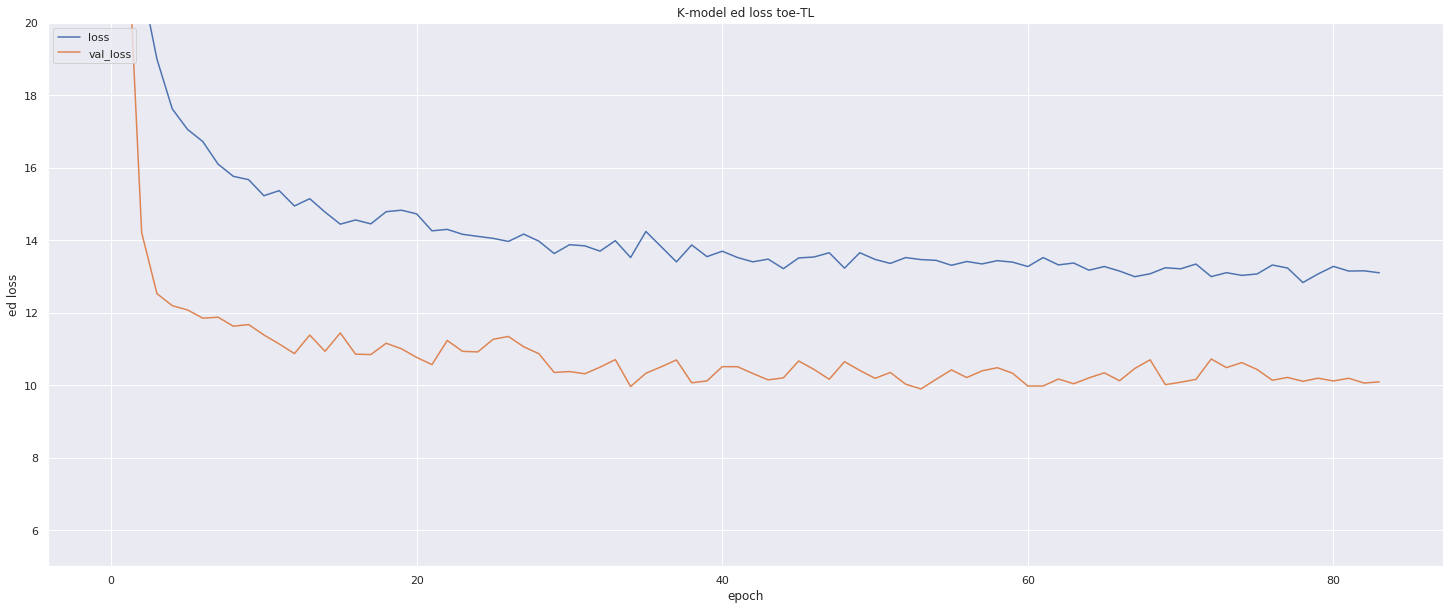

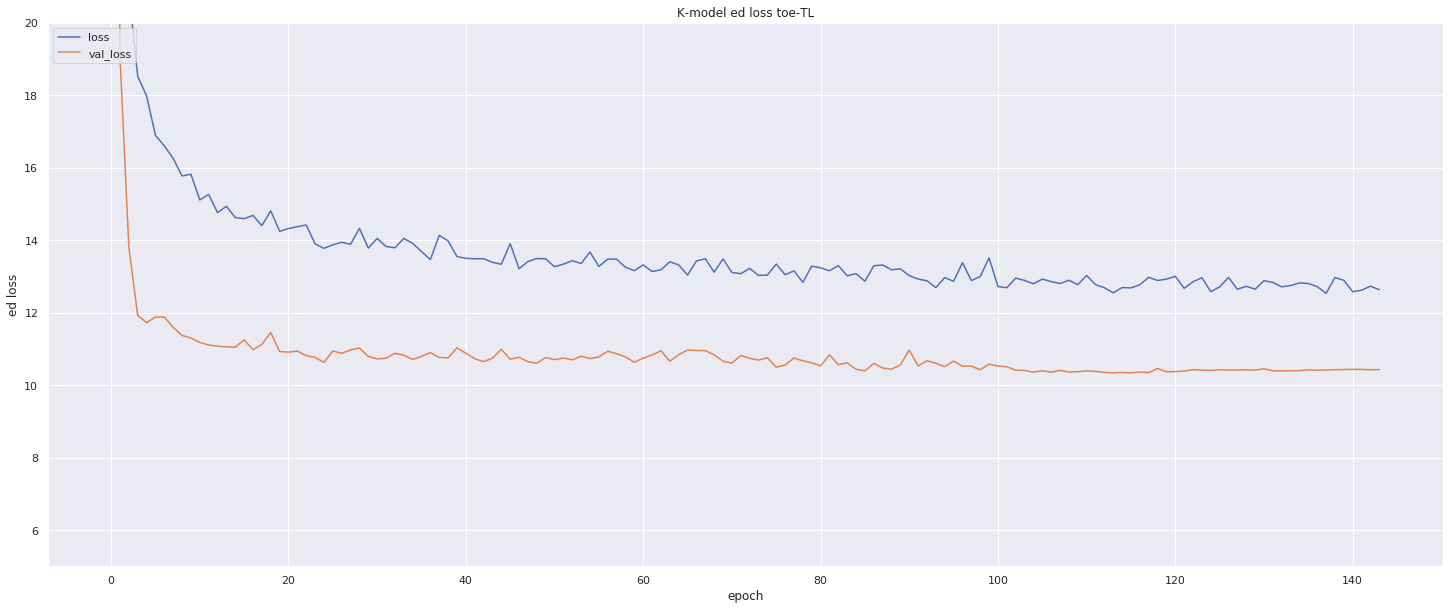

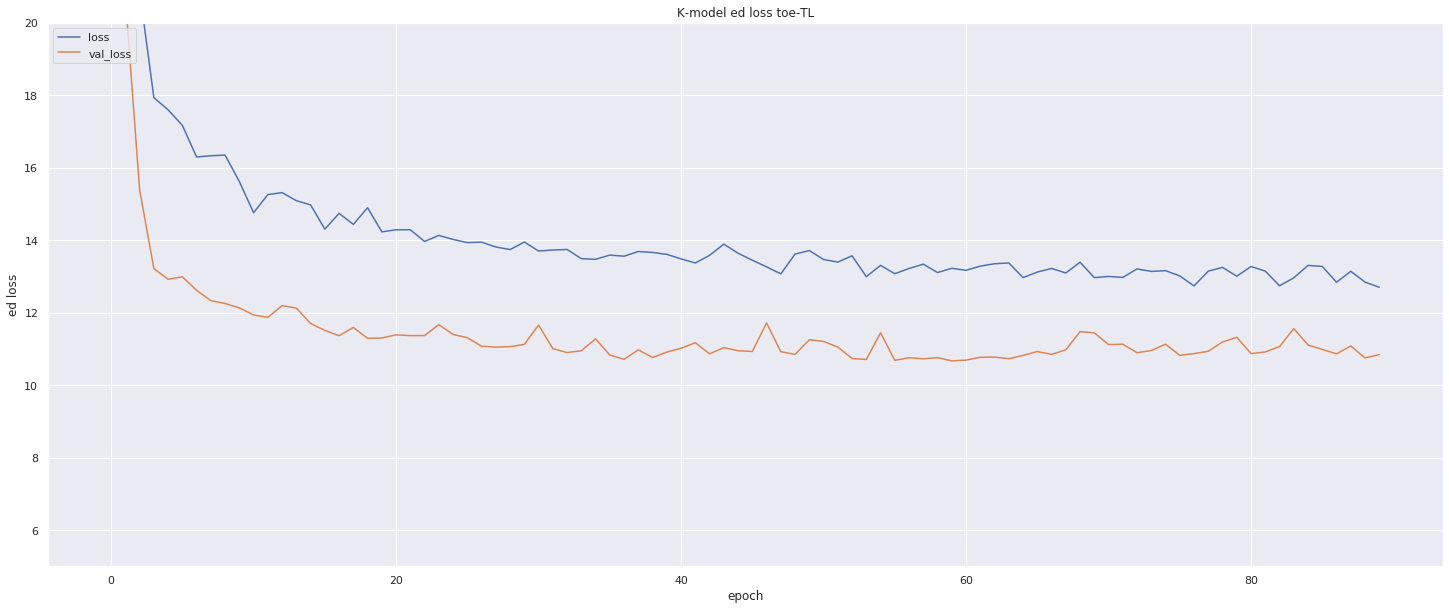

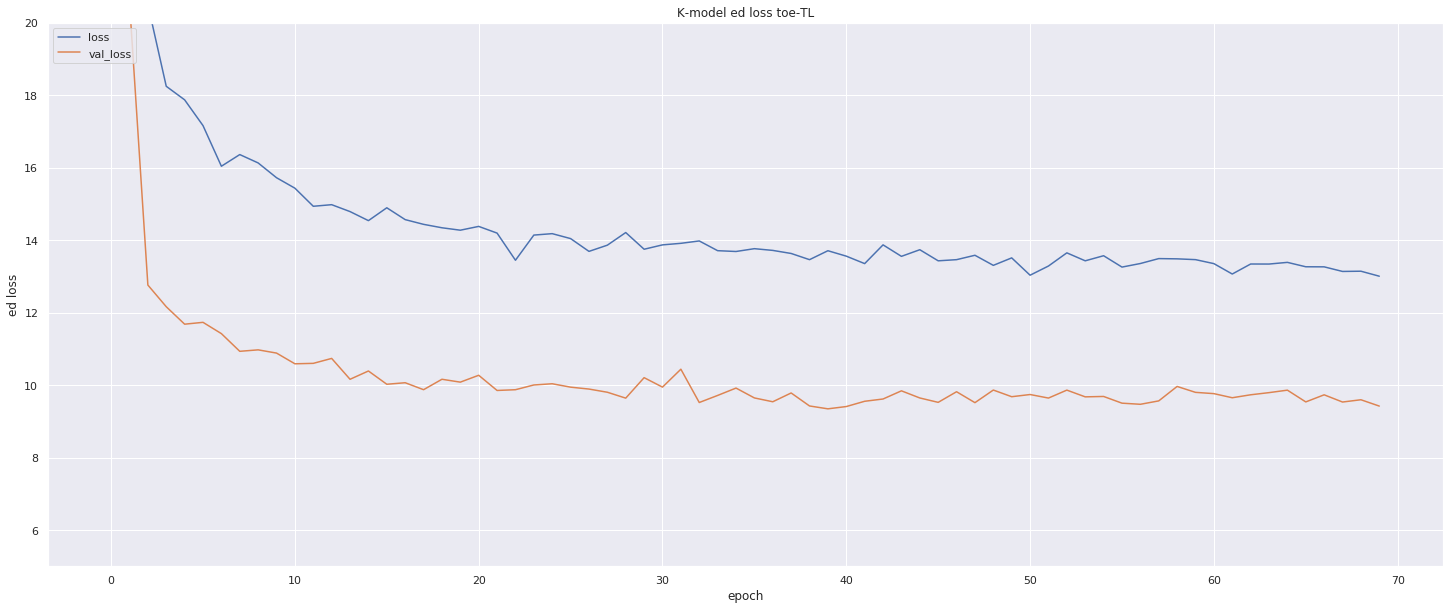

In [98]:
# Single plot loss toe-tl

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_toe[k].history['loss'])
    plt.plot(history_toe[k].history['val_loss'])
    plt.title('K-model ed loss toe-TL')
    plt.ylabel('ed loss'), plt.ylim(5, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_toe[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_K{k}_TL_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9


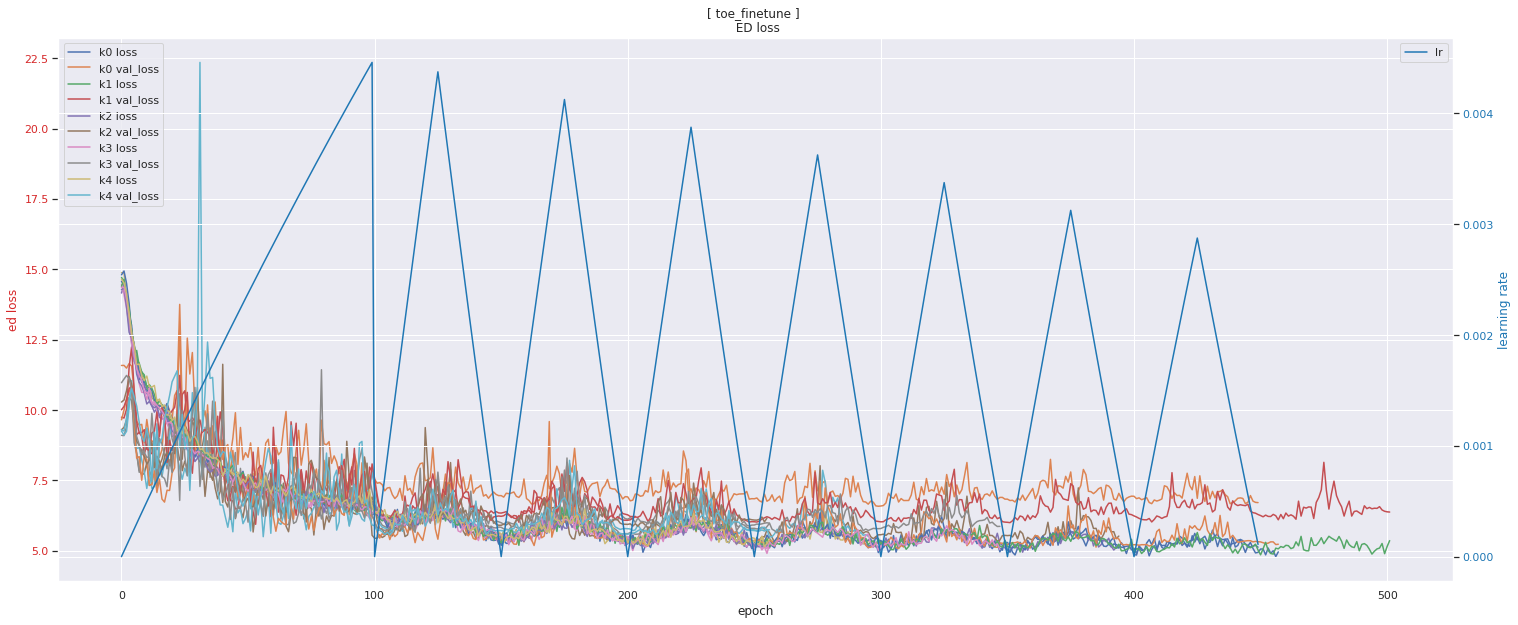

In [99]:
# check the loos the model trained.

def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
# h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
#     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
    
# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('[ toe_finetune ] \n ED loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

for k in range(KFlodNum):

    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])

ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.
ax1.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_toe_finetune[0].history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()

# # save plot : comment plo.show in jupyter notebook.
# def get_valloss(his_v_l):   
#     return np.min(his_v_l), np.argmin(his_v_l)

# vl, ep = get_valloss(history_toe_finetune.history['val_loss'])


t_vl = np.mean(t_vl, axis=0)
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_ft_Ksum-clr_ed{round(t_vl,4)}.png', bbox_inches = 'tight')

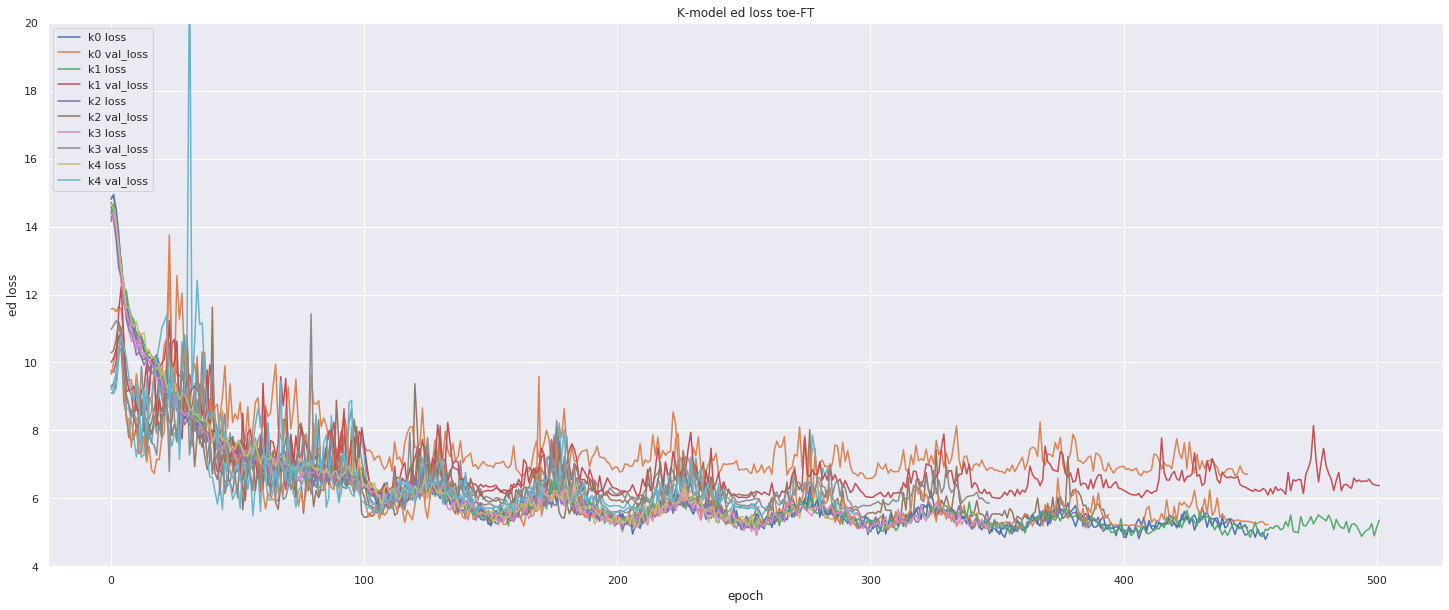

In [100]:
# Sum plot losses toe-ft

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])

    
plt.title('K-model ed loss toe-FT')
plt.ylabel('ed loss'), plt.ylim(4, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_Ksum_FT.png', bbox_inches = 'tight')

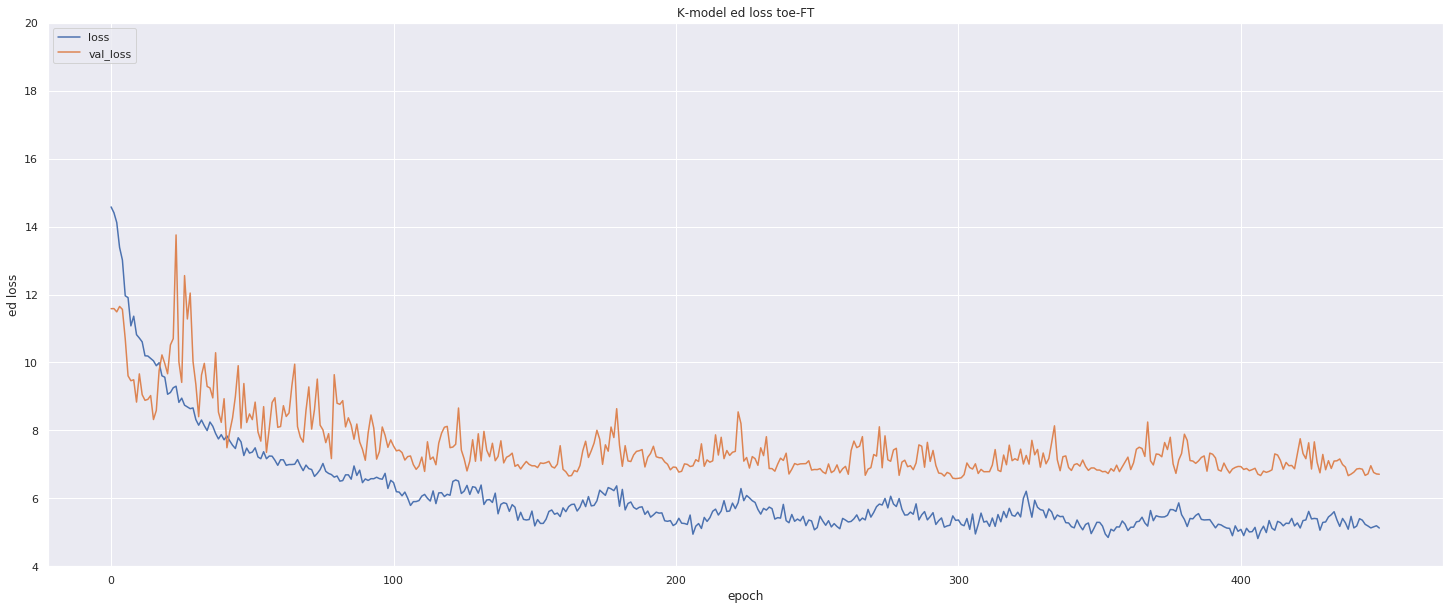

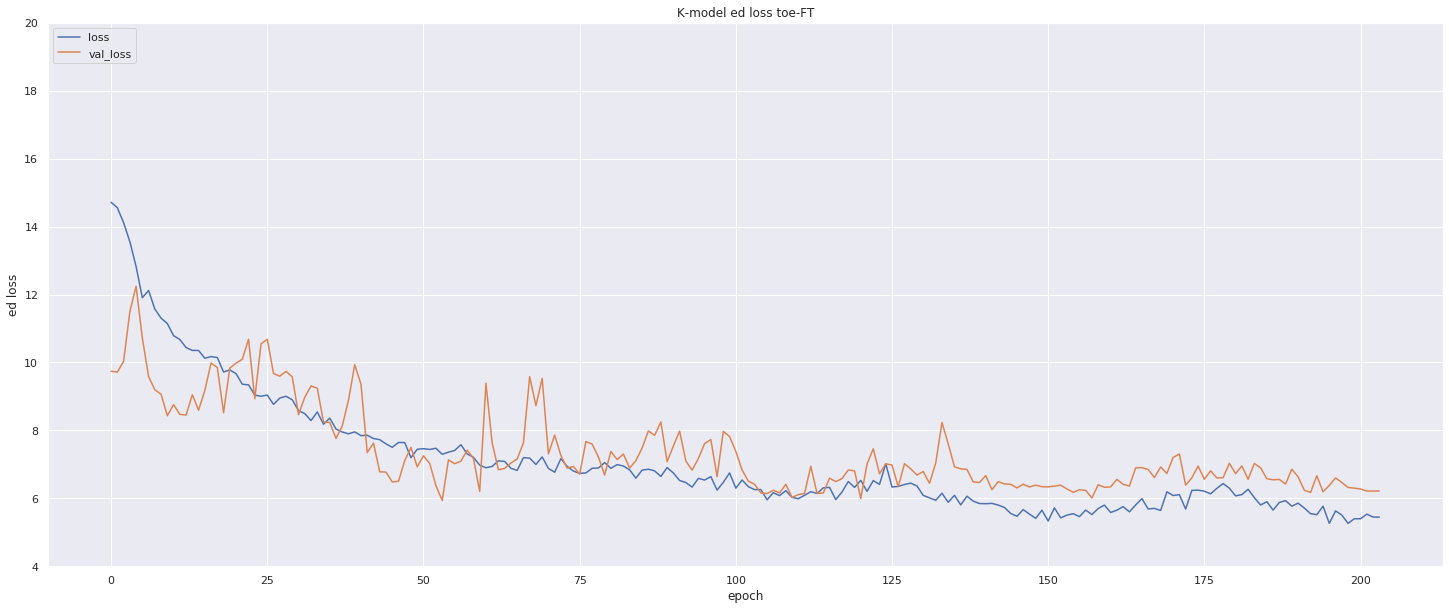

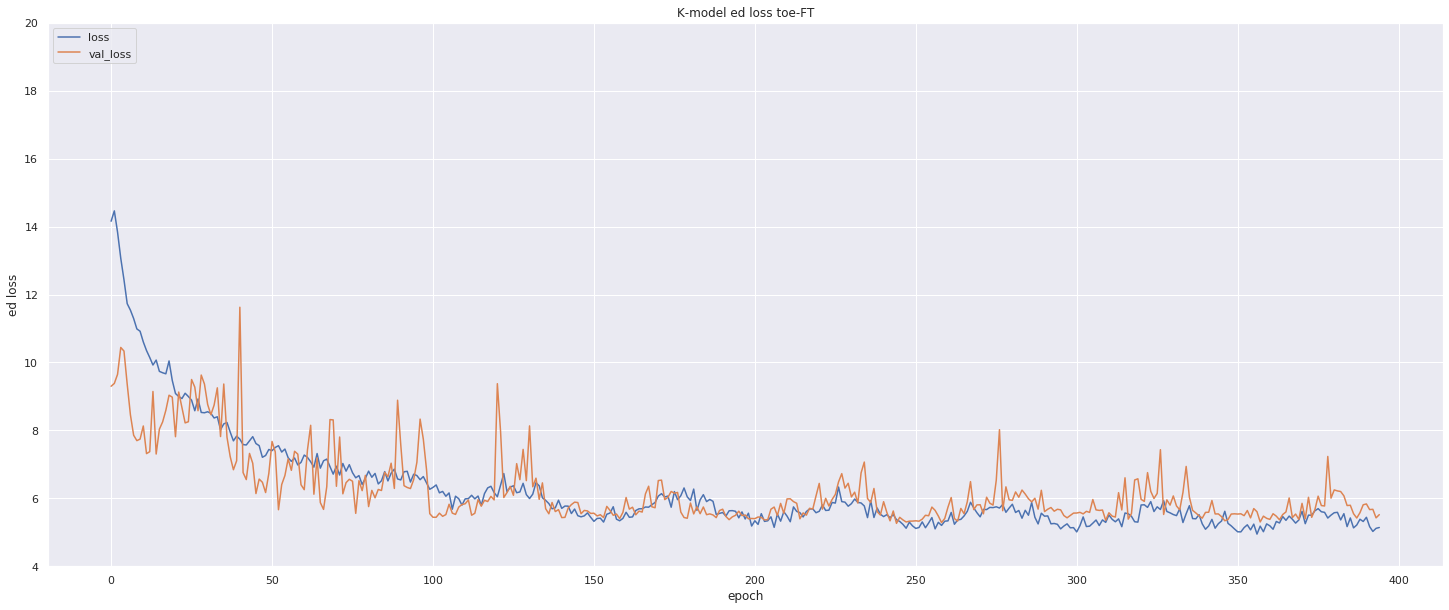

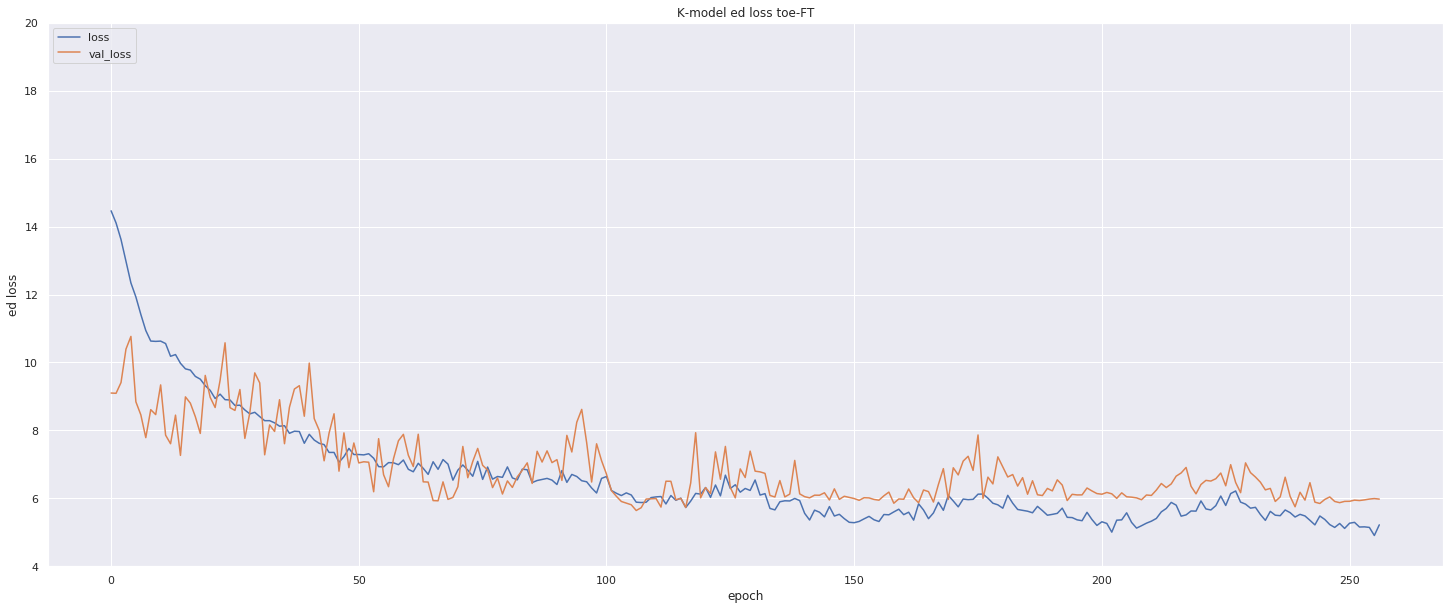

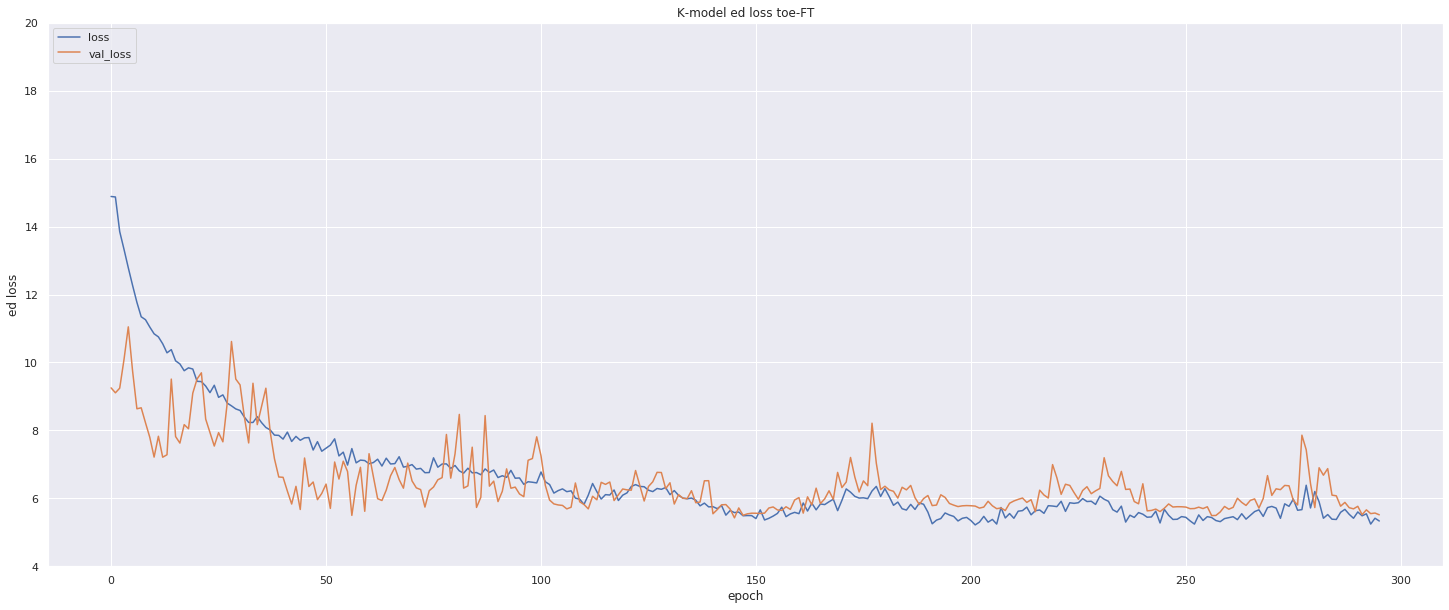

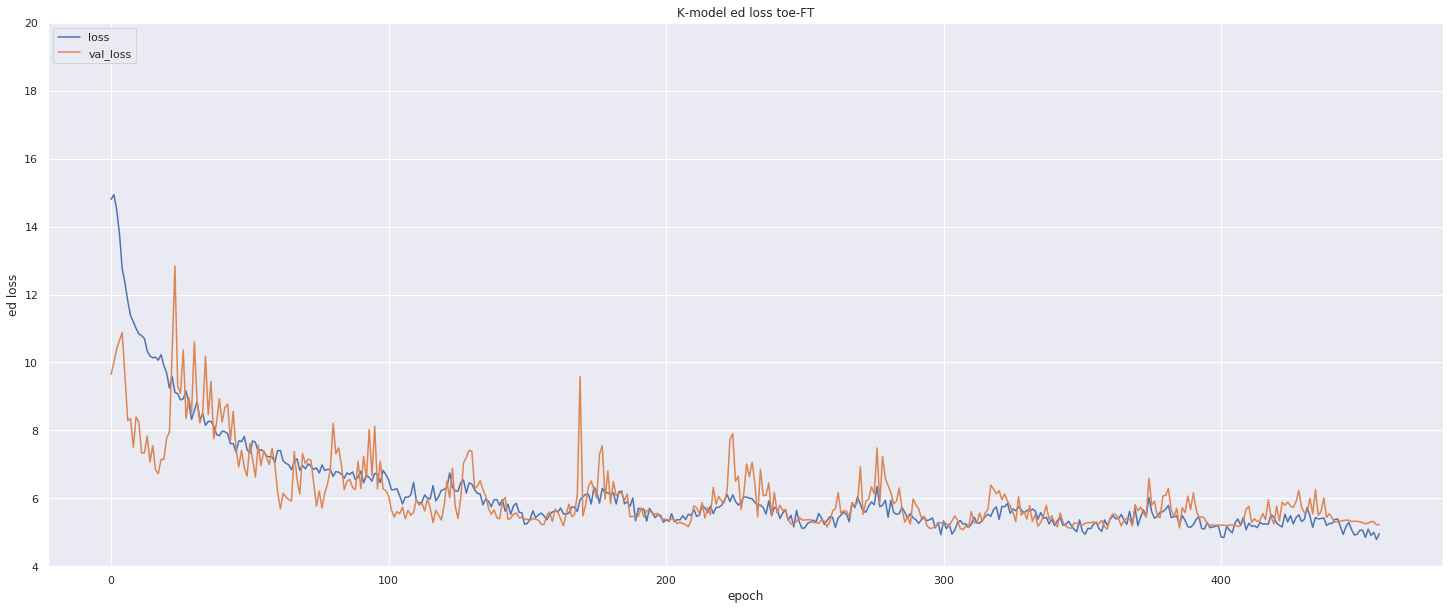

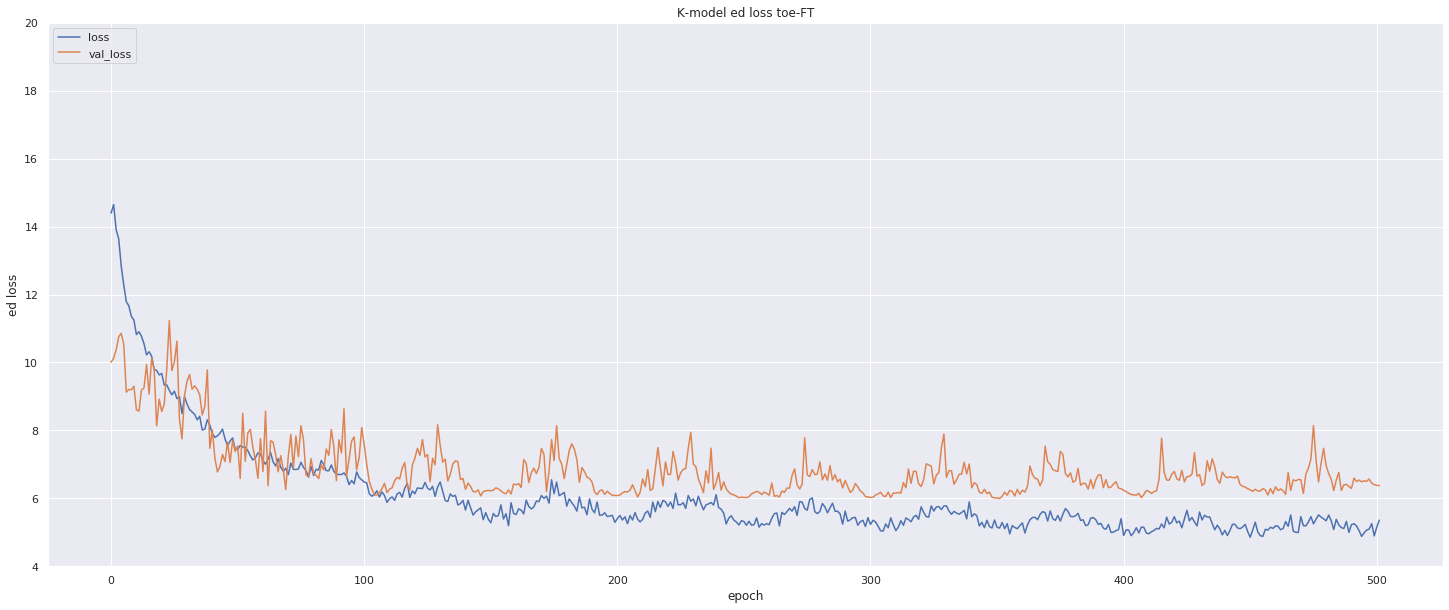

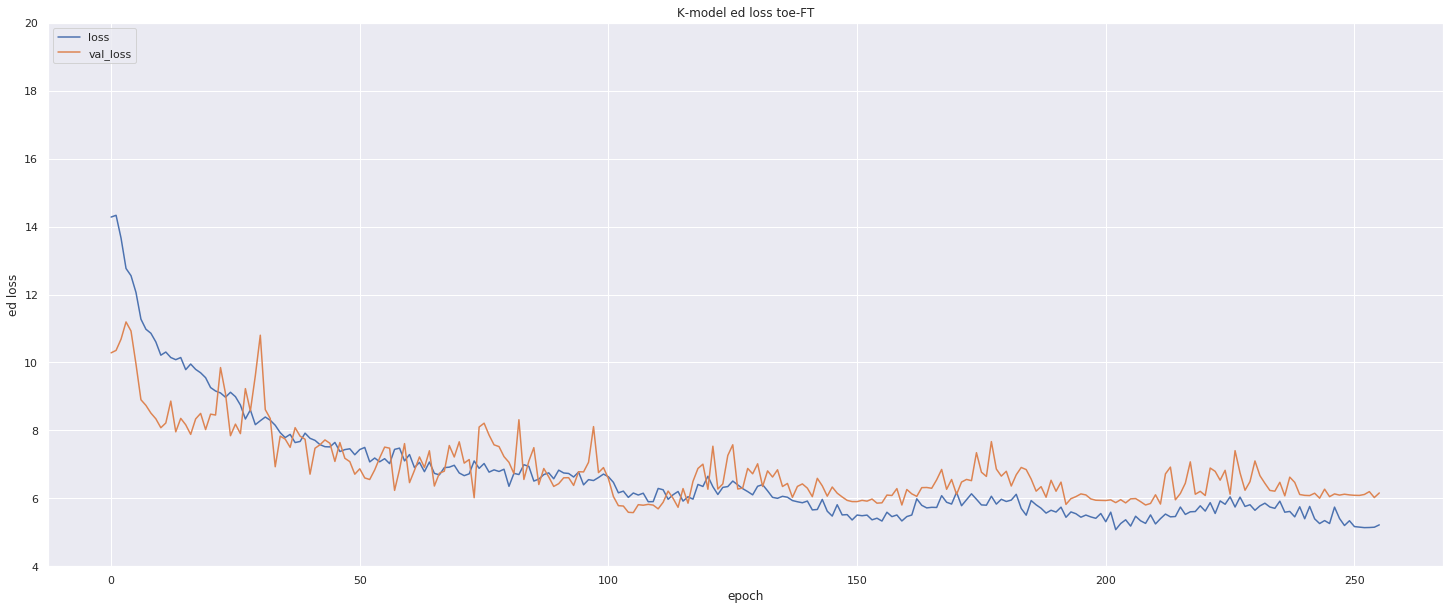

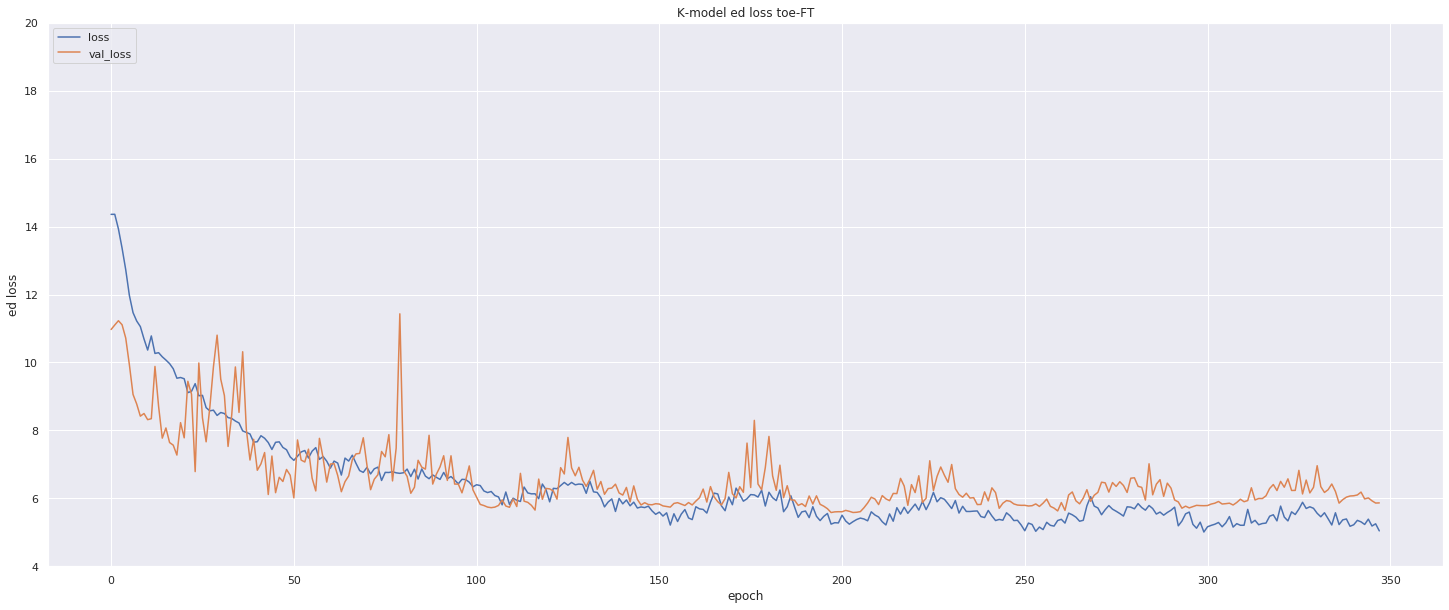

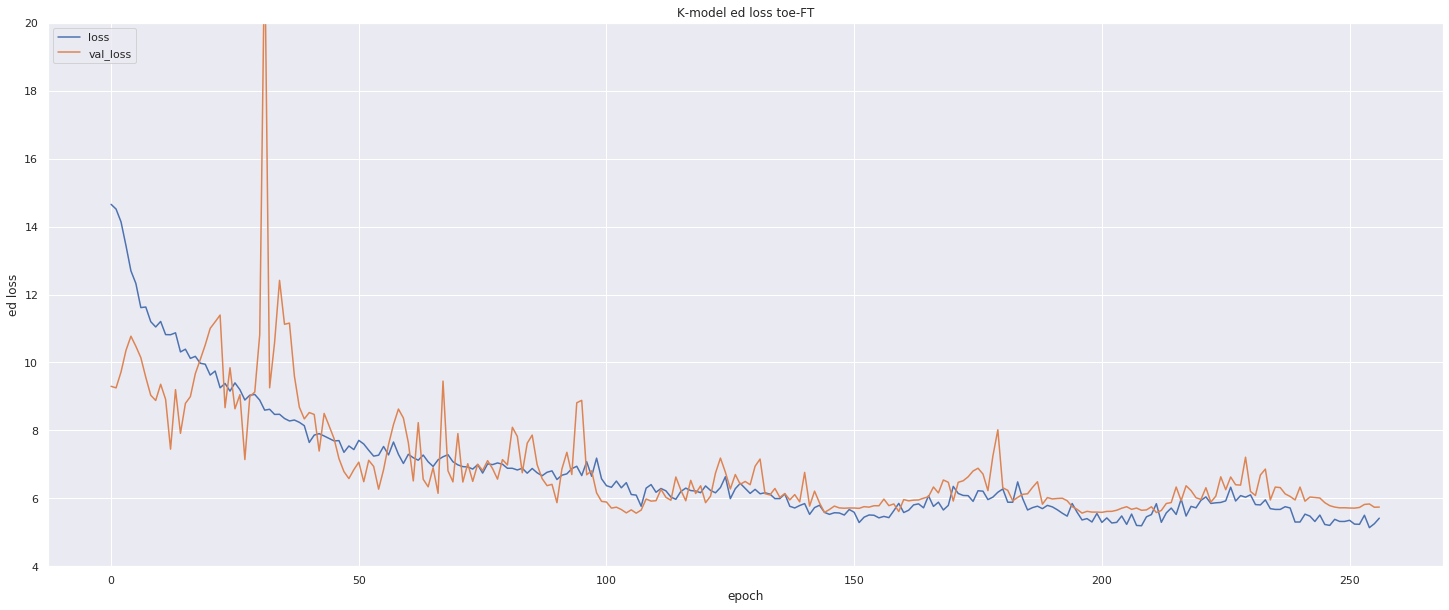

In [101]:
# Single plot loss toe-FT

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])
    plt.title('K-model ed loss toe-FT')
    plt.ylabel('ed loss'), plt.ylim(4, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_toe_finetune[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_K{k}_FT_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

### Heel K-model

In [102]:
%%time

# big K = 5 (fold 0 ~ 4) 
# KFlodNum = 5 # follow Toe's K.



history_heel = []
history_heel_finetune = []

#above until 'train_ds_map_toe now' to 'train_ds_map_toe_s', 'valid_ds_map_toe_s'
for k in range(KFlodNum):
    
    
    # Split data to train/valid with K-Fold #
    print("K=", k)
#     # Toe split
#     train_ds_map_toe_s, valid_ds_map_toe_s = get_KFold_ds(train_ds_map_toe, K=k)
    
#     # Toe ds_pre
#     train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
#     valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)
    
    
    # heel split
    train_ds_map_heel_s, valid_ds_map_heel_s = get_KFold_ds(train_ds_map_heel, K=k)
    # Heel ds_pre
    train_ds_pre_heel_s = configure_for_performance_cache_train_AToe(train_ds_map_heel_s, augment=True)
    valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)
    
    
    # Train K-Model with transfer learnling #
    
    # Toe model, TL
    #th = 'toe'
    th = 'heel'
    best_model_name = get_best_model_name(th, K=str(k))
    best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = monitor, 
                                 mode = 'auto', verbose = 1)
    callbacks_heel_tl = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=30), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
                        PrintLRtoe()
                        ]
    callbacks_heel_fn = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=150), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp, CosineDecayCLRWarmUpLSW
                        PrintLRheel()
                    ]
    print('best_model_name:', best_model_name)


    top_dropout_rate = 0.4 #less dp rate, say 0.1, train_loss will lower than val_loss
    drop_connect_rate = 0.4 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
    outputnum = 2
    with strategy.scope():
        model_heel = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)
    # fit the model on all data
    hist = model_heel.fit(train_ds_pre_heel_s, 
                          verbose=1, 
                          epochs=ep_num_transf, 
                          validation_data=valid_ds_pre_heel_s, 
                          callbacks=callbacks_heel_tl)#, validation_split=0.1)
    history_heel.append(hist)
    
      
    # Train K-Model with fine tune #
    
    # Toe model, FT
    unfreeze_model(model_heel)
    count_model_trainOrNot_layers(model_heel)
    # fit the model on all data
    hist = model_heel.fit(train_ds_pre_heel_s, 
                          verbose=1, 
                          epochs=ep_num, 
                          validation_data=valid_ds_pre_heel_s, 
                          callbacks=callbacks_heel_fn)#, validation_split=0.1)
    history_heel_finetune.append(hist)


K= 0
Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
best_model_name: ./20210302-234745/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
base_model.trainable :  False

[20210303-0541-32] Learning rate for epoch 1 is 0.0008930827025324106
Epoch 1/500
18/19 [===========================>..] - ETA: 0s - loss: 104.0144
Epoch 00001: val_loss improved from inf to 79.55354, saving model to ./20210302-234745/heel_K0_EfficientNetB0_bs64_w1

19/19 [==============================] - ETA: 0s - loss: 11.9304
Epoch 00021: val_loss improved from 11.59949 to 11.35571, saving model to ./20210302-234745/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 43ms/step - loss: 11.9304 - val_loss: 11.3557

[20210303-0543-26] Learning rate for epoch 22 is 0.0008930827025324106
Epoch 22/500
16/19 [========================>.....] - ETA: 0s - loss: 13.1124
Epoch 00022: val_loss improved from 11.35571 to 10.33554, saving model to ./20210302-234745/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 41ms/step - loss: 12.8966 - val_loss: 10.3355

[20210303-0543-30] Learning rate for epoch 23 is 0.0008930827025324106
Epoch 23/500
19/19 [==============================] - ETA: 0s - loss: 11.9632
Epoch 00023: val_loss improved from 10.33554 to 9.87948, saving model to ./20210302-234745/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [=======================

19/19 [==============================] - ETA: 0s - loss: 11.3905
Epoch 00046: val_loss did not improve from 6.67737
19/19 [==============================] - 1s 27ms/step - loss: 11.3905 - val_loss: 6.7792

[20210303-0545-06] Learning rate for epoch 47 is 0.0008930827025324106
Epoch 47/500
16/19 [========================>.....] - ETA: 0s - loss: 11.3188
Epoch 00047: val_loss improved from 6.67737 to 6.57542, saving model to ./20210302-234745/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 42ms/step - loss: 11.0886 - val_loss: 6.5754

[20210303-0545-10] Learning rate for epoch 48 is 0.0008930827025324106
Epoch 48/500
19/19 [==============================] - ETA: 0s - loss: 11.2530
Epoch 00048: val_loss did not improve from 6.57542
19/19 [==============================] - 0s 23ms/step - loss: 11.2530 - val_loss: 6.5911

[20210303-0545-14] Learning rate for epoch 49 is 0.0008930827025324106
Epoch 49/500
16/19 [========================>.....] - 


[20210303-0546-49] Learning rate for epoch 74 is 0.0008930827025324106
Epoch 74/500
17/19 [=========================>....] - ETA: 0s - loss: 11.3208
Epoch 00074: val_loss did not improve from 6.46517
19/19 [==============================] - 0s 22ms/step - loss: 11.3655 - val_loss: 7.3266

[20210303-0546-52] Learning rate for epoch 75 is 0.0008930827025324106
Epoch 75/500
19/19 [==============================] - ETA: 0s - loss: 11.1445
Epoch 00075: val_loss did not improve from 6.46517
19/19 [==============================] - 0s 23ms/step - loss: 11.1445 - val_loss: 6.4937

[20210303-0546-56] Learning rate for epoch 76 is 0.0008930827025324106
Epoch 76/500
16/19 [========================>.....] - ETA: 0s - loss: 10.8216
Epoch 00076: val_loss improved from 6.46517 to 6.36194, saving model to ./20210302-234745/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 42ms/step - loss: 10.9139 - val_loss: 6.3619

[20210303-0547-00] Learning rate for epo

19/19 [==============================] - ETA: 0s - loss: 10.7696
Epoch 00101: val_loss did not improve from 6.24721
19/19 [==============================] - 0s 23ms/step - loss: 10.7696 - val_loss: 7.0889

[20210303-0548-36] Learning rate for epoch 102 is 0.0008930827025324106
Epoch 102/500
16/19 [========================>.....] - ETA: 0s - loss: 11.1126
Epoch 00102: val_loss did not improve from 6.24721
19/19 [==============================] - 0s 22ms/step - loss: 11.0805 - val_loss: 6.2703

[20210303-0548-40] Learning rate for epoch 103 is 0.0008930827025324106
Epoch 103/500
19/19 [==============================] - ETA: 0s - loss: 11.2787
Epoch 00103: val_loss did not improve from 6.24721
19/19 [==============================] - 0s 23ms/step - loss: 11.2787 - val_loss: 6.6943

[20210303-0548-44] Learning rate for epoch 104 is 0.0008930827025324106
Epoch 104/500
16/19 [========================>.....] - ETA: 0s - loss: 11.5776
Epoch 00104: val_loss did not improve from 6.24721
19/19 [=

16/19 [========================>.....] - ETA: 0s - loss: 10.5718
Epoch 00128: val_loss did not improve from 6.18315
19/19 [==============================] - 0s 23ms/step - loss: 10.6382 - val_loss: 6.2842

[20210303-0550-19] Learning rate for epoch 129 is 0.0008930827025324106
Epoch 129/500
16/19 [========================>.....] - ETA: 0s - loss: 10.5271
Epoch 00129: val_loss did not improve from 6.18315
19/19 [==============================] - 0s 22ms/step - loss: 10.4714 - val_loss: 6.1925

[20210303-0550-23] Learning rate for epoch 130 is 0.0008930827025324106
Epoch 130/500
19/19 [==============================] - ETA: 0s - loss: 10.6577
Epoch 00130: val_loss did not improve from 6.18315
19/19 [==============================] - 0s 23ms/step - loss: 10.6577 - val_loss: 6.1949

[20210303-0550-26] Learning rate for epoch 131 is 0.0008930827025324106
Epoch 131/500
16/19 [========================>.....] - ETA: 0s - loss: 10.7470
Epoch 00131: val_loss did not improve from 6.18315
19/19 [=


[20210303-0552-02] Learning rate for epoch 156 is 0.0008930827025324106
Epoch 156/500
19/19 [==============================] - ETA: 0s - loss: 10.5050
Epoch 00156: val_loss did not improve from 6.16321
19/19 [==============================] - 0s 23ms/step - loss: 10.5050 - val_loss: 6.2404

[20210303-0552-05] Learning rate for epoch 157 is 0.0008930827025324106
Epoch 157/500
16/19 [========================>.....] - ETA: 0s - loss: 10.5784
Epoch 00157: val_loss did not improve from 6.16321
19/19 [==============================] - 0s 22ms/step - loss: 10.6396 - val_loss: 6.2431

[20210303-0552-09] Learning rate for epoch 158 is 0.0008930827025324106
Epoch 158/500
16/19 [========================>.....] - ETA: 0s - loss: 10.9213
Epoch 00158: val_loss did not improve from 6.16321
19/19 [==============================] - 0s 23ms/step - loss: 10.7942 - val_loss: 6.2377

[20210303-0552-13] Learning rate for epoch 159 is 0.0008930827025324106
Epoch 159/500
16/19 [========================>.....


[20210303-0553-45] Learning rate for epoch 183 is 0.0008930827025324106
Epoch 183/500
16/19 [========================>.....] - ETA: 0s - loss: 10.5021
Epoch 00183: val_loss did not improve from 6.11479
19/19 [==============================] - 0s 22ms/step - loss: 10.4580 - val_loss: 6.3498

[20210303-0553-49] Learning rate for epoch 184 is 0.0008930827025324106
Epoch 184/500
16/19 [========================>.....] - ETA: 0s - loss: 10.7266
Epoch 00184: val_loss did not improve from 6.11479
19/19 [==============================] - 0s 22ms/step - loss: 10.7262 - val_loss: 6.2037

[20210303-0553-52] Learning rate for epoch 185 is 0.0008930827025324106
Epoch 185/500
19/19 [==============================] - ETA: 0s - loss: 10.4785
Epoch 00185: val_loss did not improve from 6.11479
19/19 [==============================] - 0s 24ms/step - loss: 10.4785 - val_loss: 6.2938

[20210303-0553-56] Learning rate for epoch 186 is 0.0008930827025324106
Epoch 186/500
19/19 [==============================

Epoch 5/1000
19/19 [==============================] - ETA: 0s - loss: 11.3027
Epoch 00005: val_loss did not improve from 6.11479

[20210303-0556-28] Learning rate for epoch 5 is 0.0001996780774788931
19/19 [==============================] - 1s 63ms/step - loss: 11.3027 - val_loss: 8.0883
Epoch 6/1000
19/19 [==============================] - ETA: 0s - loss: 10.7388
Epoch 00006: val_loss did not improve from 6.11479

[20210303-0556-33] Learning rate for epoch 6 is 0.000249222619459033
19/19 [==============================] - 1s 64ms/step - loss: 10.7388 - val_loss: 8.0834
Epoch 7/1000
19/19 [==============================] - ETA: 0s - loss: 10.7510
Epoch 00007: val_loss did not improve from 6.11479

[20210303-0556-38] Learning rate for epoch 7 is 0.0002986671752296388
19/19 [==============================] - 1s 64ms/step - loss: 10.7510 - val_loss: 6.8443
Epoch 8/1000
19/19 [==============================] - ETA: 0s - loss: 10.1855
Epoch 00008: val_loss did not improve from 6.11479

[202

Epoch 33/1000
19/19 [==============================] - ETA: 0s - loss: 6.7391
Epoch 00033: val_loss did not improve from 4.62320

[20210303-0558-40] Learning rate for epoch 33 is 0.0015491291414946318
19/19 [==============================] - 1s 64ms/step - loss: 6.7391 - val_loss: 4.9099
Epoch 34/1000
19/19 [==============================] - ETA: 0s - loss: 6.4957
Epoch 00034: val_loss improved from 4.62320 to 4.25475, saving model to ./20210302-234745/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-0558-46] Learning rate for epoch 34 is 0.00159587396774441
19/19 [==============================] - 2s 94ms/step - loss: 6.4957 - val_loss: 4.2547
Epoch 35/1000
19/19 [==============================] - ETA: 0s - loss: 6.1868
Epoch 00035: val_loss improved from 4.25475 to 4.18163, saving model to ./20210302-234745/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-0558-51] Learning rate for epoch 35 is 0.001642518793232739
19/19 [==============================] - 2s 94

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 304/1000
19/19 [==============================] - ETA: 0s - loss: 4.6817
Epoch 00304: val_loss did not improve from 3.37012

[20210303-0646-36] Learning rate for epoch 304 is 0.0004185066791251302
19/19 [==============================] - 1s 64ms/step - loss: 4.6817 - val_loss: 3.8343
K= 2
Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
best_model_name: ./20210302-234745/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
base_


[20210303-0648-22] Learning rate for epoch 20 is 0.0008930827025324106
Epoch 20/500
19/19 [==============================] - ETA: 0s - loss: 12.0325
Epoch 00020: val_loss improved from 12.66709 to 12.12026, saving model to ./20210302-234745/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 41ms/step - loss: 12.0325 - val_loss: 12.1203

[20210303-0648-26] Learning rate for epoch 21 is 0.0008930827025324106
Epoch 21/500
19/19 [==============================] - ETA: 0s - loss: 12.0365
Epoch 00021: val_loss improved from 12.12026 to 12.06157, saving model to ./20210302-234745/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 42ms/step - loss: 12.0365 - val_loss: 12.0616

[20210303-0648-30] Learning rate for epoch 22 is 0.0008930827025324106
Epoch 22/500
19/19 [==============================] - ETA: 0s - loss: 11.7246
Epoch 00022: val_loss did not improve from 12.06157
19/19 [===========================


[20210303-0649-58] Learning rate for epoch 44 is 0.0008930827025324106
Epoch 44/500
19/19 [==============================] - ETA: 0s - loss: 11.2846
Epoch 00044: val_loss improved from 7.27051 to 7.07676, saving model to ./20210302-234745/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 41ms/step - loss: 11.2846 - val_loss: 7.0768

[20210303-0650-02] Learning rate for epoch 45 is 0.0008930827025324106
Epoch 45/500
16/19 [========================>.....] - ETA: 0s - loss: 11.6373
Epoch 00045: val_loss did not improve from 7.07676
19/19 [==============================] - 0s 22ms/step - loss: 11.6607 - val_loss: 7.4268

[20210303-0650-06] Learning rate for epoch 46 is 0.0008930827025324106
Epoch 46/500
19/19 [==============================] - ETA: 0s - loss: 11.3806
Epoch 00046: val_loss improved from 7.07676 to 6.97938, saving model to ./20210302-234745/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 

19/19 [==============================] - ETA: 0s - loss: 10.8838
Epoch 00070: val_loss did not improve from 6.75352
19/19 [==============================] - 0s 23ms/step - loss: 10.8838 - val_loss: 7.6437

[20210303-0651-42] Learning rate for epoch 71 is 0.0008930827025324106
Epoch 71/500
16/19 [========================>.....] - ETA: 0s - loss: 11.3237
Epoch 00071: val_loss did not improve from 6.75352
19/19 [==============================] - 0s 22ms/step - loss: 11.3947 - val_loss: 6.8677

[20210303-0651-46] Learning rate for epoch 72 is 0.0008930827025324106
Epoch 72/500
19/19 [==============================] - ETA: 0s - loss: 10.6945
Epoch 00072: val_loss did not improve from 6.75352
19/19 [==============================] - 0s 23ms/step - loss: 10.6945 - val_loss: 7.4202

[20210303-0651-50] Learning rate for epoch 73 is 0.0008930827025324106
Epoch 73/500
17/19 [=========================>....] - ETA: 0s - loss: 10.8924
Epoch 00073: val_loss did not improve from 6.75352
19/19 [=======

19/19 [==============================] - ETA: 0s - loss: 11.0962
Epoch 00098: val_loss did not improve from 6.72277
19/19 [==============================] - 0s 22ms/step - loss: 11.0962 - val_loss: 7.0397

[20210303-0653-29] Learning rate for epoch 99 is 0.0008930827025324106
Epoch 99/500
19/19 [==============================] - ETA: 0s - loss: 10.7530
Epoch 00099: val_loss did not improve from 6.72277
19/19 [==============================] - 0s 22ms/step - loss: 10.7530 - val_loss: 7.7534

[20210303-0653-32] Learning rate for epoch 100 is 0.0008930827025324106
Epoch 100/500
16/19 [========================>.....] - ETA: 0s - loss: 10.8374
Epoch 00100: val_loss did not improve from 6.72277
19/19 [==============================] - 0s 22ms/step - loss: 11.0010 - val_loss: 7.0502

[20210303-0653-36] Learning rate for epoch 101 is 0.0008930827025324106
Epoch 101/500
19/19 [==============================] - ETA: 0s - loss: 10.9159
Epoch 00101: val_loss did not improve from 6.72277
19/19 [===

Epoch 13/1000
19/19 [==============================] - ETA: 0s - loss: 9.4534
Epoch 00013: val_loss improved from 6.66622 to 6.33334, saving model to ./20210302-234745/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-0656-10] Learning rate for epoch 13 is 0.0005932347266934812
19/19 [==============================] - 2s 94ms/step - loss: 9.4534 - val_loss: 6.3333
Epoch 14/1000
19/19 [==============================] - ETA: 0s - loss: 9.4181
Epoch 00014: val_loss did not improve from 6.33334

[20210303-0656-15] Learning rate for epoch 14 is 0.0006419793353416026
19/19 [==============================] - 1s 63ms/step - loss: 9.4181 - val_loss: 8.9472
Epoch 15/1000
19/19 [==============================] - ETA: 0s - loss: 9.0727
Epoch 00015: val_loss did not improve from 6.33334

[20210303-0656-19] Learning rate for epoch 15 is 0.0006906240014359355
19/19 [==============================] - 1s 65ms/step - loss: 9.0727 - val_loss: 6.8061
Epoch 16/1000
19/19 [=======================

Epoch 40/1000
19/19 [==============================] - ETA: 0s - loss: 6.6869
Epoch 00040: val_loss did not improve from 4.60134

[20210303-0658-16] Learning rate for epoch 40 is 0.0018742431420832872
19/19 [==============================] - 1s 67ms/step - loss: 6.6869 - val_loss: 5.1615
Epoch 41/1000
19/19 [==============================] - ETA: 0s - loss: 6.5233
Epoch 00041: val_loss did not improve from 4.60134

[20210303-0658-21] Learning rate for epoch 41 is 0.0019202879630029202
19/19 [==============================] - 1s 69ms/step - loss: 6.5233 - val_loss: 12.6382
Epoch 42/1000
19/19 [==============================] - ETA: 0s - loss: 6.7135
Epoch 00042: val_loss improved from 4.60134 to 4.37244, saving model to ./20210302-234745/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-0658-26] Learning rate for epoch 42 is 0.0019662328995764256
19/19 [==============================] - 2s 93ms/step - loss: 6.7135 - val_loss: 4.3724
Epoch 43/1000
19/19 [======================

Epoch 67/1000
19/19 [==============================] - ETA: 0s - loss: 6.2078
Epoch 00067: val_loss did not improve from 3.69449

[20210303-0700-24] Learning rate for epoch 67 is 0.003082358743995428
19/19 [==============================] - 1s 64ms/step - loss: 6.2078 - val_loss: 17.3834
Epoch 68/1000
19/19 [==============================] - ETA: 0s - loss: 6.7657
Epoch 00068: val_loss did not improve from 3.69449

[20210303-0700-29] Learning rate for epoch 68 is 0.0031257038936018944
19/19 [==============================] - 1s 64ms/step - loss: 6.7657 - val_loss: 60.6595
Epoch 69/1000
19/19 [==============================] - ETA: 0s - loss: 5.9004
Epoch 00069: val_loss did not improve from 3.69449

[20210303-0700-33] Learning rate for epoch 69 is 0.003168949158862233
19/19 [==============================] - 1s 63ms/step - loss: 5.9004 - val_loss: 26.3844
Epoch 70/1000
19/19 [==============================] - ETA: 0s - loss: 6.3258
Epoch 00070: val_loss did not improve from 3.69449

[2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 5.0643
Epoch 00300: val_loss did not improve from 3.32081

[20210303-0744-12] Learning rate for epoch 300 is 0.0001405364746460691
19/19 [==============================] - 1s 63ms/step - loss: 5.0643 - val_loss: 3.5375
Epoch 301/1000
19/19 [==============================] - ETA: 0s - loss: 4.4103
Epoch 00301: val_loss did not improve from 3.32081

[20210303-0744-16] Learning rate for epoch 301 is 3.4999999343199306e-07
19/19 [==============================] - 1s 64ms/step - loss: 4.4103 - val_loss: 3.5223
Epoch 302/1000
19/19 [==============================] - ETA: 0s - loss: 4.7349
Epoch 00302: val_loss did not improve from 3.32081

[20210303-0744-21] Learning rate for epoch 302 is 0.00014013552572578192
19/19 [==============================] - 1s 63ms/step - loss: 4.7349 - val_loss: 3.4840
Epoch 303/1000
19/19 [==============================] - ETA: 0s - loss: 4.2866
Epoch 00303: val_loss did not improve from 3.32081

[20210303

19/19 [==============================] - ETA: 0s - loss: 4.6732
Epoch 00328: val_loss did not improve from 3.32081

[20210303-0746-21] Learning rate for epoch 328 is 0.003095826832577586
19/19 [==============================] - 1s 65ms/step - loss: 4.6732 - val_loss: 5.0112
Epoch 329/1000
19/19 [==============================] - ETA: 0s - loss: 4.7743
Epoch 00329: val_loss did not improve from 3.32081

[20210303-0746-26] Learning rate for epoch 329 is 0.0029568402096629143
19/19 [==============================] - 1s 63ms/step - loss: 4.7743 - val_loss: 4.1556
Epoch 330/1000
19/19 [==============================] - ETA: 0s - loss: 4.8516
Epoch 00330: val_loss did not improve from 3.32081

[20210303-0746-30] Learning rate for epoch 330 is 0.0028182535897940397
19/19 [==============================] - 1s 63ms/step - loss: 4.8516 - val_loss: 3.6752
Epoch 331/1000
19/19 [==============================] - ETA: 0s - loss: 4.3947
Epoch 00331: val_loss did not improve from 3.32081

[20210303-07

19/19 [==============================] - ETA: 0s - loss: 4.5636
Epoch 00356: val_loss did not improve from 3.32081

[20210303-0748-30] Learning rate for epoch 356 is 0.0006452579982578754
19/19 [==============================] - 1s 64ms/step - loss: 4.5636 - val_loss: 3.6234
Epoch 357/1000
19/19 [==============================] - ETA: 0s - loss: 4.3375
Epoch 00357: val_loss did not improve from 3.32081

[20210303-0748-34] Learning rate for epoch 357 is 0.0007730447105132043
19/19 [==============================] - 1s 67ms/step - loss: 4.3375 - val_loss: 3.5854
Epoch 358/1000
19/19 [==============================] - ETA: 0s - loss: 4.5659
Epoch 00358: val_loss did not improve from 3.32081

[20210303-0748-39] Learning rate for epoch 358 is 0.0009004314779303968
19/19 [==============================] - 1s 65ms/step - loss: 4.5659 - val_loss: 3.7288
Epoch 359/1000
19/19 [==============================] - ETA: 0s - loss: 4.6614
Epoch 00359: val_loss did not improve from 3.32081

[20210303-0

19/19 [==============================] - ETA: 0s - loss: 5.5695
Epoch 00384: val_loss did not improve from 3.32081

[20210303-0750-39] Learning rate for epoch 384 is 0.002097898628562689
19/19 [==============================] - 1s 65ms/step - loss: 5.5695 - val_loss: 14.8315
Epoch 385/1000
19/19 [==============================] - ETA: 0s - loss: 4.4349
Epoch 00385: val_loss did not improve from 3.32081

[20210303-0750-44] Learning rate for epoch 385 is 0.0019713109359145164
19/19 [==============================] - 1s 63ms/step - loss: 4.4349 - val_loss: 4.0511
Epoch 386/1000
19/19 [==============================] - ETA: 0s - loss: 4.5374
Epoch 00386: val_loss did not improve from 3.32081

[20210303-0750-49] Learning rate for epoch 386 is 0.0018451230134814978
19/19 [==============================] - 1s 65ms/step - loss: 4.5374 - val_loss: 4.1355
Epoch 387/1000
19/19 [==============================] - ETA: 0s - loss: 4.6918
Epoch 00387: val_loss did not improve from 3.32081

[20210303-0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16/19 [========================>.....] - ETA: 0s - loss: 11.2018
Epoch 00092: val_loss did not improve from 6.25494
19/19 [==============================] - 0s 24ms/step - loss: 11.1546 - val_loss: 7.0418

[20210303-0757-51] Learning rate for epoch 93 is 0.0008930827025324106
Epoch 93/500
19/19 [==============================] - ETA: 0s - loss: 11.1962
Epoch 00093: val_loss did not improve from 6.25494
19/19 [==============================] - 0s 23ms/step - loss: 11.1962 - val_loss: 6.4384

[20210303-0757-55] Learning rate for epoch 94 is 0.0008930827025324106
Epoch 94/500
16/19 [========================>.....] - ETA: 0s - loss: 11.2192
Epoch 00094: val_loss did not improve from 6.25494
19/19 [==============================] - 0s 22ms/step - loss: 11.2599 - val_loss: 6.3494

[20210303-0757-59] Learning rate for epoch 95 is 0.0008930827025324106
Epoch 95/500
19/19 [==============================] - ETA: 0s - loss: 10.8198
Epoch 00095: val_loss did not improve from 6.25494
19/19 [=======

19/19 [==============================] - ETA: 0s - loss: 8.9011
Epoch 00015: val_loss did not improve from 5.58655

[20210303-0800-30] Learning rate for epoch 15 is 0.0006906240014359355
19/19 [==============================] - 1s 68ms/step - loss: 8.9011 - val_loss: 7.4321
Epoch 16/1000
19/19 [==============================] - ETA: 0s - loss: 8.4192
Epoch 00016: val_loss did not improve from 5.58655

[20210303-0800-35] Learning rate for epoch 16 is 0.0007391686085611582
19/19 [==============================] - 1s 68ms/step - loss: 8.4192 - val_loss: 8.6686
Epoch 17/1000
19/19 [==============================] - ETA: 0s - loss: 8.3903
Epoch 00017: val_loss did not improve from 5.58655

[20210303-0800-40] Learning rate for epoch 17 is 0.0007876132731325924
19/19 [==============================] - 1s 64ms/step - loss: 8.3903 - val_loss: 8.9751
Epoch 18/1000
19/19 [==============================] - ETA: 0s - loss: 8.3802
Epoch 00018: val_loss did not improve from 5.58655

[20210303-0800-44

Epoch 43/1000
19/19 [==============================] - ETA: 0s - loss: 6.3287
Epoch 00043: val_loss did not improve from 4.19643

[20210303-0802-41] Learning rate for epoch 43 is 0.00201207771897316
19/19 [==============================] - 1s 64ms/step - loss: 6.3287 - val_loss: 6.3264
Epoch 44/1000
19/19 [==============================] - ETA: 0s - loss: 6.5658
Epoch 00044: val_loss did not improve from 4.19643

[20210303-0802-45] Learning rate for epoch 44 is 0.0020578226540237665
19/19 [==============================] - 1s 64ms/step - loss: 6.5658 - val_loss: 4.6417
Epoch 45/1000
19/19 [==============================] - ETA: 0s - loss: 6.1691
Epoch 00045: val_loss did not improve from 4.19643

[20210303-0802-50] Learning rate for epoch 45 is 0.0021034677047282457
19/19 [==============================] - 1s 64ms/step - loss: 6.1691 - val_loss: 8.1203
Epoch 46/1000
19/19 [==============================] - ETA: 0s - loss: 6.3586
Epoch 00046: val_loss did not improve from 4.19643

[2021

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 10.9604
Epoch 00124: val_loss improved from 6.09864 to 6.08221, saving model to ./20210302-234745/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 42ms/step - loss: 10.9604 - val_loss: 6.0822

[20210303-0830-26] Learning rate for epoch 125 is 0.0008930827025324106
Epoch 125/500
19/19 [==============================] - ETA: 0s - loss: 10.4690
Epoch 00125: val_loss did not improve from 6.08221
19/19 [==============================] - 0s 23ms/step - loss: 10.4690 - val_loss: 6.3919

[20210303-0830-29] Learning rate for epoch 126 is 0.0008930827025324106
Epoch 126/500
16/19 [========================>.....] - ETA: 0s - loss: 10.3996
Epoch 00126: val_loss did not improve from 6.08221
19/19 [==============================] - 0s 22ms/step - loss: 10.4134 - val_loss: 6.0923

[20210303-0830-33] Learning rate for epoch 127 is 0.0008930827025324106
Epoch 127/500
16/19 [========================>...


[20210303-0832-08] Learning rate for epoch 152 is 0.0008930827025324106
Epoch 152/500
19/19 [==============================] - ETA: 0s - loss: 10.7785
Epoch 00152: val_loss did not improve from 6.04729
19/19 [==============================] - 0s 23ms/step - loss: 10.7785 - val_loss: 6.1260

[20210303-0832-12] Learning rate for epoch 153 is 0.0008930827025324106
Epoch 153/500
17/19 [=========================>....] - ETA: 0s - loss: 10.7250
Epoch 00153: val_loss did not improve from 6.04729
19/19 [==============================] - 0s 22ms/step - loss: 10.7887 - val_loss: 6.1028

[20210303-0832-15] Learning rate for epoch 154 is 0.0008930827025324106
Epoch 154/500
19/19 [==============================] - ETA: 0s - loss: 10.9440
Epoch 00154: val_loss did not improve from 6.04729
19/19 [==============================] - 0s 22ms/step - loss: 10.9440 - val_loss: 6.1858

[20210303-0832-19] Learning rate for epoch 155 is 0.0008930827025324106
Epoch 155/500
16/19 [========================>.....


[20210303-0833-53] Learning rate for epoch 180 is 0.0008930827025324106
Epoch 180/500
16/19 [========================>.....] - ETA: 0s - loss: 10.7353
Epoch 00180: val_loss did not improve from 6.02932
19/19 [==============================] - 0s 22ms/step - loss: 10.7550 - val_loss: 6.4259

[20210303-0833-57] Learning rate for epoch 181 is 0.0008930827025324106
Epoch 181/500
19/19 [==============================] - ETA: 0s - loss: 10.4293
Epoch 00181: val_loss did not improve from 6.02932
19/19 [==============================] - 0s 23ms/step - loss: 10.4293 - val_loss: 6.1456

[20210303-0834-01] Learning rate for epoch 182 is 0.0008930827025324106
Epoch 182/500
16/19 [========================>.....] - ETA: 0s - loss: 10.7773
Epoch 00182: val_loss did not improve from 6.02932
19/19 [==============================] - 0s 22ms/step - loss: 10.7116 - val_loss: 6.1530

[20210303-0834-05] Learning rate for epoch 183 is 0.0008930827025324106
Epoch 183/500
17/19 [=========================>....

19/19 [==============================] - ETA: 0s - loss: 8.1638
Epoch 00018: val_loss did not improve from 4.96948

[20210303-0836-38] Learning rate for epoch 18 is 0.0008359579369425774
19/19 [==============================] - 1s 63ms/step - loss: 8.1638 - val_loss: 8.7568
Epoch 19/1000
19/19 [==============================] - ETA: 0s - loss: 7.9301
Epoch 00019: val_loss did not improve from 4.96948

[20210303-0836-43] Learning rate for epoch 19 is 0.000884202599991113
19/19 [==============================] - 1s 65ms/step - loss: 7.9301 - val_loss: 10.7503
Epoch 20/1000
19/19 [==============================] - ETA: 0s - loss: 7.9215
Epoch 00020: val_loss did not improve from 4.96948

[20210303-0836-47] Learning rate for epoch 20 is 0.0009323473204858601
19/19 [==============================] - 1s 64ms/step - loss: 7.9215 - val_loss: 5.4133
Epoch 21/1000
19/19 [==============================] - ETA: 0s - loss: 7.2408
Epoch 00021: val_loss did not improve from 4.96948

[20210303-0836-52

Epoch 45/1000
19/19 [==============================] - ETA: 0s - loss: 7.0128
Epoch 00045: val_loss did not improve from 3.43905

[20210303-0838-46] Learning rate for epoch 45 is 0.0021034677047282457
19/19 [==============================] - 1s 65ms/step - loss: 7.0128 - val_loss: 4.5685
Epoch 46/1000
19/19 [==============================] - ETA: 0s - loss: 6.8116
Epoch 00046: val_loss did not improve from 3.43905

[20210303-0838-51] Learning rate for epoch 46 is 0.002149012638255954
19/19 [==============================] - 1s 64ms/step - loss: 6.8116 - val_loss: 4.5625
Epoch 47/1000
19/19 [==============================] - ETA: 0s - loss: 6.2977
Epoch 00047: val_loss did not improve from 3.43905

[20210303-0838-55] Learning rate for epoch 47 is 0.0021944576874375343
19/19 [==============================] - 1s 65ms/step - loss: 6.2977 - val_loss: 5.3888
Epoch 48/1000
19/19 [==============================] - ETA: 0s - loss: 6.7799
Epoch 00048: val_loss did not improve from 3.43905

[202

19/19 [==============================] - ETA: 0s - loss: 5.8923
Epoch 00073: val_loss did not improve from 3.23986

[20210303-0840-56] Learning rate for epoch 73 is 0.0033409299794584513
19/19 [==============================] - 1s 64ms/step - loss: 5.8923 - val_loss: 74.5696
Epoch 74/1000
19/19 [==============================] - ETA: 0s - loss: 5.9300
Epoch 00074: val_loss did not improve from 3.23986

[20210303-0841-00] Learning rate for epoch 74 is 0.0033836751244962215
19/19 [==============================] - 1s 64ms/step - loss: 5.9300 - val_loss: 18.5738
Epoch 75/1000
19/19 [==============================] - ETA: 0s - loss: 5.9409
Epoch 00075: val_loss did not improve from 3.23986

[20210303-0841-05] Learning rate for epoch 75 is 0.0034263203851878643
19/19 [==============================] - 1s 64ms/step - loss: 5.9409 - val_loss: 3431.5122
Epoch 76/1000
19/19 [==============================] - ETA: 0s - loss: 6.3233
Epoch 00076: val_loss did not improve from 3.23986

[20210303-08

19/19 [==============================] - ETA: 0s - loss: 5.6050
Epoch 00101: val_loss did not improve from 3.22423

[20210303-0843-06] Learning rate for epoch 101 is 4.4999998749517545e-07
19/19 [==============================] - 1s 67ms/step - loss: 5.6050 - val_loss: 4.2654
Epoch 102/1000
19/19 [==============================] - ETA: 0s - loss: 5.8765
Epoch 00102: val_loss did not improve from 3.22423

[20210303-0843-11] Learning rate for epoch 102 is 0.00018023152370005846
19/19 [==============================] - 1s 64ms/step - loss: 5.8765 - val_loss: 3.4833
Epoch 103/1000
19/19 [==============================] - ETA: 0s - loss: 5.4133
Epoch 00103: val_loss did not improve from 3.22423

[20210303-0843-15] Learning rate for epoch 103 is 0.000359613070031628
19/19 [==============================] - 1s 69ms/step - loss: 5.4133 - val_loss: 3.2989
Epoch 104/1000
19/19 [==============================] - ETA: 0s - loss: 5.2706
Epoch 00104: val_loss did not improve from 3.22423

[20210303-

Epoch 129/1000
19/19 [==============================] - ETA: 0s - loss: 5.7215
Epoch 00129: val_loss did not improve from 3.12709

[20210303-0845-17] Learning rate for epoch 129 is 0.003836852265521884
19/19 [==============================] - 1s 65ms/step - loss: 5.7215 - val_loss: 7.8588
Epoch 130/1000
19/19 [==============================] - ETA: 0s - loss: 5.9218
Epoch 00130: val_loss did not improve from 3.12709

[20210303-0845-22] Learning rate for epoch 130 is 0.003658269764855504
19/19 [==============================] - 1s 65ms/step - loss: 5.9218 - val_loss: 5.9840
Epoch 131/1000
19/19 [==============================] - ETA: 0s - loss: 5.4678
Epoch 00131: val_loss did not improve from 3.12709

[20210303-0845-26] Learning rate for epoch 131 is 0.003480087034404278
19/19 [==============================] - 1s 64ms/step - loss: 5.4678 - val_loss: 4.9780
Epoch 132/1000
19/19 [==============================] - ETA: 0s - loss: 5.6254
Epoch 00132: val_loss did not improve from 3.12709


Epoch 157/1000
19/19 [==============================] - ETA: 0s - loss: 4.9590
Epoch 00157: val_loss did not improve from 3.11776

[20210303-0847-27] Learning rate for epoch 157 is 0.0010131207527592778
19/19 [==============================] - 1s 65ms/step - loss: 4.9590 - val_loss: 3.3145
Epoch 158/1000
19/19 [==============================] - ETA: 0s - loss: 5.0257
Epoch 00158: val_loss improved from 3.11776 to 3.08300, saving model to ./20210302-234745/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-0847-32] Learning rate for epoch 158 is 0.0011805035173892975
19/19 [==============================] - 2s 91ms/step - loss: 5.0257 - val_loss: 3.0830
Epoch 159/1000
19/19 [==============================] - ETA: 0s - loss: 5.2032
Epoch 00159: val_loss did not improve from 3.08300

[20210303-0847-37] Learning rate for epoch 159 is 0.0013474862789735198
19/19 [==============================] - 1s 65ms/step - loss: 5.2032 - val_loss: 3.1319
Epoch 160/1000
19/19 [================

Epoch 185/1000
19/19 [==============================] - ETA: 0s - loss: 5.2287
Epoch 00185: val_loss did not improve from 3.08300

[20210303-0849-37] Learning rate for epoch 185 is 0.0026113467756658792
19/19 [==============================] - 1s 64ms/step - loss: 5.2287 - val_loss: 3.7694
Epoch 186/1000
19/19 [==============================] - ETA: 0s - loss: 5.8611
Epoch 00186: val_loss did not improve from 3.08300

[20210303-0849-41] Learning rate for epoch 186 is 0.002445162972435355
19/19 [==============================] - 1s 65ms/step - loss: 5.8611 - val_loss: 3.4715
Epoch 187/1000
19/19 [==============================] - ETA: 0s - loss: 5.0982
Epoch 00187: val_loss did not improve from 3.08300

[20210303-0849-46] Learning rate for epoch 187 is 0.0022793791722506285
19/19 [==============================] - 1s 65ms/step - loss: 5.0982 - val_loss: 4.0634
Epoch 188/1000
19/19 [==============================] - ETA: 0s - loss: 5.5921
Epoch 00188: val_loss did not improve from 3.0830

19/19 [==============================] - ETA: 0s - loss: 5.1193
Epoch 00213: val_loss did not improve from 3.08300

[20210303-0851-46] Learning rate for epoch 213 is 0.0018914048559963703
19/19 [==============================] - 1s 70ms/step - loss: 5.1193 - val_loss: 3.4248
Epoch 214/1000
19/19 [==============================] - ETA: 0s - loss: 5.0223
Epoch 00214: val_loss did not improve from 3.08300

[20210303-0851-51] Learning rate for epoch 214 is 0.0020463888067752123
19/19 [==============================] - 1s 63ms/step - loss: 5.0223 - val_loss: 3.7515
Epoch 215/1000
19/19 [==============================] - ETA: 0s - loss: 4.8511
Epoch 00215: val_loss did not improve from 3.08300

[20210303-0851-56] Learning rate for epoch 215 is 0.0022009729873389006
19/19 [==============================] - 1s 65ms/step - loss: 4.8511 - val_loss: 3.2860
Epoch 216/1000
19/19 [==============================] - ETA: 0s - loss: 4.5433
Epoch 00216: val_loss did not improve from 3.08300

[20210303-0

19/19 [==============================] - ETA: 0s - loss: 5.3693
Epoch 00241: val_loss did not improve from 3.08300

[20210303-0853-56] Learning rate for epoch 241 is 0.0015202279901131988
19/19 [==============================] - 1s 64ms/step - loss: 5.3693 - val_loss: 3.3085
Epoch 242/1000
19/19 [==============================] - ETA: 0s - loss: 5.1993
Epoch 00242: val_loss did not improve from 3.08300

[20210303-0854-01] Learning rate for epoch 242 is 0.0013664428843185306
19/19 [==============================] - 1s 65ms/step - loss: 5.1993 - val_loss: 3.4515
Epoch 243/1000
19/19 [==============================] - ETA: 0s - loss: 5.1832
Epoch 00243: val_loss did not improve from 3.08300

[20210303-0854-05] Learning rate for epoch 243 is 0.0012130576651543379
19/19 [==============================] - 1s 64ms/step - loss: 5.1832 - val_loss: 3.7726
Epoch 244/1000
19/19 [==============================] - ETA: 0s - loss: 4.6429
Epoch 00244: val_loss did not improve from 3.08300

[20210303-0

19/19 [==============================] - ETA: 0s - loss: 4.9359
Epoch 00269: val_loss did not improve from 3.08300

[20210303-0856-06] Learning rate for epoch 269 is 0.0026353024877607822
19/19 [==============================] - 1s 65ms/step - loss: 4.9359 - val_loss: 3.8302
Epoch 270/1000
19/19 [==============================] - ETA: 0s - loss: 4.9750
Epoch 00270: val_loss did not improve from 3.08300

[20210303-0856-10] Learning rate for epoch 270 is 0.0027778877411037683
19/19 [==============================] - 1s 65ms/step - loss: 4.9750 - val_loss: 3.6764
Epoch 271/1000
19/19 [==============================] - ETA: 0s - loss: 5.2807
Epoch 00271: val_loss did not improve from 3.08300

[20210303-0856-15] Learning rate for epoch 271 is 0.002920072991400957
19/19 [==============================] - 1s 65ms/step - loss: 5.2807 - val_loss: 5.3473
Epoch 272/1000
19/19 [==============================] - ETA: 0s - loss: 5.1998
Epoch 00272: val_loss did not improve from 3.08300

[20210303-08

19/19 [==============================] - ETA: 0s - loss: 5.2025
Epoch 00297: val_loss did not improve from 3.08300

[20210303-0858-15] Learning rate for epoch 297 is 0.0005634956760331988
19/19 [==============================] - 1s 66ms/step - loss: 5.2025 - val_loss: 3.4385
Epoch 298/1000
19/19 [==============================] - ETA: 0s - loss: 4.4185
Epoch 00298: val_loss did not improve from 3.08300

[20210303-0858-20] Learning rate for epoch 298 is 0.0004221093258820474
19/19 [==============================] - 1s 67ms/step - loss: 4.4185 - val_loss: 3.3704
Epoch 299/1000
19/19 [==============================] - ETA: 0s - loss: 4.3760
Epoch 00299: val_loss did not improve from 3.08300

[20210303-0858-24] Learning rate for epoch 299 is 0.00028112292056903243
19/19 [==============================] - 1s 68ms/step - loss: 4.3760 - val_loss: 3.3844
Epoch 300/1000
19/19 [==============================] - ETA: 0s - loss: 4.4698
Epoch 00300: val_loss did not improve from 3.08300

[20210303-

19/19 [==============================] - 1s 43ms/step - loss: 13.2544 - val_loss: 15.8224

[20210303-0900-18] Learning rate for epoch 12 is 0.0008930827025324106
Epoch 12/500
16/19 [========================>.....] - ETA: 0s - loss: 12.8609
Epoch 00012: val_loss improved from 15.82238 to 15.78102, saving model to ./20210302-234745/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 54ms/step - loss: 12.7823 - val_loss: 15.7810

[20210303-0900-23] Learning rate for epoch 13 is 0.0008930827025324106
Epoch 13/500
19/19 [==============================] - ETA: 0s - loss: 12.6572
Epoch 00013: val_loss improved from 15.78102 to 15.26315, saving model to ./20210302-234745/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 41ms/step - loss: 12.6572 - val_loss: 15.2632

[20210303-0900-27] Learning rate for epoch 14 is 0.0008930827025324106
Epoch 14/500
19/19 [==============================] - ETA: 0s - loss: 12.1


[20210303-0901-52] Learning rate for epoch 35 is 0.0008930827025324106
Epoch 35/500
16/19 [========================>.....] - ETA: 0s - loss: 12.0113
Epoch 00035: val_loss did not improve from 8.03127
19/19 [==============================] - 0s 23ms/step - loss: 11.9915 - val_loss: 8.5507

[20210303-0901-56] Learning rate for epoch 36 is 0.0008930827025324106
Epoch 36/500
19/19 [==============================] - ETA: 0s - loss: 11.4752
Epoch 00036: val_loss improved from 8.03127 to 7.27244, saving model to ./20210302-234745/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 43ms/step - loss: 11.4752 - val_loss: 7.2724

[20210303-0902-00] Learning rate for epoch 37 is 0.0008930827025324106
Epoch 37/500
16/19 [========================>.....] - ETA: 0s - loss: 11.2490
Epoch 00037: val_loss did not improve from 7.27244
19/19 [==============================] - 0s 23ms/step - loss: 11.4429 - val_loss: 8.0414

[20210303-0902-04] Learning rate for epo


[20210303-0903-39] Learning rate for epoch 63 is 0.0008930827025324106
Epoch 63/500
19/19 [==============================] - ETA: 0s - loss: 11.2983
Epoch 00063: val_loss did not improve from 7.18405
19/19 [==============================] - 0s 23ms/step - loss: 11.2983 - val_loss: 7.6986

[20210303-0903-43] Learning rate for epoch 64 is 0.0008930827025324106
Epoch 64/500
19/19 [==============================] - ETA: 0s - loss: 10.6636
Epoch 00064: val_loss did not improve from 7.18405
19/19 [==============================] - 0s 22ms/step - loss: 10.6636 - val_loss: 7.6499

[20210303-0903-46] Learning rate for epoch 65 is 0.0008930827025324106
Epoch 65/500
16/19 [========================>.....] - ETA: 0s - loss: 11.1195
Epoch 00065: val_loss improved from 7.18405 to 7.15270, saving model to ./20210302-234745/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 43ms/step - loss: 11.0827 - val_loss: 7.1527

[20210303-0903-51] Learning rate for epo


[20210303-0905-25] Learning rate for epoch 91 is 0.0008930827025324106
Epoch 91/500
19/19 [==============================] - ETA: 0s - loss: 11.1042
Epoch 00091: val_loss did not improve from 7.14791
19/19 [==============================] - 0s 23ms/step - loss: 11.1042 - val_loss: 8.1698

[20210303-0905-29] Learning rate for epoch 92 is 0.0008930827025324106
Epoch 92/500
19/19 [==============================] - ETA: 0s - loss: 10.6121
Epoch 00092: val_loss did not improve from 7.14791
19/19 [==============================] - 0s 23ms/step - loss: 10.6121 - val_loss: 7.3168

[20210303-0905-33] Learning rate for epoch 93 is 0.0008930827025324106
Epoch 93/500
16/19 [========================>.....] - ETA: 0s - loss: 10.5593
Epoch 00093: val_loss did not improve from 7.14791
19/19 [==============================] - 0s 23ms/step - loss: 10.6368 - val_loss: 7.3875

[20210303-0905-37] Learning rate for epoch 94 is 0.0008930827025324106
Epoch 94/500
16/19 [========================>.....] - ETA:

19/19 [==============================] - ETA: 0s - loss: 8.7747
Epoch 00015: val_loss did not improve from 6.94768

[20210303-0908-08] Learning rate for epoch 15 is 0.0006906240014359355
19/19 [==============================] - 1s 64ms/step - loss: 8.7747 - val_loss: 19.3145
Epoch 16/1000
19/19 [==============================] - ETA: 0s - loss: 8.6213
Epoch 00016: val_loss did not improve from 6.94768

[20210303-0908-12] Learning rate for epoch 16 is 0.0007391686085611582
19/19 [==============================] - 1s 63ms/step - loss: 8.6213 - val_loss: 17.5611
Epoch 17/1000
19/19 [==============================] - ETA: 0s - loss: 8.3772
Epoch 00017: val_loss did not improve from 6.94768

[20210303-0908-17] Learning rate for epoch 17 is 0.0007876132731325924
19/19 [==============================] - 1s 66ms/step - loss: 8.3772 - val_loss: 9.2329
Epoch 18/1000
19/19 [==============================] - ETA: 0s - loss: 7.5318
Epoch 00018: val_loss improved from 6.94768 to 5.72543, saving mode

Epoch 43/1000
19/19 [==============================] - ETA: 0s - loss: 6.5394
Epoch 00043: val_loss did not improve from 3.70244

[20210303-0910-18] Learning rate for epoch 43 is 0.00201207771897316
19/19 [==============================] - 1s 65ms/step - loss: 6.5394 - val_loss: 19.7641
Epoch 44/1000
19/19 [==============================] - ETA: 0s - loss: 6.5421
Epoch 00044: val_loss did not improve from 3.70244

[20210303-0910-22] Learning rate for epoch 44 is 0.0020578226540237665
19/19 [==============================] - 1s 64ms/step - loss: 6.5421 - val_loss: 4.9498
Epoch 45/1000
19/19 [==============================] - ETA: 0s - loss: 6.4742
Epoch 00045: val_loss improved from 3.70244 to 3.67357, saving model to ./20210302-234745/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-0910-28] Learning rate for epoch 45 is 0.0021034677047282457
19/19 [==============================] - 2s 94ms/step - loss: 6.4742 - val_loss: 3.6736
Epoch 46/1000
19/19 [========================

Epoch 71/1000
19/19 [==============================] - ETA: 0s - loss: 6.2283
Epoch 00071: val_loss did not improve from 3.62771

[20210303-0912-29] Learning rate for epoch 71 is 0.003255139570683241
19/19 [==============================] - 1s 64ms/step - loss: 6.2283 - val_loss: 3.9365
Epoch 72/1000
19/19 [==============================] - ETA: 0s - loss: 6.2375
Epoch 00072: val_loss did not improve from 3.62771

[20210303-0912-33] Learning rate for epoch 72 is 0.00329808471724391
19/19 [==============================] - 1s 65ms/step - loss: 6.2375 - val_loss: 3.7430
Epoch 73/1000
19/19 [==============================] - ETA: 0s - loss: 6.0263
Epoch 00073: val_loss did not improve from 3.62771

[20210303-0912-38] Learning rate for epoch 73 is 0.0033409299794584513
19/19 [==============================] - 1s 63ms/step - loss: 6.0263 - val_loss: 4.9651
Epoch 74/1000
19/19 [==============================] - ETA: 0s - loss: 5.5149
Epoch 00074: val_loss did not improve from 3.62771

[20210

Epoch 100/1000
19/19 [==============================] - ETA: 0s - loss: 5.5288
Epoch 00100: val_loss did not improve from 3.62771

[20210303-0914-43] Learning rate for epoch 100 is 0.004459954332560301
19/19 [==============================] - 1s 63ms/step - loss: 5.5288 - val_loss: 5.2343
Epoch 101/1000
19/19 [==============================] - ETA: 0s - loss: 5.2945
Epoch 00101: val_loss did not improve from 3.62771

[20210303-0914-48] Learning rate for epoch 101 is 4.4999998749517545e-07
19/19 [==============================] - 1s 65ms/step - loss: 5.2945 - val_loss: 4.5099
Epoch 102/1000
19/19 [==============================] - ETA: 0s - loss: 5.2026
Epoch 00102: val_loss did not improve from 3.62771

[20210303-0914-52] Learning rate for epoch 102 is 0.00018023152370005846
19/19 [==============================] - 1s 64ms/step - loss: 5.2026 - val_loss: 4.2987
Epoch 103/1000
19/19 [==============================] - ETA: 0s - loss: 5.5925
Epoch 00103: val_loss did not improve from 3.62

Epoch 128/1000
19/19 [==============================] - ETA: 0s - loss: 5.4574
Epoch 00128: val_loss did not improve from 3.53149

[20210303-0916-54] Learning rate for epoch 128 is 0.004015835002064705
19/19 [==============================] - 1s 64ms/step - loss: 5.4574 - val_loss: 5.9688
Epoch 129/1000
19/19 [==============================] - ETA: 0s - loss: 5.7959
Epoch 00129: val_loss did not improve from 3.53149

[20210303-0916-58] Learning rate for epoch 129 is 0.003836852265521884
19/19 [==============================] - 1s 64ms/step - loss: 5.7959 - val_loss: 4.3003
Epoch 130/1000
19/19 [==============================] - ETA: 0s - loss: 5.7006
Epoch 00130: val_loss did not improve from 3.53149

[20210303-0917-03] Learning rate for epoch 130 is 0.003658269764855504
19/19 [==============================] - 1s 64ms/step - loss: 5.7006 - val_loss: 5.1690
Epoch 131/1000
19/19 [==============================] - ETA: 0s - loss: 5.5130
Epoch 00131: val_loss did not improve from 3.53149


19/19 [==============================] - ETA: 0s - loss: 5.0815
Epoch 00155: val_loss did not improve from 3.48947

[20210303-0919-00] Learning rate for epoch 155 is 0.0006771553307771683
19/19 [==============================] - 1s 69ms/step - loss: 5.0815 - val_loss: 3.6476
Epoch 156/1000
19/19 [==============================] - ETA: 0s - loss: 5.2981
Epoch 00156: val_loss did not improve from 3.48947

[20210303-0919-05] Learning rate for epoch 156 is 0.0008453379850834608
19/19 [==============================] - 1s 68ms/step - loss: 5.2981 - val_loss: 3.5905
Epoch 157/1000
19/19 [==============================] - ETA: 0s - loss: 5.3772
Epoch 00157: val_loss did not improve from 3.48947

[20210303-0919-09] Learning rate for epoch 157 is 0.0010131207527592778
19/19 [==============================] - 1s 68ms/step - loss: 5.3772 - val_loss: 3.8740
Epoch 158/1000
19/19 [==============================] - ETA: 0s - loss: 5.3969
Epoch 00158: val_loss did not improve from 3.48947

[20210303-0

19/19 [==============================] - ETA: 0s - loss: 5.2177
Epoch 00183: val_loss did not improve from 3.48947

[20210303-0921-09] Learning rate for epoch 183 is 0.002944914624094963
19/19 [==============================] - 1s 64ms/step - loss: 5.2177 - val_loss: 3.9078
Epoch 184/1000
19/19 [==============================] - ETA: 0s - loss: 5.1559
Epoch 00184: val_loss did not improve from 3.48947

[20210303-0921-14] Learning rate for epoch 184 is 0.0027779308147728443
19/19 [==============================] - 1s 64ms/step - loss: 5.1559 - val_loss: 3.6615
Epoch 185/1000
19/19 [==============================] - ETA: 0s - loss: 5.2209
Epoch 00185: val_loss did not improve from 3.48947

[20210303-0921-19] Learning rate for epoch 185 is 0.0026113467756658792
19/19 [==============================] - 1s 63ms/step - loss: 5.2209 - val_loss: 4.1076
Epoch 186/1000
19/19 [==============================] - ETA: 0s - loss: 5.0957
Epoch 00186: val_loss did not improve from 3.48947

[20210303-09

19/19 [==============================] - ETA: 0s - loss: 4.9377
Epoch 00211: val_loss did not improve from 3.48947

[20210303-0923-22] Learning rate for epoch 211 is 0.0015802369453012943
19/19 [==============================] - 1s 69ms/step - loss: 4.9377 - val_loss: 3.6675
Epoch 212/1000
19/19 [==============================] - ETA: 0s - loss: 5.1132
Epoch 00212: val_loss did not improve from 3.48947

[20210303-0923-26] Learning rate for epoch 212 is 0.001736020902171731
19/19 [==============================] - 1s 64ms/step - loss: 5.1132 - val_loss: 4.6422
Epoch 213/1000
19/19 [==============================] - ETA: 0s - loss: 4.9218
Epoch 00213: val_loss did not improve from 3.48947

[20210303-0923-31] Learning rate for epoch 213 is 0.0018914048559963703
19/19 [==============================] - 1s 65ms/step - loss: 4.9218 - val_loss: 3.9251
Epoch 214/1000
19/19 [==============================] - ETA: 0s - loss: 4.8232
Epoch 00214: val_loss did not improve from 3.48947

[20210303-09

19/19 [==============================] - ETA: 0s - loss: 5.1099
Epoch 00239: val_loss did not improve from 3.48947

[20210303-0925-31] Learning rate for epoch 239 is 0.0018289980944246054
19/19 [==============================] - 1s 64ms/step - loss: 5.1099 - val_loss: 3.9294
Epoch 240/1000
19/19 [==============================] - ETA: 0s - loss: 5.1566
Epoch 00240: val_loss did not improve from 3.48947

[20210303-0925-36] Learning rate for epoch 240 is 0.0016744130989536643
19/19 [==============================] - 1s 65ms/step - loss: 5.1566 - val_loss: 4.2510
Epoch 241/1000
19/19 [==============================] - ETA: 0s - loss: 4.9693
Epoch 00241: val_loss did not improve from 3.48947

[20210303-0925-41] Learning rate for epoch 241 is 0.0015202279901131988
19/19 [==============================] - 1s 64ms/step - loss: 4.9693 - val_loss: 3.9652
Epoch 242/1000
19/19 [==============================] - ETA: 0s - loss: 5.2189
Epoch 00242: val_loss did not improve from 3.48947

[20210303-0

19/19 [==============================] - ETA: 0s - loss: 4.7631
Epoch 00267: val_loss did not improve from 3.48947

[20210303-0927-40] Learning rate for epoch 267 is 0.0023489322047680616
19/19 [==============================] - 1s 65ms/step - loss: 4.7631 - val_loss: 4.5098
Epoch 268/1000
19/19 [==============================] - ETA: 0s - loss: 4.8119
Epoch 00268: val_loss did not improve from 3.48947

[20210303-0927-45] Learning rate for epoch 268 is 0.002492317231371999
19/19 [==============================] - 1s 64ms/step - loss: 4.8119 - val_loss: 4.4084
Epoch 269/1000
19/19 [==============================] - ETA: 0s - loss: 5.0858
Epoch 00269: val_loss did not improve from 3.48947

[20210303-0927-49] Learning rate for epoch 269 is 0.0026353024877607822
19/19 [==============================] - 1s 65ms/step - loss: 5.0858 - val_loss: 4.5588
Epoch 270/1000
19/19 [==============================] - ETA: 0s - loss: 5.4759
Epoch 00270: val_loss did not improve from 3.48947

[20210303-09

19/19 [==============================] - ETA: 0s - loss: 4.9430
Epoch 00295: val_loss did not improve from 3.48947

[20210303-0929-50] Learning rate for epoch 295 is 0.0008474682690575719
19/19 [==============================] - 1s 64ms/step - loss: 4.9430 - val_loss: 3.8405
Epoch 296/1000
19/19 [==============================] - ETA: 0s - loss: 4.9731
Epoch 00296: val_loss did not improve from 3.48947

[20210303-0929-54] Learning rate for epoch 296 is 0.0007052819710224867
19/19 [==============================] - 1s 63ms/step - loss: 4.9731 - val_loss: 3.6684
Epoch 297/1000
19/19 [==============================] - ETA: 0s - loss: 4.9243
Epoch 00297: val_loss did not improve from 3.48947

[20210303-0929-59] Learning rate for epoch 297 is 0.0005634956760331988
19/19 [==============================] - 1s 64ms/step - loss: 4.9243 - val_loss: 3.7350
Epoch 298/1000
19/19 [==============================] - ETA: 0s - loss: 4.5793
Epoch 00298: val_loss did not improve from 3.48947

[20210303-0


[20210303-0931-45] Learning rate for epoch 14 is 0.0008930827025324106
Epoch 14/500
17/19 [=========================>....] - ETA: 0s - loss: 13.1115
Epoch 00014: val_loss improved from 15.05927 to 14.63891, saving model to ./20210302-234745/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 41ms/step - loss: 13.0082 - val_loss: 14.6389

[20210303-0931-49] Learning rate for epoch 15 is 0.0008930827025324106
Epoch 15/500
19/19 [==============================] - ETA: 0s - loss: 12.2207
Epoch 00015: val_loss improved from 14.63891 to 13.78850, saving model to ./20210302-234745/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 58ms/step - loss: 12.2207 - val_loss: 13.7885

[20210303-0931-53] Learning rate for epoch 16 is 0.0008930827025324106
Epoch 16/500
19/19 [==============================] - ETA: 0s - loss: 12.0010
Epoch 00016: val_loss improved from 13.78850 to 13.68120, saving model to ./20210302-2

19/19 [==============================] - ETA: 0s - loss: 11.7117
Epoch 00037: val_loss did not improve from 8.39640
19/19 [==============================] - 0s 23ms/step - loss: 11.7117 - val_loss: 8.9152

[20210303-0933-21] Learning rate for epoch 38 is 0.0008930827025324106
Epoch 38/500
16/19 [========================>.....] - ETA: 0s - loss: 11.2189
Epoch 00038: val_loss improved from 8.39640 to 8.38468, saving model to ./20210302-234745/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 42ms/step - loss: 11.1256 - val_loss: 8.3847

[20210303-0933-26] Learning rate for epoch 39 is 0.0008930827025324106
Epoch 39/500
16/19 [========================>.....] - ETA: 0s - loss: 11.0387
Epoch 00039: val_loss did not improve from 8.38468
19/19 [==============================] - 0s 23ms/step - loss: 11.1196 - val_loss: 8.7919

[20210303-0933-29] Learning rate for epoch 40 is 0.0008930827025324106
Epoch 40/500
19/19 [==============================] - 

19/19 [==============================] - ETA: 0s - loss: 11.0625
Epoch 00064: val_loss did not improve from 7.76397
19/19 [==============================] - 0s 23ms/step - loss: 11.0625 - val_loss: 8.7229

[20210303-0935-05] Learning rate for epoch 65 is 0.0008930827025324106
Epoch 65/500
19/19 [==============================] - ETA: 0s - loss: 11.0920
Epoch 00065: val_loss did not improve from 7.76397
19/19 [==============================] - 0s 23ms/step - loss: 11.0920 - val_loss: 10.8551

[20210303-0935-09] Learning rate for epoch 66 is 0.0008930827025324106
Epoch 66/500
19/19 [==============================] - ETA: 0s - loss: 11.2535
Epoch 00066: val_loss did not improve from 7.76397
19/19 [==============================] - 0s 23ms/step - loss: 11.2535 - val_loss: 8.9399

[20210303-0935-13] Learning rate for epoch 67 is 0.0008930827025324106
Epoch 67/500
19/19 [==============================] - ETA: 0s - loss: 10.9231
Epoch 00067: val_loss did not improve from 7.76397
19/19 [======


[20210303-0936-48] Learning rate for epoch 92 is 0.0008930827025324106
Epoch 92/500
16/19 [========================>.....] - ETA: 0s - loss: 11.1197
Epoch 00092: val_loss did not improve from 7.63658
19/19 [==============================] - 0s 22ms/step - loss: 10.9566 - val_loss: 9.7484

[20210303-0936-52] Learning rate for epoch 93 is 0.0008930827025324106
Epoch 93/500
16/19 [========================>.....] - ETA: 0s - loss: 11.9855
Epoch 00093: val_loss did not improve from 7.63658
19/19 [==============================] - 0s 22ms/step - loss: 12.0817 - val_loss: 9.8020

[20210303-0936-56] Learning rate for epoch 94 is 0.0008930827025324106
Epoch 94/500
19/19 [==============================] - ETA: 0s - loss: 10.6088
Epoch 00094: val_loss did not improve from 7.63658
19/19 [==============================] - 0s 23ms/step - loss: 10.6088 - val_loss: 8.8327

[20210303-0936-59] Learning rate for epoch 95 is 0.0008930827025324106
Epoch 95/500
16/19 [========================>.....] - ETA:


[20210303-0938-34] Learning rate for epoch 120 is 0.0008930827025324106
Epoch 120/500
16/19 [========================>.....] - ETA: 0s - loss: 10.4344
Epoch 00120: val_loss did not improve from 7.45140
19/19 [==============================] - 0s 22ms/step - loss: 10.5227 - val_loss: 7.7255

[20210303-0938-37] Learning rate for epoch 121 is 0.0008930827025324106
Epoch 121/500
19/19 [==============================] - ETA: 0s - loss: 10.7168
Epoch 00121: val_loss did not improve from 7.45140
19/19 [==============================] - 1s 27ms/step - loss: 10.7168 - val_loss: 7.8425

[20210303-0938-41] Learning rate for epoch 122 is 0.0008930827025324106
Epoch 122/500
16/19 [========================>.....] - ETA: 0s - loss: 10.5335
Epoch 00122: val_loss did not improve from 7.45140
19/19 [==============================] - 0s 22ms/step - loss: 10.5521 - val_loss: 7.7321

[20210303-0938-45] Learning rate for epoch 123 is 0.0008930827025324106
Epoch 123/500
19/19 [==============================

Epoch 22/1000
19/19 [==============================] - ETA: 0s - loss: 7.3295
Epoch 00022: val_loss did not improve from 6.76005

[20210303-0941-23] Learning rate for epoch 22 is 0.0010283367009833455
19/19 [==============================] - 1s 68ms/step - loss: 7.3295 - val_loss: 18.0586
Epoch 23/1000
19/19 [==============================] - ETA: 0s - loss: 6.7394
Epoch 00023: val_loss did not improve from 6.76005

[20210303-0941-27] Learning rate for epoch 23 is 0.0010761814191937447
19/19 [==============================] - 1s 67ms/step - loss: 6.7394 - val_loss: 21.6657
Epoch 24/1000
19/19 [==============================] - ETA: 0s - loss: 6.8785
Epoch 00024: val_loss did not improve from 6.76005

[20210303-0941-32] Learning rate for epoch 24 is 0.0011239261366426945
19/19 [==============================] - 1s 69ms/step - loss: 6.8785 - val_loss: 18.8989
Epoch 25/1000
19/19 [==============================] - ETA: 0s - loss: 6.6223
Epoch 00025: val_loss did not improve from 6.76005



Epoch 50/1000
19/19 [==============================] - ETA: 0s - loss: 5.7700
Epoch 00050: val_loss improved from 4.31366 to 4.27465, saving model to ./20210302-234745/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-0943-38] Learning rate for epoch 50 is 0.0023301925975829363
19/19 [==============================] - 2s 98ms/step - loss: 5.7700 - val_loss: 4.2747
Epoch 51/1000
19/19 [==============================] - ETA: 0s - loss: 5.9893
Epoch 00051: val_loss did not improve from 4.27465

[20210303-0943-43] Learning rate for epoch 51 is 0.002375237410888076
19/19 [==============================] - 1s 65ms/step - loss: 5.9893 - val_loss: 5.1261
Epoch 52/1000
19/19 [==============================] - ETA: 0s - loss: 6.2448
Epoch 00052: val_loss improved from 4.27465 to 4.11155, saving model to ./20210302-234745/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-0943-48] Learning rate for epoch 52 is 0.0024201825726777315
19/19 [==============================] - 2s 

Epoch 78/1000
19/19 [==============================] - ETA: 0s - loss: 5.9713
Epoch 00078: val_loss did not improve from 4.01827

[20210303-0945-49] Learning rate for epoch 78 is 0.0035536561626940966
19/19 [==============================] - 1s 66ms/step - loss: 5.9713 - val_loss: 6.4180
Epoch 79/1000
19/19 [==============================] - ETA: 0s - loss: 5.9620
Epoch 00079: val_loss did not improve from 4.01827

[20210303-0945-54] Learning rate for epoch 79 is 0.003595901420339942
19/19 [==============================] - 1s 66ms/step - loss: 5.9620 - val_loss: 5.6883
Epoch 80/1000
19/19 [==============================] - ETA: 0s - loss: 5.7015
Epoch 00080: val_loss did not improve from 4.01827

[20210303-0945-59] Learning rate for epoch 80 is 0.00363804679363966
19/19 [==============================] - 1s 65ms/step - loss: 5.7015 - val_loss: 16.0076
Epoch 81/1000
19/19 [==============================] - ETA: 0s - loss: 6.2541
Epoch 00081: val_loss did not improve from 4.01827

[2021

19/19 [==============================] - ETA: 0s - loss: 5.1386
Epoch 00106: val_loss did not improve from 3.72149

[20210303-0948-01] Learning rate for epoch 106 is 0.0008953579817898571
19/19 [==============================] - 1s 65ms/step - loss: 5.1386 - val_loss: 3.8964
Epoch 107/1000
19/19 [==============================] - ETA: 0s - loss: 5.2835
Epoch 00107: val_loss did not improve from 3.72149

[20210303-0948-05] Learning rate for epoch 107 is 0.0010731397196650505
19/19 [==============================] - 1s 67ms/step - loss: 5.2835 - val_loss: 4.0026
Epoch 108/1000
19/19 [==============================] - ETA: 0s - loss: 5.2561
Epoch 00108: val_loss did not improve from 3.72149

[20210303-0948-10] Learning rate for epoch 108 is 0.0012505215127021074
19/19 [==============================] - 1s 65ms/step - loss: 5.2561 - val_loss: 3.7760
Epoch 109/1000
19/19 [==============================] - ETA: 0s - loss: 5.6671
Epoch 00109: val_loss did not improve from 3.72149

[20210303-0

Epoch 134/1000
19/19 [==============================] - ETA: 0s - loss: 5.7635
Epoch 00134: val_loss did not improve from 3.71941

[20210303-0950-11] Learning rate for epoch 134 is 0.0029479386284947395
19/19 [==============================] - 1s 66ms/step - loss: 5.7635 - val_loss: 8.5841
Epoch 135/1000
19/19 [==============================] - ETA: 0s - loss: 5.9661
Epoch 00135: val_loss did not improve from 3.71941

[20210303-0950-16] Learning rate for epoch 135 is 0.0027713559102267027
19/19 [==============================] - 1s 65ms/step - loss: 5.9661 - val_loss: 4.3832
Epoch 136/1000
19/19 [==============================] - ETA: 0s - loss: 5.1375
Epoch 00136: val_loss did not improve from 3.71941

[20210303-0950-21] Learning rate for epoch 136 is 0.0025951729621738195
19/19 [==============================] - 1s 66ms/step - loss: 5.1375 - val_loss: 4.0014
Epoch 137/1000
19/19 [==============================] - ETA: 0s - loss: 5.1501
Epoch 00137: val_loss did not improve from 3.719

19/19 [==============================] - ETA: 0s - loss: 4.8622
Epoch 00161: val_loss improved from 3.66165 to 3.62832, saving model to ./20210302-234745/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-0952-19] Learning rate for epoch 161 is 0.001680252025835216
19/19 [==============================] - 2s 95ms/step - loss: 4.8622 - val_loss: 3.6283
Epoch 162/1000
19/19 [==============================] - ETA: 0s - loss: 5.1560
Epoch 00162: val_loss did not improve from 3.62832

[20210303-0952-24] Learning rate for epoch 162 is 0.0018460348946973681
19/19 [==============================] - 1s 66ms/step - loss: 5.1560 - val_loss: 3.8889
Epoch 163/1000
19/19 [==============================] - ETA: 0s - loss: 5.2530
Epoch 00163: val_loss did not improve from 3.62832

[20210303-0952-28] Learning rate for epoch 163 is 0.0020114178769290447
19/19 [==============================] - 1s 66ms/step - loss: 5.2530 - val_loss: 3.8405
Epoch 164/1000
19/19 [==============================] 

Epoch 189/1000
19/19 [==============================] - ETA: 0s - loss: 5.1066
Epoch 00189: val_loss did not improve from 3.62832

[20210303-0954-29] Learning rate for epoch 189 is 0.0019490111153572798
19/19 [==============================] - 1s 66ms/step - loss: 5.1066 - val_loss: 3.7394
Epoch 190/1000
19/19 [==============================] - ETA: 0s - loss: 5.4862
Epoch 00190: val_loss did not improve from 3.62832

[20210303-0954-34] Learning rate for epoch 190 is 0.0017844270914793015
19/19 [==============================] - 1s 64ms/step - loss: 5.4862 - val_loss: 4.7857
Epoch 191/1000
19/19 [==============================] - ETA: 0s - loss: 4.8628
Epoch 00191: val_loss did not improve from 3.62832

[20210303-0954-38] Learning rate for epoch 191 is 0.0016202429542317986
19/19 [==============================] - 1s 66ms/step - loss: 4.8628 - val_loss: 3.9800
Epoch 192/1000
19/19 [==============================] - ETA: 0s - loss: 5.0356
Epoch 00192: val_loss did not improve from 3.628

19/19 [==============================] - ETA: 0s - loss: 5.5666
Epoch 00217: val_loss did not improve from 3.62832

[20210303-0956-40] Learning rate for epoch 217 is 0.0025089411064982414
19/19 [==============================] - 1s 66ms/step - loss: 5.5666 - val_loss: 4.3731
Epoch 218/1000
19/19 [==============================] - ETA: 0s - loss: 5.2862
Epoch 00218: val_loss did not improve from 3.62832

[20210303-0956-44] Learning rate for epoch 218 is 0.0026623252779245377
19/19 [==============================] - 1s 64ms/step - loss: 5.2862 - val_loss: 4.1594
Epoch 219/1000
19/19 [==============================] - ETA: 0s - loss: 5.2811
Epoch 00219: val_loss did not improve from 3.62832

[20210303-0956-49] Learning rate for epoch 219 is 0.0028153094463050365
19/19 [==============================] - 1s 66ms/step - loss: 5.2811 - val_loss: 4.1612
Epoch 220/1000
19/19 [==============================] - ETA: 0s - loss: 4.9393
Epoch 00220: val_loss did not improve from 3.62832

[20210303-0

19/19 [==============================] - ETA: 0s - loss: 5.3240
Epoch 00245: val_loss did not improve from 3.62832

[20210303-0958-50] Learning rate for epoch 245 is 0.0009074872941710055
19/19 [==============================] - 1s 73ms/step - loss: 5.3240 - val_loss: 4.2965
Epoch 246/1000
19/19 [==============================] - ETA: 0s - loss: 4.6962
Epoch 00246: val_loss did not improve from 3.62832

[20210303-0958-55] Learning rate for epoch 246 is 0.0007553020259365439
19/19 [==============================] - 1s 65ms/step - loss: 4.6962 - val_loss: 3.9809
Epoch 247/1000
19/19 [==============================] - ETA: 0s - loss: 5.4003
Epoch 00247: val_loss did not improve from 3.62832

[20210303-0959-00] Learning rate for epoch 247 is 0.0006035167025402188
19/19 [==============================] - 1s 65ms/step - loss: 5.4003 - val_loss: 4.0306
Epoch 248/1000
19/19 [==============================] - ETA: 0s - loss: 5.0513
Epoch 00248: val_loss did not improve from 3.62832

[20210303-0

19/19 [==============================] - ETA: 0s - loss: 4.9429
Epoch 00273: val_loss did not improve from 3.62832

[20210303-1001-01] Learning rate for epoch 273 is 0.0032032437156885862
19/19 [==============================] - 1s 65ms/step - loss: 4.9429 - val_loss: 5.3872
Epoch 274/1000
19/19 [==============================] - ETA: 0s - loss: 5.0372
Epoch 00274: val_loss did not improve from 3.62832

[20210303-1001-06] Learning rate for epoch 274 is 0.0033442291896790266
19/19 [==============================] - 1s 65ms/step - loss: 5.0372 - val_loss: 5.5654
Epoch 275/1000
19/19 [==============================] - ETA: 0s - loss: 5.1460
Epoch 00275: val_loss did not improve from 3.62832

[20210303-1001-11] Learning rate for epoch 275 is 0.003484814427793026
19/19 [==============================] - 1s 67ms/step - loss: 5.1460 - val_loss: 5.5806
Epoch 276/1000
19/19 [==============================] - ETA: 0s - loss: 5.6557
Epoch 00276: val_loss did not improve from 3.62832

[20210303-10

19/19 [==============================] - ETA: 0s - loss: 4.5009
Epoch 00301: val_loss did not improve from 3.62832

[20210303-1003-12] Learning rate for epoch 301 is 3.4999999343199306e-07
19/19 [==============================] - 1s 71ms/step - loss: 4.5009 - val_loss: 4.0913
Epoch 302/1000
19/19 [==============================] - ETA: 0s - loss: 5.0956
Epoch 00302: val_loss did not improve from 3.62832

[20210303-1003-17] Learning rate for epoch 302 is 0.00014013552572578192
19/19 [==============================] - 1s 70ms/step - loss: 5.0956 - val_loss: 4.0732
Epoch 303/1000
19/19 [==============================] - ETA: 0s - loss: 4.5724
Epoch 00303: val_loss did not improve from 3.62832

[20210303-1003-22] Learning rate for epoch 303 is 0.00027952107484452426
19/19 [==============================] - 1s 66ms/step - loss: 4.5724 - val_loss: 4.0789
Epoch 304/1000
19/19 [==============================] - ETA: 0s - loss: 4.7893
Epoch 00304: val_loss did not improve from 3.62832

[2021030

19/19 [==============================] - 1s 41ms/step - loss: 12.5425 - val_loss: 15.5391

[20210303-1005-13] Learning rate for epoch 13 is 0.0008930827025324106
Epoch 13/500
19/19 [==============================] - ETA: 0s - loss: 12.7432
Epoch 00013: val_loss did not improve from 15.53908
19/19 [==============================] - 0s 23ms/step - loss: 12.7432 - val_loss: 15.9795

[20210303-1005-17] Learning rate for epoch 14 is 0.0008930827025324106
Epoch 14/500
16/19 [========================>.....] - ETA: 0s - loss: 12.9006
Epoch 00014: val_loss improved from 15.53908 to 14.96667, saving model to ./20210302-234745/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 42ms/step - loss: 12.9654 - val_loss: 14.9667

[20210303-1005-21] Learning rate for epoch 15 is 0.0008930827025324106
Epoch 15/500
19/19 [==============================] - ETA: 0s - loss: 12.4708
Epoch 00015: val_loss improved from 14.96667 to 13.98561, saving model to ./20210302-2


[20210303-1006-50] Learning rate for epoch 37 is 0.0008930827025324106
Epoch 37/500
16/19 [========================>.....] - ETA: 0s - loss: 11.3051
Epoch 00037: val_loss did not improve from 7.61317
19/19 [==============================] - 0s 22ms/step - loss: 11.4414 - val_loss: 8.3373

[20210303-1006-53] Learning rate for epoch 38 is 0.0008930827025324106
Epoch 38/500
19/19 [==============================] - ETA: 0s - loss: 11.5399
Epoch 00038: val_loss improved from 7.61317 to 7.54127, saving model to ./20210302-234745/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 45ms/step - loss: 11.5399 - val_loss: 7.5413

[20210303-1006-58] Learning rate for epoch 39 is 0.0008930827025324106
Epoch 39/500
16/19 [========================>.....] - ETA: 0s - loss: 11.5610
Epoch 00039: val_loss did not improve from 7.54127
19/19 [==============================] - 0s 22ms/step - loss: 11.5673 - val_loss: 7.6153

[20210303-1007-01] Learning rate for epo

19/19 [==============================] - 1s 44ms/step - loss: 10.6005 - val_loss: 6.9071

[20210303-1008-39] Learning rate for epoch 64 is 0.0008930827025324106
Epoch 64/500
19/19 [==============================] - ETA: 0s - loss: 11.0253
Epoch 00064: val_loss did not improve from 6.90706
19/19 [==============================] - 0s 23ms/step - loss: 11.0253 - val_loss: 7.2210

[20210303-1008-43] Learning rate for epoch 65 is 0.0008930827025324106
Epoch 65/500
19/19 [==============================] - ETA: 0s - loss: 11.4751
Epoch 00065: val_loss did not improve from 6.90706
19/19 [==============================] - 0s 25ms/step - loss: 11.4751 - val_loss: 8.6349

[20210303-1008-46] Learning rate for epoch 66 is 0.0008930827025324106
Epoch 66/500
16/19 [========================>.....] - ETA: 0s - loss: 10.9527
Epoch 00066: val_loss did not improve from 6.90706
19/19 [==============================] - 0s 23ms/step - loss: 10.9057 - val_loss: 7.0291

[20210303-1008-50] Learning rate for epo


[20210303-1010-27] Learning rate for epoch 92 is 0.0008930827025324106
Epoch 92/500
16/19 [========================>.....] - ETA: 0s - loss: 11.0612
Epoch 00092: val_loss improved from 6.87890 to 6.82295, saving model to ./20210302-234745/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 42ms/step - loss: 11.0216 - val_loss: 6.8229

[20210303-1010-31] Learning rate for epoch 93 is 0.0008930827025324106
Epoch 93/500
19/19 [==============================] - ETA: 0s - loss: 10.8156
Epoch 00093: val_loss did not improve from 6.82295
19/19 [==============================] - 0s 26ms/step - loss: 10.8156 - val_loss: 7.3568

[20210303-1010-35] Learning rate for epoch 94 is 0.0008930827025324106
Epoch 94/500
16/19 [========================>.....] - ETA: 0s - loss: 11.0894
Epoch 00094: val_loss did not improve from 6.82295
19/19 [==============================] - 0s 24ms/step - loss: 10.9662 - val_loss: 7.2446

[20210303-1010-39] Learning rate for epo

19/19 [==============================] - ETA: 0s - loss: 10.6635
Epoch 00119: val_loss did not improve from 6.75585
19/19 [==============================] - 0s 23ms/step - loss: 10.6635 - val_loss: 6.7632

[20210303-1012-15] Learning rate for epoch 120 is 0.0008930827025324106
Epoch 120/500
16/19 [========================>.....] - ETA: 0s - loss: 10.6290
Epoch 00120: val_loss did not improve from 6.75585
19/19 [==============================] - 0s 23ms/step - loss: 10.5593 - val_loss: 6.8350

[20210303-1012-19] Learning rate for epoch 121 is 0.0008930827025324106
Epoch 121/500
19/19 [==============================] - ETA: 0s - loss: 10.8358
Epoch 00121: val_loss did not improve from 6.75585
19/19 [==============================] - 0s 23ms/step - loss: 10.8358 - val_loss: 6.8332

[20210303-1012-23] Learning rate for epoch 122 is 0.0008930827025324106
Epoch 122/500
16/19 [========================>.....] - ETA: 0s - loss: 10.8386
Epoch 00122: val_loss did not improve from 6.75585
19/19 [=


[20210303-1014-00] Learning rate for epoch 147 is 0.0008930827025324106
Epoch 147/500
16/19 [========================>.....] - ETA: 0s - loss: 10.4838
Epoch 00147: val_loss did not improve from 6.70250
19/19 [==============================] - 0s 25ms/step - loss: 10.6236 - val_loss: 6.7185

[20210303-1014-04] Learning rate for epoch 148 is 0.0008930827025324106
Epoch 148/500
19/19 [==============================] - ETA: 0s - loss: 10.4861
Epoch 00148: val_loss improved from 6.70250 to 6.67895, saving model to ./20210302-234745/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 44ms/step - loss: 10.4861 - val_loss: 6.6789

[20210303-1014-08] Learning rate for epoch 149 is 0.0008930827025324106
Epoch 149/500
19/19 [==============================] - ETA: 0s - loss: 10.4906
Epoch 00149: val_loss did not improve from 6.67895
19/19 [==============================] - 0s 25ms/step - loss: 10.4906 - val_loss: 6.7255

[20210303-1014-12] Learning rate f


[20210303-1015-46] Learning rate for epoch 174 is 0.0008930827025324106
Epoch 174/500
19/19 [==============================] - ETA: 0s - loss: 10.6763
Epoch 00174: val_loss did not improve from 6.62435
19/19 [==============================] - 0s 26ms/step - loss: 10.6763 - val_loss: 6.8943

[20210303-1015-50] Learning rate for epoch 175 is 0.0008930827025324106
Epoch 175/500
16/19 [========================>.....] - ETA: 0s - loss: 10.7062
Epoch 00175: val_loss did not improve from 6.62435
19/19 [==============================] - 0s 22ms/step - loss: 10.6367 - val_loss: 6.7688

[20210303-1015-54] Learning rate for epoch 176 is 0.0008930827025324106
Epoch 176/500
19/19 [==============================] - ETA: 0s - loss: 10.5966
Epoch 00176: val_loss did not improve from 6.62435
19/19 [==============================] - 1s 29ms/step - loss: 10.5966 - val_loss: 6.7739

[20210303-1015-58] Learning rate for epoch 177 is 0.0008930827025324106
Epoch 177/500
19/19 [==============================

Epoch 00005: val_loss did not improve from 6.62435

[20210303-1018-22] Learning rate for epoch 5 is 0.0001996780774788931
19/19 [==============================] - 1s 67ms/step - loss: 11.4277 - val_loss: 10.4403
Epoch 6/1000
19/19 [==============================] - ETA: 0s - loss: 10.7336
Epoch 00006: val_loss did not improve from 6.62435

[20210303-1018-26] Learning rate for epoch 6 is 0.000249222619459033
19/19 [==============================] - 1s 66ms/step - loss: 10.7336 - val_loss: 6.8671
Epoch 7/1000
19/19 [==============================] - ETA: 0s - loss: 10.3631
Epoch 00007: val_loss did not improve from 6.62435

[20210303-1018-31] Learning rate for epoch 7 is 0.0002986671752296388
19/19 [==============================] - 1s 65ms/step - loss: 10.3631 - val_loss: 7.3021
Epoch 8/1000
19/19 [==============================] - ETA: 0s - loss: 10.1643
Epoch 00008: val_loss did not improve from 6.62435

[20210303-1018-36] Learning rate for epoch 8 is 0.00034801175934262574
19/19 [===

Epoch 33/1000
19/19 [==============================] - ETA: 0s - loss: 6.8793
Epoch 00033: val_loss did not improve from 4.67301

[20210303-1020-35] Learning rate for epoch 33 is 0.0015491291414946318
19/19 [==============================] - 1s 65ms/step - loss: 6.8793 - val_loss: 6.2289
Epoch 34/1000
19/19 [==============================] - ETA: 0s - loss: 6.7311
Epoch 00034: val_loss did not improve from 4.67301

[20210303-1020-40] Learning rate for epoch 34 is 0.00159587396774441
19/19 [==============================] - 1s 65ms/step - loss: 6.7311 - val_loss: 6.3262
Epoch 35/1000
19/19 [==============================] - ETA: 0s - loss: 7.0413
Epoch 00035: val_loss did not improve from 4.67301

[20210303-1020-44] Learning rate for epoch 35 is 0.001642518793232739
19/19 [==============================] - 1s 66ms/step - loss: 7.0413 - val_loss: 7.9536
Epoch 36/1000
19/19 [==============================] - ETA: 0s - loss: 7.1420
Epoch 00036: val_loss did not improve from 4.67301

[20210

19/19 [==============================] - ETA: 0s - loss: 5.7856
Epoch 00060: val_loss improved from 3.59297 to 3.58596, saving model to ./20210302-234745/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-1022-45] Learning rate for epoch 60 is 0.0027761429082602262
19/19 [==============================] - 2s 92ms/step - loss: 5.7856 - val_loss: 3.5860
Epoch 61/1000
19/19 [==============================] - ETA: 0s - loss: 6.0615
Epoch 00061: val_loss did not improve from 3.58596

[20210303-1022-49] Learning rate for epoch 61 is 0.002820187946781516
19/19 [==============================] - 1s 65ms/step - loss: 6.0615 - val_loss: 3.8450
Epoch 62/1000
19/19 [==============================] - ETA: 0s - loss: 5.8712
Epoch 00062: val_loss did not improve from 3.58596

[20210303-1022-54] Learning rate for epoch 62 is 0.0028641331009566784
19/19 [==============================] - 1s 66ms/step - loss: 5.8712 - val_loss: 4.8921
Epoch 63/1000
19/19 [==============================] - ETA:

19/19 [==============================] - ETA: 0s - loss: 5.6226
Epoch 00088: val_loss did not improve from 3.58596

[20210303-1024-56] Learning rate for epoch 88 is 0.00397160928696394
19/19 [==============================] - 1s 65ms/step - loss: 5.6226 - val_loss: 508.2279
Epoch 89/1000
19/19 [==============================] - ETA: 0s - loss: 5.7216
Epoch 00089: val_loss did not improve from 3.58596

[20210303-1025-01] Learning rate for epoch 89 is 0.004012854769825935
19/19 [==============================] - 1s 65ms/step - loss: 5.7216 - val_loss: 921.0096
Epoch 90/1000
19/19 [==============================] - ETA: 0s - loss: 6.4750
Epoch 00090: val_loss did not improve from 3.58596

[20210303-1025-06] Learning rate for epoch 90 is 0.00405400013551116
19/19 [==============================] - 1s 68ms/step - loss: 6.4750 - val_loss: 757.1306
Epoch 91/1000
19/19 [==============================] - ETA: 0s - loss: 5.7385
Epoch 00091: val_loss did not improve from 3.58596

[20210303-1025-1

Epoch 116/1000
19/19 [==============================] - ETA: 0s - loss: 5.8665
Epoch 00116: val_loss did not improve from 3.45005

[20210303-1027-08] Learning rate for epoch 116 is 0.0026551769115030766
19/19 [==============================] - 1s 69ms/step - loss: 5.8665 - val_loss: 135.3182
Epoch 117/1000
19/19 [==============================] - ETA: 0s - loss: 5.4057
Epoch 00117: val_loss did not improve from 3.45005

[20210303-1027-13] Learning rate for epoch 117 is 0.0028289591427892447
19/19 [==============================] - 1s 66ms/step - loss: 5.4057 - val_loss: 4.9092
Epoch 118/1000
19/19 [==============================] - ETA: 0s - loss: 5.5095
Epoch 00118: val_loss did not improve from 3.45005

[20210303-1027-18] Learning rate for epoch 118 is 0.0030023413710296154
19/19 [==============================] - 1s 67ms/step - loss: 5.5095 - val_loss: 4.6464
Epoch 119/1000
19/19 [==============================] - ETA: 0s - loss: 5.6272
Epoch 00119: val_loss did not improve from 3.4

Epoch 144/1000
19/19 [==============================] - ETA: 0s - loss: 5.3507
Epoch 00144: val_loss did not improve from 3.37350

[20210303-1029-24] Learning rate for epoch 144 is 0.0012001085560768843
19/19 [==============================] - 1s 66ms/step - loss: 5.3507 - val_loss: 3.5018
Epoch 145/1000
19/19 [==============================] - ETA: 0s - loss: 4.8774
Epoch 00145: val_loss did not improve from 3.37350

[20210303-1029-29] Learning rate for epoch 145 is 0.0010275252861902118
19/19 [==============================] - 1s 67ms/step - loss: 4.8774 - val_loss: 3.4641
Epoch 146/1000
19/19 [==============================] - ETA: 0s - loss: 5.1333
Epoch 00146: val_loss improved from 3.37350 to 3.34521, saving model to ./20210302-234745/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-1029-35] Learning rate for epoch 146 is 0.0008553420193493366
19/19 [==============================] - 2s 99ms/step - loss: 5.1333 - val_loss: 3.3452
Epoch 147/1000
19/19 [================

Epoch 171/1000
19/19 [==============================] - ETA: 0s - loss: 5.6523
Epoch 00171: val_loss did not improve from 3.24624

[20210303-1031-37] Learning rate for epoch 171 is 0.0033200830221176147
19/19 [==============================] - 1s 68ms/step - loss: 5.6523 - val_loss: 4.1451
Epoch 172/1000
19/19 [==============================] - ETA: 0s - loss: 4.8703
Epoch 00172: val_loss did not improve from 3.24624

[20210303-1031-42] Learning rate for epoch 172 is 0.0034818663261830807
19/19 [==============================] - 1s 67ms/step - loss: 4.8703 - val_loss: 4.6692
Epoch 173/1000
19/19 [==============================] - ETA: 0s - loss: 5.3875
Epoch 00173: val_loss did not improve from 3.24624

[20210303-1031-46] Learning rate for epoch 173 is 0.0036432496272027493
19/19 [==============================] - 1s 68ms/step - loss: 5.3875 - val_loss: 3.5711
Epoch 174/1000
19/19 [==============================] - ETA: 0s - loss: 5.5793
Epoch 00174: val_loss did not improve from 3.246

Epoch 199/1000
19/19 [==============================] - ETA: 0s - loss: 5.1233
Epoch 00199: val_loss did not improve from 3.20751

[20210303-1033-56] Learning rate for epoch 199 is 0.0003211689181625843
19/19 [==============================] - 1s 70ms/step - loss: 5.1233 - val_loss: 3.3289
Epoch 200/1000
19/19 [==============================] - ETA: 0s - loss: 5.0140
Epoch 00200: val_loss did not improve from 3.20751

[20210303-1034-01] Learning rate for epoch 200 is 0.00016058447363320738
19/19 [==============================] - 1s 68ms/step - loss: 5.0140 - val_loss: 3.3846
Epoch 201/1000
19/19 [==============================] - ETA: 0s - loss: 4.6966
Epoch 00201: val_loss did not improve from 3.20751

[20210303-1034-06] Learning rate for epoch 201 is 4.0000000467443897e-07
19/19 [==============================] - 1s 70ms/step - loss: 4.6966 - val_loss: 3.3841
Epoch 202/1000
19/19 [==============================] - ETA: 0s - loss: 4.9768
Epoch 00202: val_loss did not improve from 3.2

19/19 [==============================] - ETA: 0s - loss: 5.3318
Epoch 00227: val_loss did not improve from 3.20751

[20210303-1036-11] Learning rate for epoch 227 is 0.0037152154836803675
19/19 [==============================] - 1s 66ms/step - loss: 5.3318 - val_loss: 5.7915
Epoch 228/1000
19/19 [==============================] - ETA: 0s - loss: 5.2049
Epoch 00228: val_loss did not improve from 3.20751

[20210303-1036-16] Learning rate for epoch 228 is 0.0035558310337364674
19/19 [==============================] - 1s 68ms/step - loss: 5.2049 - val_loss: 5.7631
Epoch 229/1000
19/19 [==============================] - ETA: 0s - loss: 5.5027
Epoch 00229: val_loss did not improve from 3.20751

[20210303-1036-21] Learning rate for epoch 229 is 0.003396846354007721
19/19 [==============================] - 1s 68ms/step - loss: 5.5027 - val_loss: 4.7042
Epoch 230/1000
19/19 [==============================] - ETA: 0s - loss: 5.7022
Epoch 00230: val_loss did not improve from 3.20751

[20210303-10

19/19 [==============================] - ETA: 0s - loss: 4.8441
Epoch 00255: val_loss did not improve from 3.20751

[20210303-1038-27] Learning rate for epoch 255 is 0.0005971133359707892
19/19 [==============================] - 1s 66ms/step - loss: 4.8441 - val_loss: 3.3321
Epoch 256/1000
19/19 [==============================] - ETA: 0s - loss: 5.0023
Epoch 00256: val_loss did not improve from 3.20751

[20210303-1038-32] Learning rate for epoch 256 is 0.0007452979916706681
19/19 [==============================] - 1s 66ms/step - loss: 5.0023 - val_loss: 3.5722
Epoch 257/1000
19/19 [==============================] - ETA: 0s - loss: 4.9424
Epoch 00257: val_loss did not improve from 3.20751

[20210303-1038-37] Learning rate for epoch 257 is 0.0008930827025324106
19/19 [==============================] - 1s 66ms/step - loss: 4.9424 - val_loss: 3.3748
Epoch 258/1000
19/19 [==============================] - ETA: 0s - loss: 5.1559
Epoch 00258: val_loss did not improve from 3.20751

[20210303-1

19/19 [==============================] - ETA: 0s - loss: 5.1203
Epoch 00283: val_loss did not improve from 3.20751

[20210303-1040-42] Learning rate for epoch 283 is 0.002584900474175811
19/19 [==============================] - 1s 70ms/step - loss: 5.1203 - val_loss: 3.5369
Epoch 284/1000
19/19 [==============================] - ETA: 0s - loss: 4.6471
Epoch 00284: val_loss did not improve from 3.20751

[20210303-1040-47] Learning rate for epoch 284 is 0.0024379147216677666
19/19 [==============================] - 1s 66ms/step - loss: 4.6471 - val_loss: 3.5061
Epoch 285/1000
19/19 [==============================] - ETA: 0s - loss: 4.7802
Epoch 00285: val_loss did not improve from 3.20751

[20210303-1040-52] Learning rate for epoch 285 is 0.0022913289722055197
19/19 [==============================] - 1s 69ms/step - loss: 4.7802 - val_loss: 3.7643
Epoch 286/1000
19/19 [==============================] - ETA: 0s - loss: 5.0096
Epoch 00286: val_loss did not improve from 3.20751

[20210303-10

19/19 [==============================] - ETA: 0s - loss: 5.0632
Epoch 00311: val_loss did not improve from 3.20751

[20210303-1042-58] Learning rate for epoch 311 is 0.0013802070170640945
19/19 [==============================] - 1s 67ms/step - loss: 5.0632 - val_loss: 3.5505
Epoch 312/1000
19/19 [==============================] - ETA: 0s - loss: 4.7516
Epoch 00312: val_loss did not improve from 3.20751

[20210303-1043-03] Learning rate for epoch 312 is 0.0015159929171204567
19/19 [==============================] - 1s 69ms/step - loss: 4.7516 - val_loss: 3.9784
Epoch 313/1000
19/19 [==============================] - ETA: 0s - loss: 4.8503
Epoch 00313: val_loss did not improve from 3.20751

[20210303-1043-08] Learning rate for epoch 313 is 0.0016513789305463433
19/19 [==============================] - 1s 67ms/step - loss: 4.8503 - val_loss: 3.8043
Epoch 314/1000
19/19 [==============================] - ETA: 0s - loss: 4.8222
Epoch 00314: val_loss did not improve from 3.20751

[20210303-1

19/19 [==============================] - ETA: 0s - loss: 4.5040
Epoch 00339: val_loss did not improve from 3.20751

[20210303-1045-13] Learning rate for epoch 339 is 0.0015889721689745784
19/19 [==============================] - 1s 67ms/step - loss: 4.5040 - val_loss: 4.6946
Epoch 340/1000
19/19 [==============================] - ETA: 0s - loss: 4.6640
Epoch 00340: val_loss did not improve from 3.20751

[20210303-1045-18] Learning rate for epoch 340 is 0.00145438511390239
19/19 [==============================] - 1s 66ms/step - loss: 4.6640 - val_loss: 4.0077
Epoch 341/1000
19/19 [==============================] - ETA: 0s - loss: 5.1557
Epoch 00341: val_loss did not improve from 3.20751

[20210303-1045-23] Learning rate for epoch 341 is 0.0013201979454606771
19/19 [==============================] - 1s 67ms/step - loss: 5.1557 - val_loss: 3.4845
Epoch 342/1000
19/19 [==============================] - ETA: 0s - loss: 4.5057
Epoch 00342: val_loss did not improve from 3.20751

[20210303-104


[20210303-1047-05] Learning rate for epoch 18 is 0.0008930827025324106
Epoch 18/500
19/19 [==============================] - ETA: 0s - loss: 12.2715
Epoch 00018: val_loss improved from 13.84572 to 13.80879, saving model to ./20210302-234745/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 43ms/step - loss: 12.2715 - val_loss: 13.8088

[20210303-1047-09] Learning rate for epoch 19 is 0.0008930827025324106
Epoch 19/500
19/19 [==============================] - ETA: 0s - loss: 12.1581
Epoch 00019: val_loss did not improve from 13.80879
19/19 [==============================] - 1s 26ms/step - loss: 12.1581 - val_loss: 14.5000

[20210303-1047-13] Learning rate for epoch 20 is 0.0008930827025324106
Epoch 20/500
19/19 [==============================] - ETA: 0s - loss: 12.4916
Epoch 00020: val_loss improved from 13.80879 to 12.66848, saving model to ./20210302-234745/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [===========================

19/19 [==============================] - ETA: 0s - loss: 11.5868
Epoch 00042: val_loss did not improve from 7.62235
19/19 [==============================] - 0s 23ms/step - loss: 11.5868 - val_loss: 7.6267

[20210303-1048-48] Learning rate for epoch 43 is 0.0008930827025324106
Epoch 43/500
19/19 [==============================] - ETA: 0s - loss: 11.1146
Epoch 00043: val_loss improved from 7.62235 to 7.54894, saving model to ./20210302-234745/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 44ms/step - loss: 11.1146 - val_loss: 7.5489

[20210303-1048-52] Learning rate for epoch 44 is 0.0008930827025324106
Epoch 44/500
19/19 [==============================] - ETA: 0s - loss: 11.3046
Epoch 00044: val_loss did not improve from 7.54894
19/19 [==============================] - 1s 27ms/step - loss: 11.3046 - val_loss: 7.9509

[20210303-1048-56] Learning rate for epoch 45 is 0.0008930827025324106
Epoch 45/500
19/19 [==============================] - 

19/19 [==============================] - ETA: 0s - loss: 10.8940
Epoch 00069: val_loss did not improve from 7.05110
19/19 [==============================] - 0s 24ms/step - loss: 10.8940 - val_loss: 7.9772

[20210303-1050-37] Learning rate for epoch 70 is 0.0008930827025324106
Epoch 70/500
19/19 [==============================] - ETA: 0s - loss: 11.4410
Epoch 00070: val_loss did not improve from 7.05110
19/19 [==============================] - 0s 23ms/step - loss: 11.4410 - val_loss: 7.4121

[20210303-1050-41] Learning rate for epoch 71 is 0.0008930827025324106
Epoch 71/500
19/19 [==============================] - ETA: 0s - loss: 11.2577
Epoch 00071: val_loss did not improve from 7.05110
19/19 [==============================] - 0s 23ms/step - loss: 11.2577 - val_loss: 7.4688

[20210303-1050-45] Learning rate for epoch 72 is 0.0008930827025324106
Epoch 72/500
19/19 [==============================] - ETA: 0s - loss: 11.1828
Epoch 00072: val_loss did not improve from 7.05110
19/19 [=======

Epoch 7/1000
19/19 [==============================] - ETA: 0s - loss: 10.3111
Epoch 00007: val_loss did not improve from 7.05110

[20210303-1053-18] Learning rate for epoch 7 is 0.0002986671752296388
19/19 [==============================] - 1s 66ms/step - loss: 10.3111 - val_loss: 8.2280
Epoch 8/1000
19/19 [==============================] - ETA: 0s - loss: 10.5283
Epoch 00008: val_loss improved from 7.05110 to 6.87536, saving model to ./20210302-234745/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-1053-23] Learning rate for epoch 8 is 0.00034801175934262574
19/19 [==============================] - 2s 99ms/step - loss: 10.5283 - val_loss: 6.8754
Epoch 9/1000
19/19 [==============================] - ETA: 0s - loss: 10.0541
Epoch 00009: val_loss improved from 6.87536 to 6.37269, saving model to ./20210302-234745/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-1053-29] Learning rate for epoch 9 is 0.00039725631359033287
19/19 [==============================] - 2

Epoch 33/1000
19/19 [==============================] - ETA: 0s - loss: 6.3193
Epoch 00033: val_loss did not improve from 4.30441

[20210303-1055-28] Learning rate for epoch 33 is 0.0015491291414946318
19/19 [==============================] - 1s 66ms/step - loss: 6.3193 - val_loss: 36.3284
Epoch 34/1000
19/19 [==============================] - ETA: 0s - loss: 6.5003
Epoch 00034: val_loss did not improve from 4.30441

[20210303-1055-33] Learning rate for epoch 34 is 0.00159587396774441
19/19 [==============================] - 1s 67ms/step - loss: 6.5003 - val_loss: 7.4884
Epoch 35/1000
19/19 [==============================] - ETA: 0s - loss: 6.5788
Epoch 00035: val_loss did not improve from 4.30441

[20210303-1055-37] Learning rate for epoch 35 is 0.001642518793232739
19/19 [==============================] - 1s 72ms/step - loss: 6.5788 - val_loss: 4.4620
Epoch 36/1000
19/19 [==============================] - ETA: 0s - loss: 6.4338
Epoch 00036: val_loss did not improve from 4.30441

[2021

19/19 [==============================] - ETA: 0s - loss: 6.8120
Epoch 00061: val_loss did not improve from 3.42321

[20210303-1057-43] Learning rate for epoch 61 is 0.002820187946781516
19/19 [==============================] - 1s 69ms/step - loss: 6.8120 - val_loss: 15.3349
Epoch 62/1000
19/19 [==============================] - ETA: 0s - loss: 6.0003
Epoch 00062: val_loss did not improve from 3.42321

[20210303-1057-48] Learning rate for epoch 62 is 0.0028641331009566784
19/19 [==============================] - 1s 66ms/step - loss: 6.0003 - val_loss: 16.6620
Epoch 63/1000
19/19 [==============================] - ETA: 0s - loss: 6.6971
Epoch 00063: val_loss did not improve from 3.42321

[20210303-1057-52] Learning rate for epoch 63 is 0.0029079781379550695
19/19 [==============================] - 1s 69ms/step - loss: 6.6971 - val_loss: 7.5453
Epoch 64/1000
19/19 [==============================] - ETA: 0s - loss: 6.4292
Epoch 00064: val_loss did not improve from 3.42321

[20210303-1057-5

Epoch 90/1000
19/19 [==============================] - ETA: 0s - loss: 5.9168
Epoch 00090: val_loss did not improve from 3.42321

[20210303-1100-07] Learning rate for epoch 90 is 0.00405400013551116
19/19 [==============================] - 1s 67ms/step - loss: 5.9168 - val_loss: 3.8906
Epoch 91/1000
19/19 [==============================] - ETA: 0s - loss: 5.4763
Epoch 00091: val_loss did not improve from 3.42321

[20210303-1100-12] Learning rate for epoch 91 is 0.004095045384019613
19/19 [==============================] - 1s 68ms/step - loss: 5.4763 - val_loss: 3.7392
Epoch 92/1000
19/19 [==============================] - ETA: 0s - loss: 6.2023
Epoch 00092: val_loss improved from 3.42321 to 3.42222, saving model to ./20210302-234745/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-1100-17] Learning rate for epoch 92 is 0.004135990981012583
19/19 [==============================] - 2s 98ms/step - loss: 6.2023 - val_loss: 3.4222
Epoch 93/1000
19/19 [===========================

Epoch 118/1000
19/19 [==============================] - ETA: 0s - loss: 5.1429
Epoch 00118: val_loss did not improve from 3.39142

[20210303-1102-24] Learning rate for epoch 118 is 0.0030023413710296154
19/19 [==============================] - 1s 68ms/step - loss: 5.1429 - val_loss: 8.1770
Epoch 119/1000
19/19 [==============================] - ETA: 0s - loss: 5.6228
Epoch 00119: val_loss did not improve from 3.39142

[20210303-1102-29] Learning rate for epoch 119 is 0.003175323596224189
19/19 [==============================] - 1s 73ms/step - loss: 5.6228 - val_loss: 16.3812
Epoch 120/1000
19/19 [==============================] - ETA: 0s - loss: 5.3181
Epoch 00120: val_loss did not improve from 3.39142

[20210303-1102-33] Learning rate for epoch 120 is 0.003347905818372965
19/19 [==============================] - 1s 69ms/step - loss: 5.3181 - val_loss: 4.6314
Epoch 121/1000
19/19 [==============================] - ETA: 0s - loss: 5.0757
Epoch 00121: val_loss did not improve from 3.3914

Epoch 146/1000
19/19 [==============================] - ETA: 0s - loss: 5.0989
Epoch 00146: val_loss did not improve from 3.35275

[20210303-1104-40] Learning rate for epoch 146 is 0.0008553420193493366
19/19 [==============================] - 1s 67ms/step - loss: 5.0989 - val_loss: 3.6498
Epoch 147/1000
19/19 [==============================] - ETA: 0s - loss: 5.2512
Epoch 00147: val_loss did not improve from 3.35275

[20210303-1104-45] Learning rate for epoch 147 is 0.0006835586973465979
19/19 [==============================] - 1s 67ms/step - loss: 5.2512 - val_loss: 3.5615
Epoch 148/1000
19/19 [==============================] - ETA: 0s - loss: 5.3518
Epoch 00148: val_loss did not improve from 3.35275

[20210303-1104-49] Learning rate for epoch 148 is 0.0005121753201819956
19/19 [==============================] - 1s 69ms/step - loss: 5.3518 - val_loss: 3.8658
Epoch 149/1000
19/19 [==============================] - ETA: 0s - loss: 4.9889
Epoch 00149: val_loss did not improve from 3.352

19/19 [==============================] - ETA: 0s - loss: 5.3804
Epoch 00174: val_loss did not improve from 3.35275

[20210303-1106-55] Learning rate for epoch 174 is 0.003804233158007264
19/19 [==============================] - 1s 66ms/step - loss: 5.3804 - val_loss: 4.3632
Epoch 175/1000
19/19 [==============================] - ETA: 0s - loss: 5.4849
Epoch 00175: val_loss did not improve from 3.35275

[20210303-1107-00] Learning rate for epoch 175 is 0.003964816685765982
19/19 [==============================] - 1s 68ms/step - loss: 5.4849 - val_loss: 3.9100
Epoch 176/1000
19/19 [==============================] - ETA: 0s - loss: 5.2492
Epoch 00176: val_loss did not improve from 3.35275

[20210303-1107-04] Learning rate for epoch 176 is 0.004124999977648258
19/19 [==============================] - 1s 67ms/step - loss: 5.2492 - val_loss: 4.1765
Epoch 177/1000
19/19 [==============================] - ETA: 0s - loss: 5.0543
Epoch 00177: val_loss did not improve from 3.35275

[20210303-1107

19/19 [==============================] - ETA: 0s - loss: 5.1148
Epoch 00202: val_loss did not improve from 3.35275

[20210303-1109-10] Learning rate for epoch 202 is 0.0001601835247129202
19/19 [==============================] - 1s 69ms/step - loss: 5.1148 - val_loss: 3.7401
Epoch 203/1000
19/19 [==============================] - ETA: 0s - loss: 4.6931
Epoch 00203: val_loss did not improve from 3.35275

[20210303-1109-15] Learning rate for epoch 203 is 0.00031956707243807614
19/19 [==============================] - 1s 67ms/step - loss: 4.6931 - val_loss: 3.7294
Epoch 204/1000
19/19 [==============================] - ETA: 0s - loss: 4.9204
Epoch 00204: val_loss did not improve from 3.35275

[20210303-1109-20] Learning rate for epoch 204 is 0.00047855067532509565
19/19 [==============================] - 1s 72ms/step - loss: 4.9204 - val_loss: 3.7216
Epoch 205/1000
19/19 [==============================] - ETA: 0s - loss: 5.1221
Epoch 00205: val_loss did not improve from 3.35275

[20210303

19/19 [==============================] - ETA: 0s - loss: 5.4883
Epoch 00230: val_loss did not improve from 3.35275

[20210303-1111-25] Learning rate for epoch 230 is 0.003238261677324772
19/19 [==============================] - 1s 67ms/step - loss: 5.4883 - val_loss: 4.4745
Epoch 231/1000
19/19 [==============================] - ETA: 0s - loss: 5.7949
Epoch 00231: val_loss did not improve from 3.35275

[20210303-1111-30] Learning rate for epoch 231 is 0.00308007700368762
19/19 [==============================] - 1s 69ms/step - loss: 5.7949 - val_loss: 4.4974
Epoch 232/1000
19/19 [==============================] - ETA: 0s - loss: 5.1069
Epoch 00232: val_loss did not improve from 3.35275

[20210303-1111-35] Learning rate for epoch 232 is 0.002922292333096266
19/19 [==============================] - 1s 66ms/step - loss: 5.1069 - val_loss: 5.3695
Epoch 233/1000
19/19 [==============================] - ETA: 0s - loss: 5.5741
Epoch 00233: val_loss did not improve from 3.35275

[20210303-1111-

19/19 [==============================] - ETA: 0s - loss: 4.7870
Epoch 00258: val_loss did not improve from 3.35275

[20210303-1113-41] Learning rate for epoch 258 is 0.0010404675267636776
19/19 [==============================] - 1s 69ms/step - loss: 4.7870 - val_loss: 3.8239
Epoch 259/1000
19/19 [==============================] - ETA: 0s - loss: 4.5259
Epoch 00259: val_loss did not improve from 3.35275

[20210303-1113-45] Learning rate for epoch 259 is 0.0011874522315338254
19/19 [==============================] - 1s 67ms/step - loss: 4.5259 - val_loss: 3.8759
Epoch 260/1000
19/19 [==============================] - ETA: 0s - loss: 4.6287
Epoch 00260: val_loss did not improve from 3.35275

[20210303-1113-50] Learning rate for epoch 260 is 0.0013340371660888195
19/19 [==============================] - 1s 67ms/step - loss: 4.6287 - val_loss: 4.0522
Epoch 261/1000
19/19 [==============================] - ETA: 0s - loss: 4.7740
Epoch 00261: val_loss did not improve from 3.35275

[20210303-1

19/19 [==============================] - ETA: 0s - loss: 5.4451
Epoch 00286: val_loss did not improve from 3.35275

[20210303-1115-56] Learning rate for epoch 286 is 0.0021451429929584265
19/19 [==============================] - 1s 69ms/step - loss: 5.4451 - val_loss: 4.1421
Epoch 287/1000
19/19 [==============================] - ETA: 0s - loss: 4.5200
Epoch 00287: val_loss did not improve from 3.35275

[20210303-1116-00] Learning rate for epoch 287 is 0.0019993570167571306
19/19 [==============================] - 1s 69ms/step - loss: 4.5200 - val_loss: 4.7209
Epoch 288/1000
19/19 [==============================] - ETA: 0s - loss: 5.4216
Epoch 00288: val_loss did not improve from 3.35275

[20210303-1116-05] Learning rate for epoch 288 is 0.001853971160016954
19/19 [==============================] - 1s 68ms/step - loss: 5.4216 - val_loss: 4.8078
Epoch 289/1000
19/19 [==============================] - ETA: 0s - loss: 5.4435
Epoch 00289: val_loss did not improve from 3.35275

[20210303-11

In [103]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
#     t_vl.append(t_v)
    h_vl.append(h_v)

# t_vl = np.mean(t_vl, axis=0)
# h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

# t_vl
h_vl 

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9


[3.1072940826416016,
 3.3701202869415283,
 3.3906233310699463,
 3.320814609527588,
 3.1247966289520264,
 3.083000659942627,
 3.4894657135009766,
 3.628316879272461,
 3.207512855529785,
 3.3527512550354004]

In [104]:
np.savetxt(f'{log_dir_name}/heel_FNED.txt', h_vl)

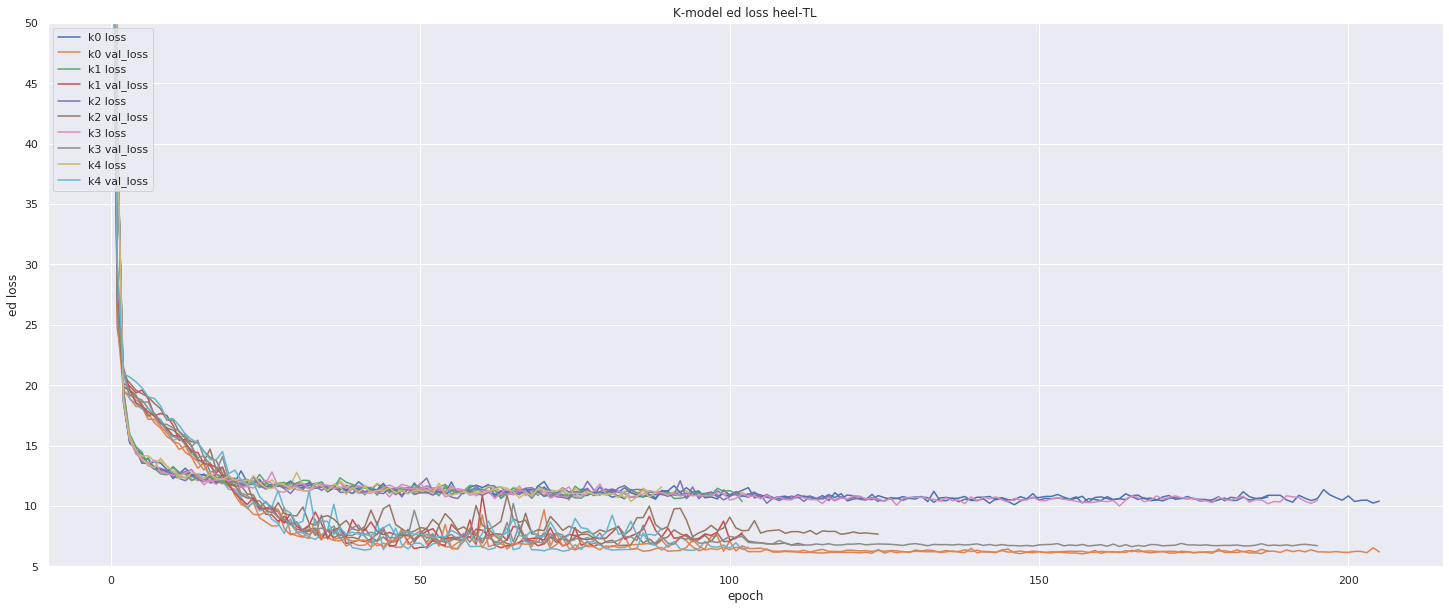

In [105]:
# Sum plot losses heel-tl

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_heel[k].history['loss'])
    plt.plot(history_heel[k].history['val_loss'])

    
plt.title('K-model ed loss heel-TL')
plt.ylabel('ed loss'), plt.ylim(5, 50)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_Ksum_TL.png', bbox_inches = 'tight')

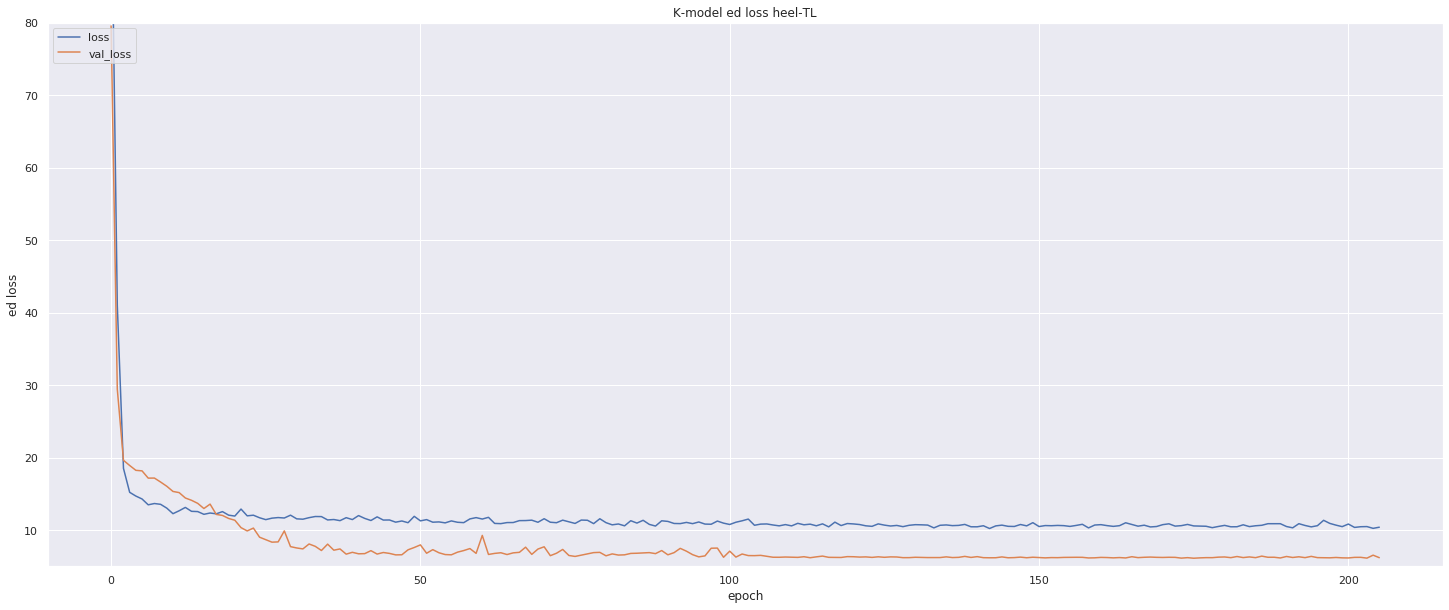

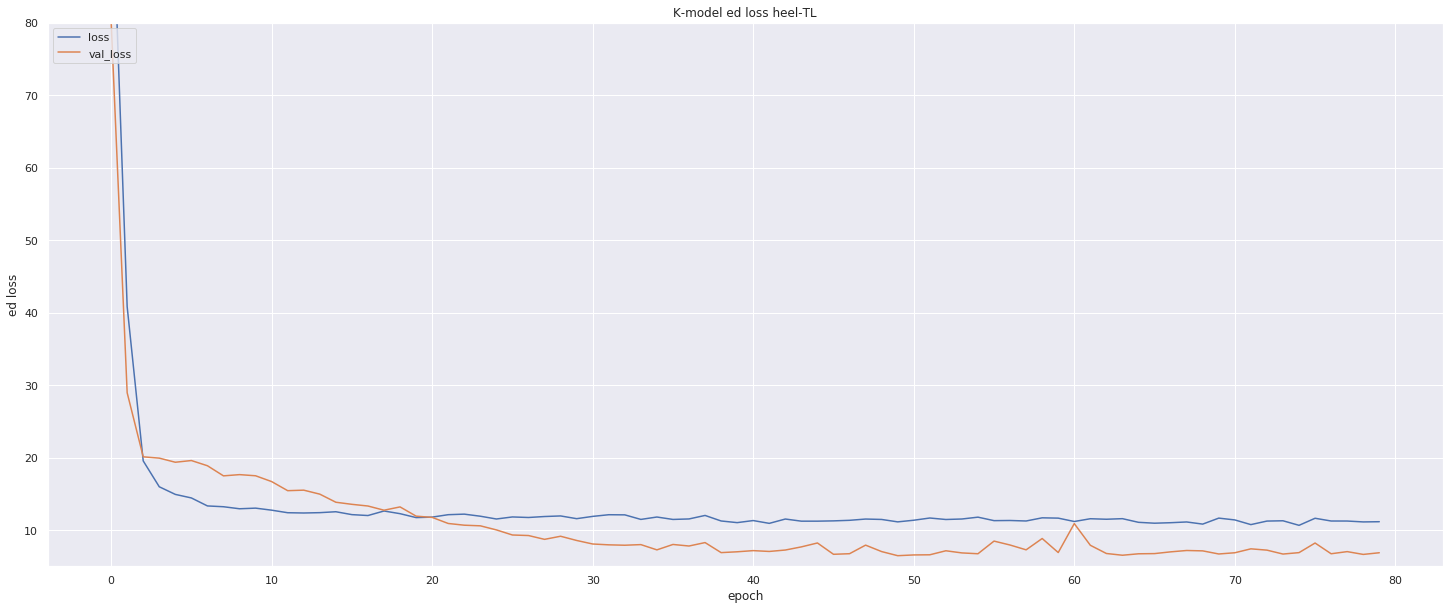

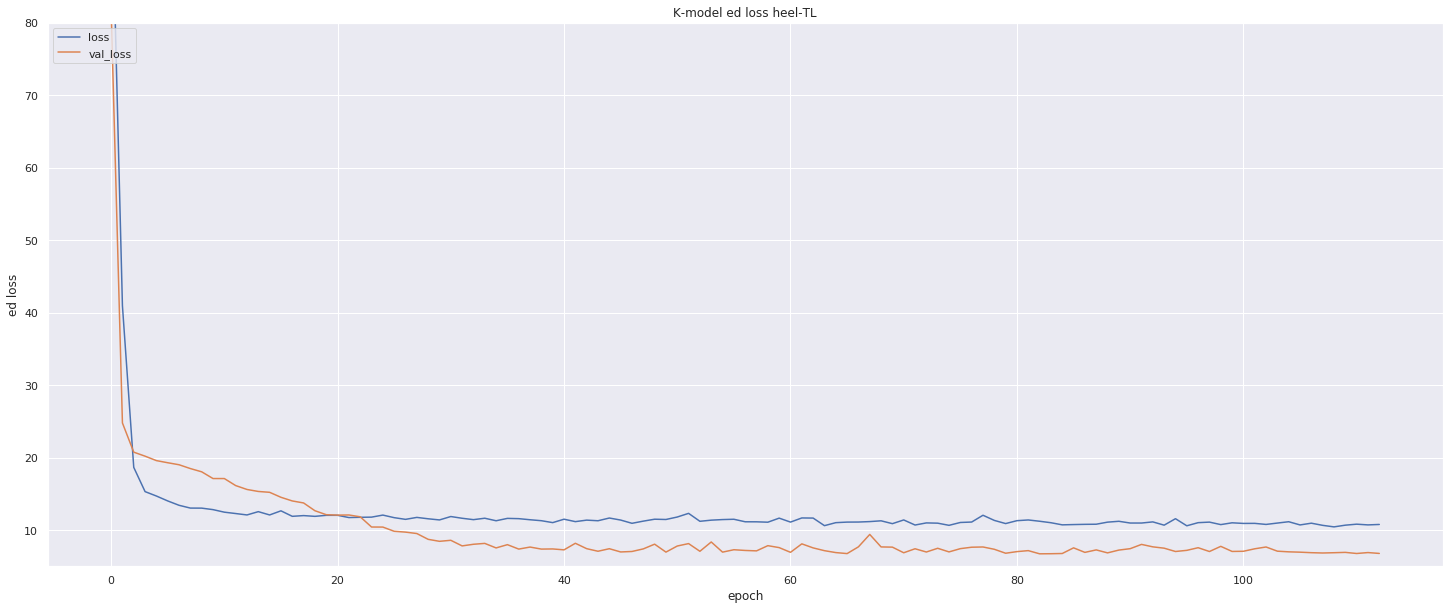

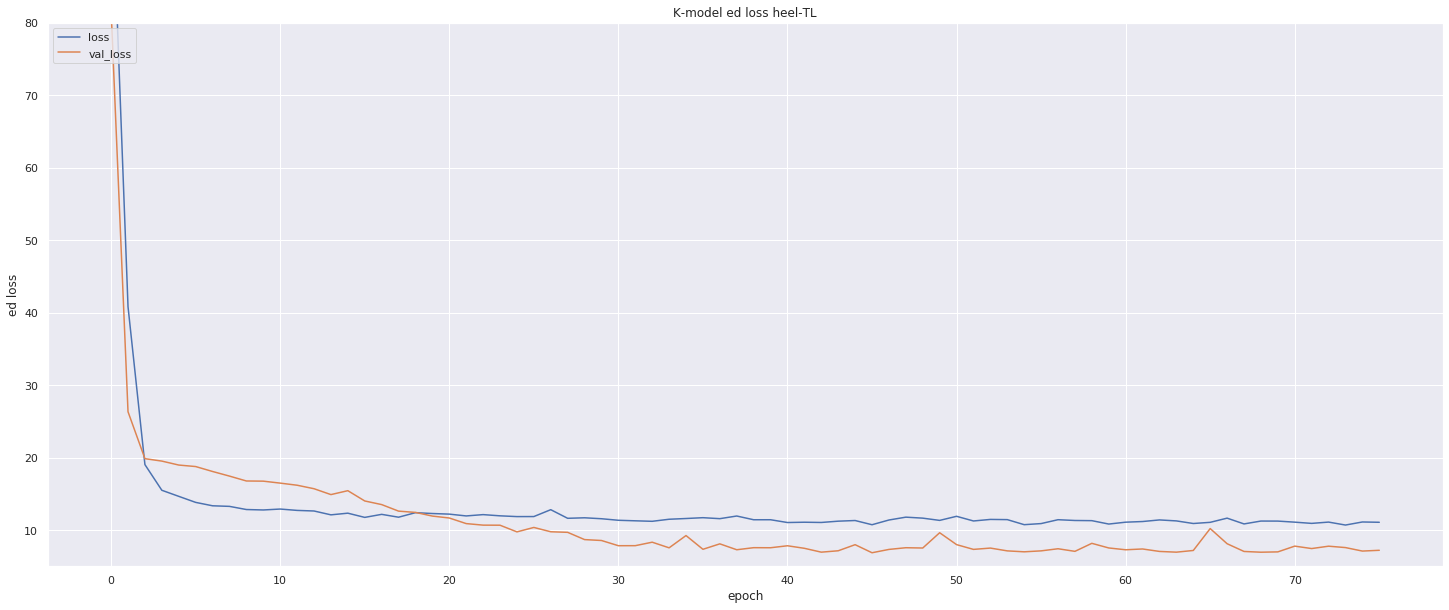

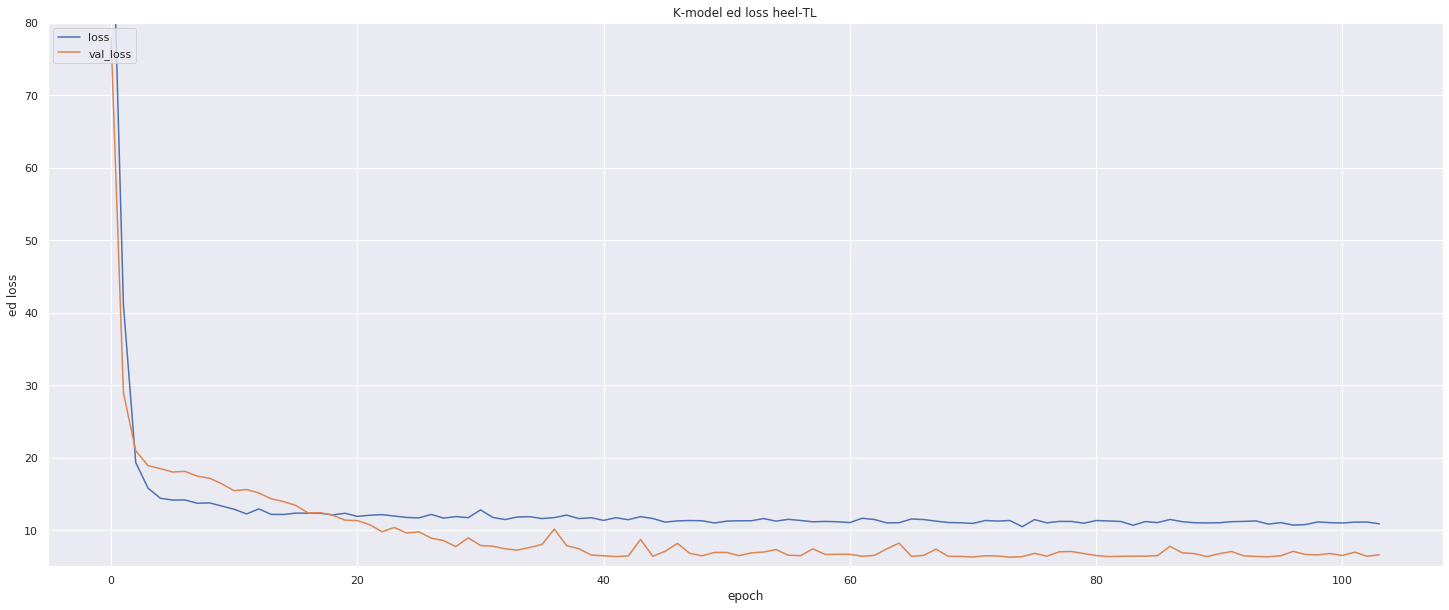

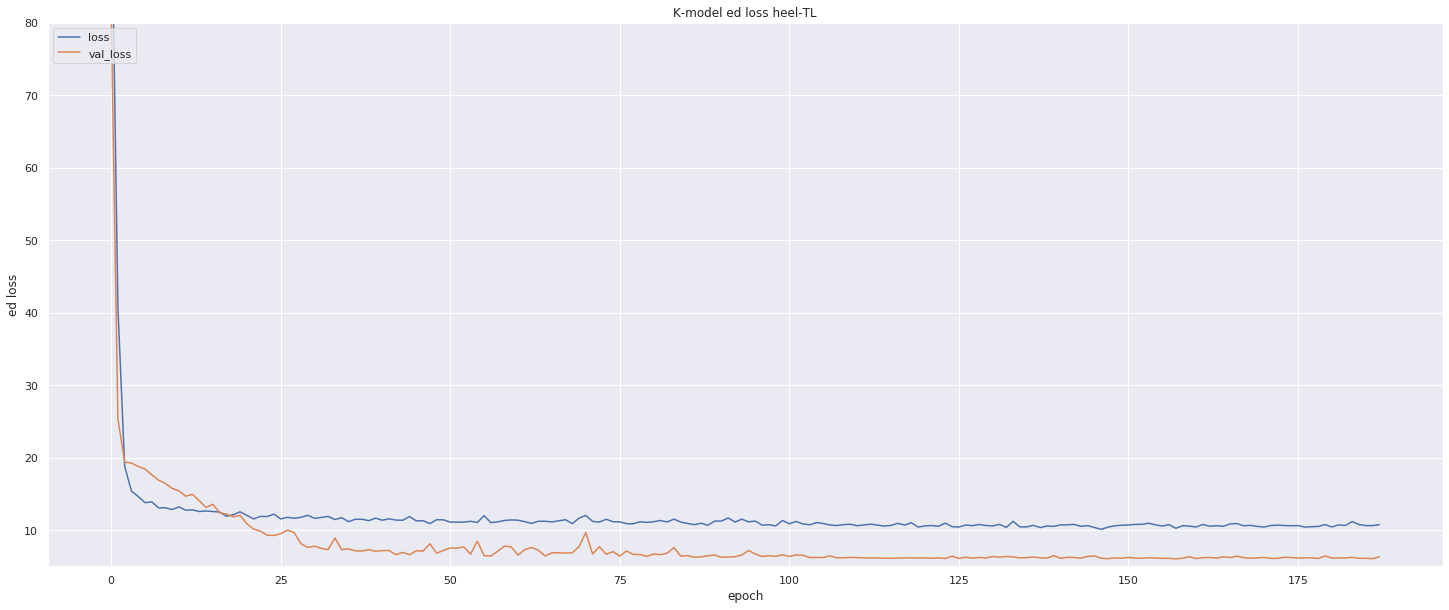

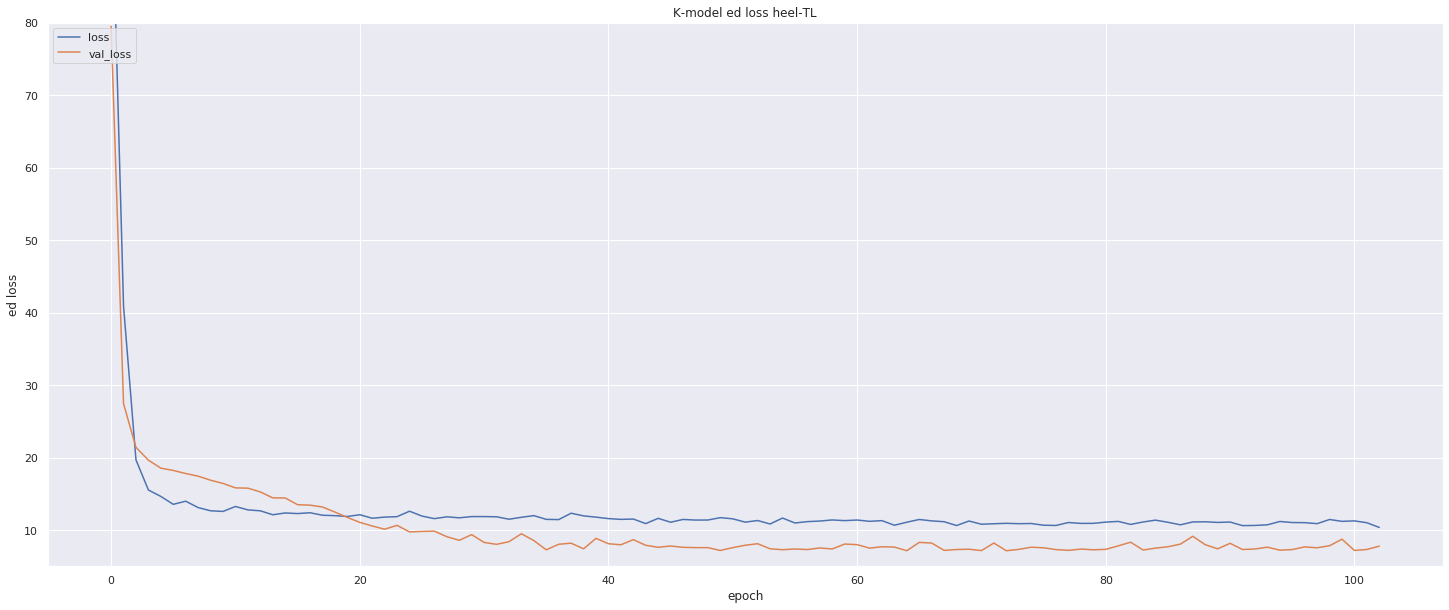

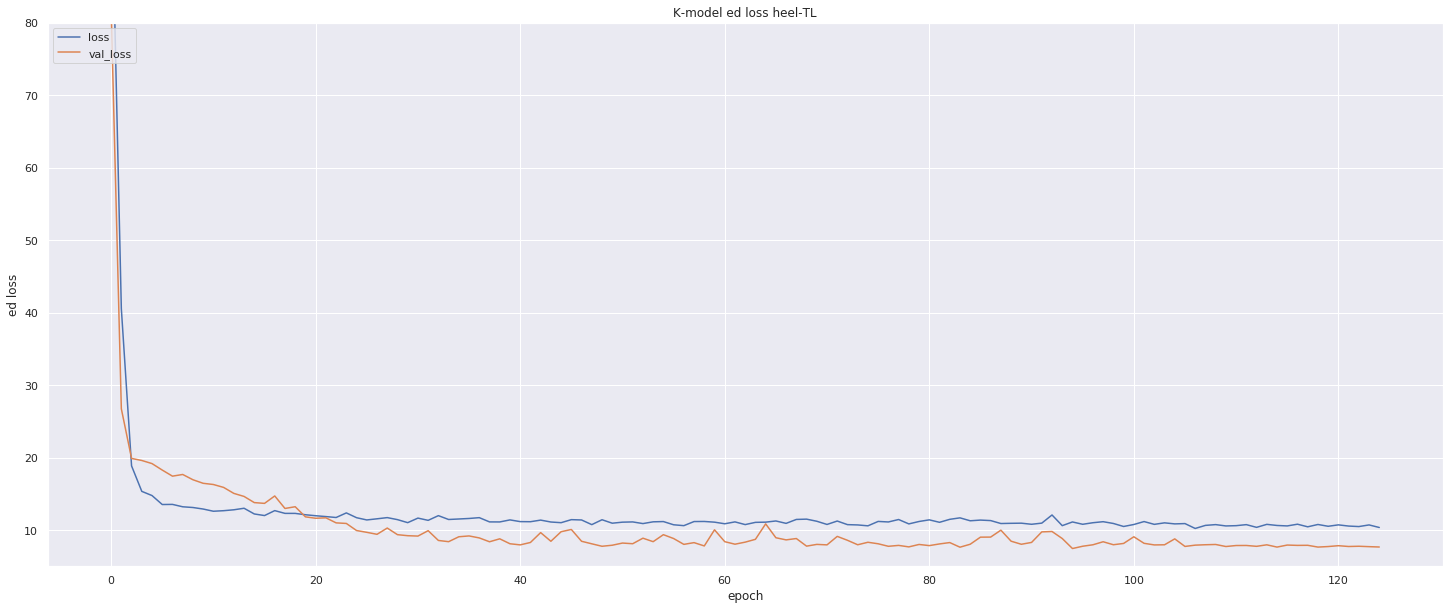

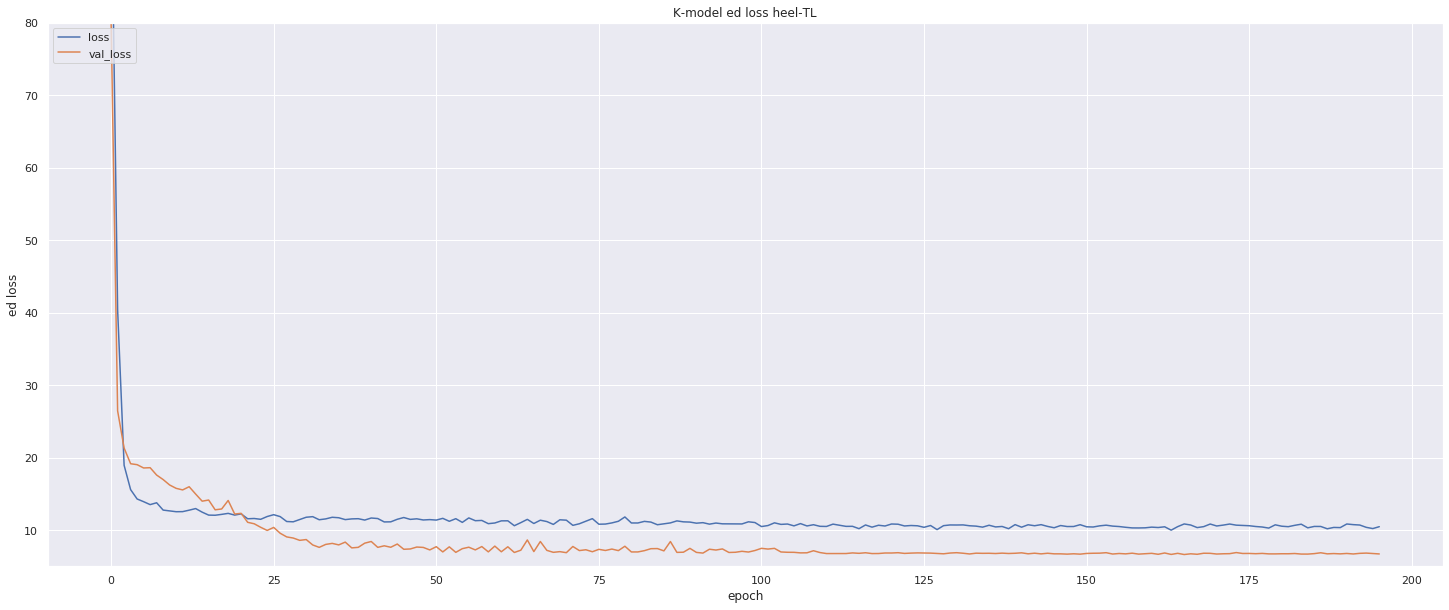

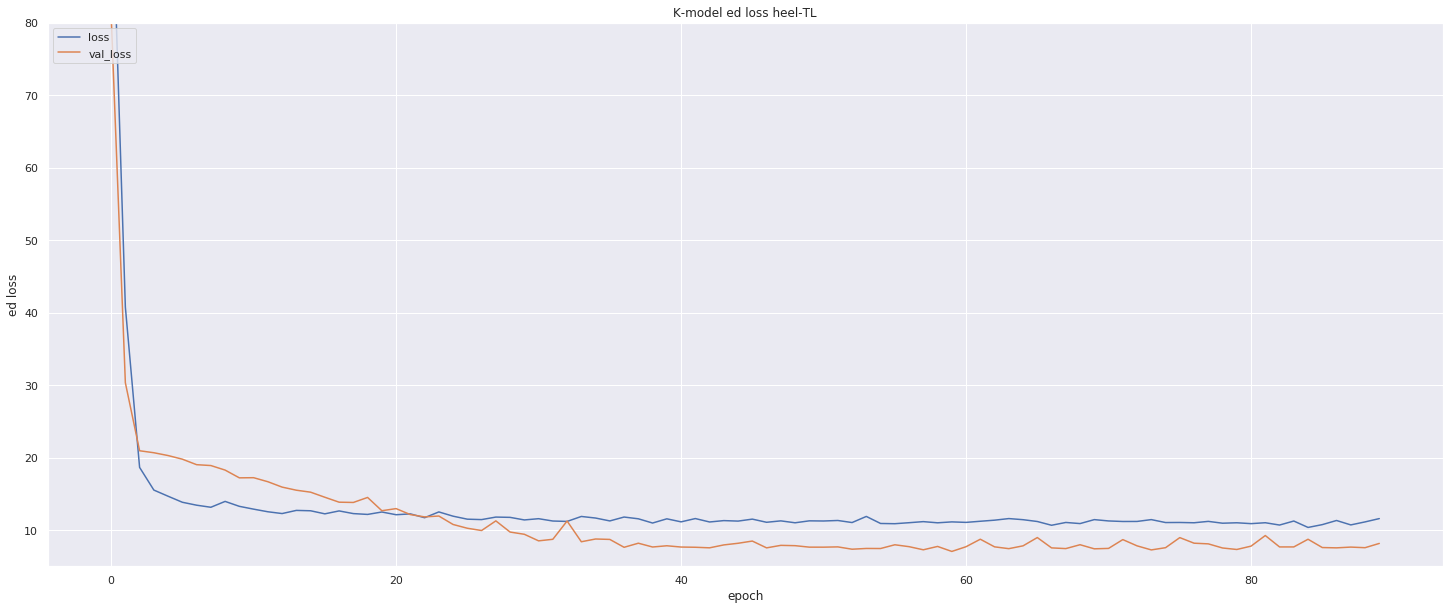

In [106]:
# Single plot loss heel-tl

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_heel[k].history['loss'])
    plt.plot(history_heel[k].history['val_loss'])
    plt.title('K-model ed loss heel-TL')
    plt.ylabel('ed loss'), plt.ylim(5, 80)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_heel[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_K{k}_TL_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9


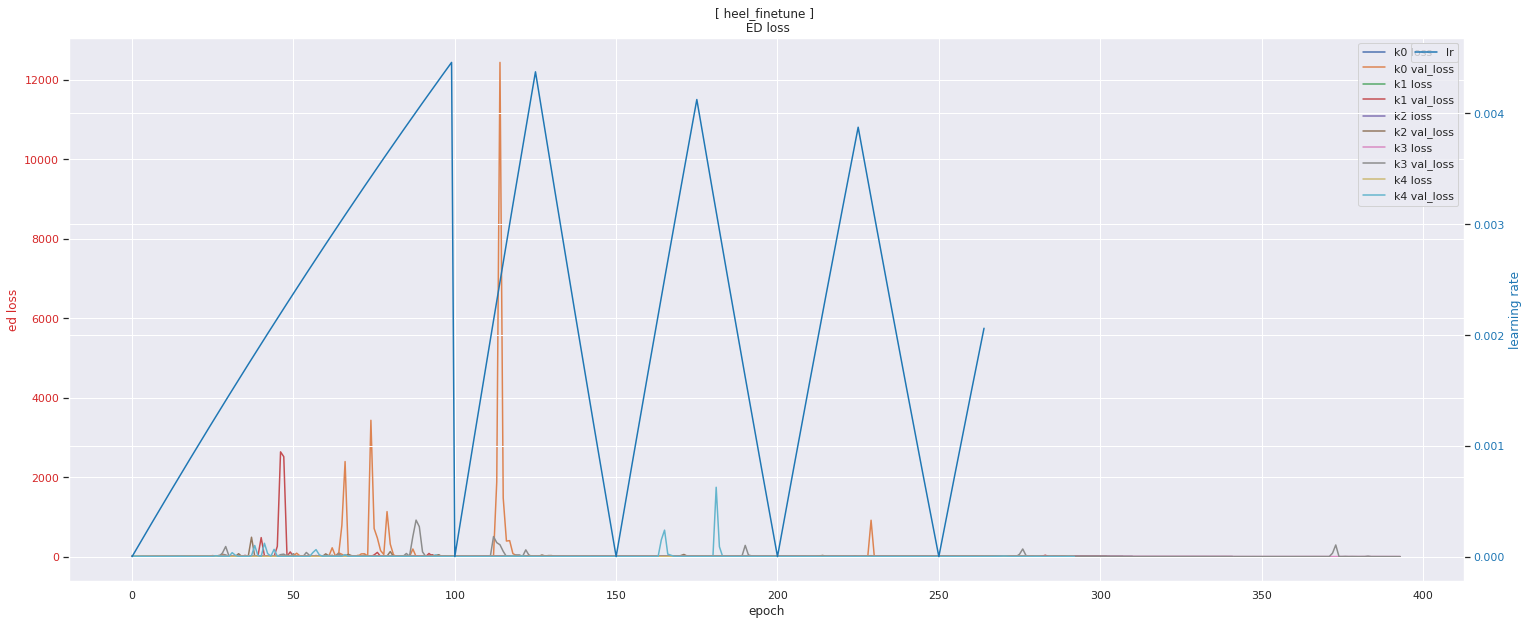

In [107]:
# check the loos the model trained.

def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    h_vl.append(h_v)
    
# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('[ heel_finetune ] \n ED loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

for k in range(KFlodNum):

    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])

ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.
ax1.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper right') 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_heel_finetune[0].history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()

# # save plot : comment plo.show in jupyter notebook.
# def get_valloss(his_v_l):   
#     return np.min(his_v_l), np.argmin(his_v_l)

# vl, ep = get_valloss(history_toe_finetune.history['val_loss'])


# t_vl = np.mean(t_vl, axis=0)
h_vl = np.mean(h_vl, axis=0)
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_ft_Ksum-clr_ed{round(h_vl,4)}.png', bbox_inches = 'tight')

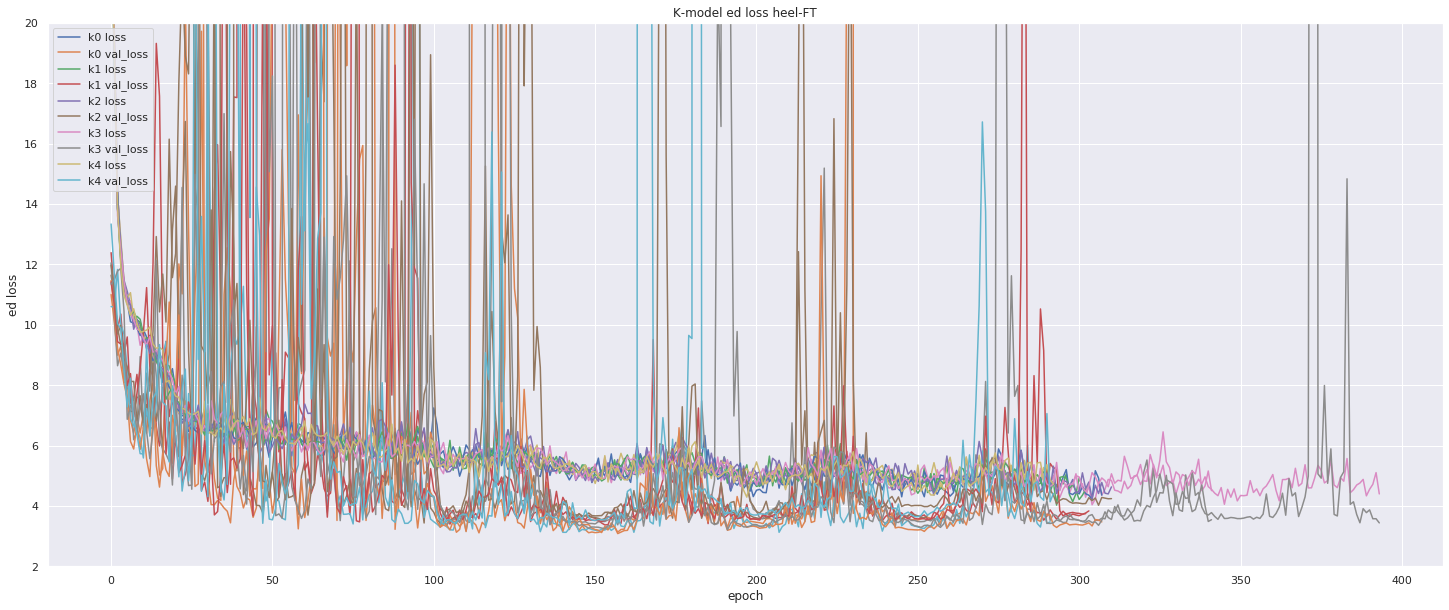

In [108]:
# Sum plot losses heel-ft

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])

    
plt.title('K-model ed loss heel-FT')
plt.ylabel('ed loss'), plt.ylim(2, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_Ksum_FT.png', bbox_inches = 'tight')

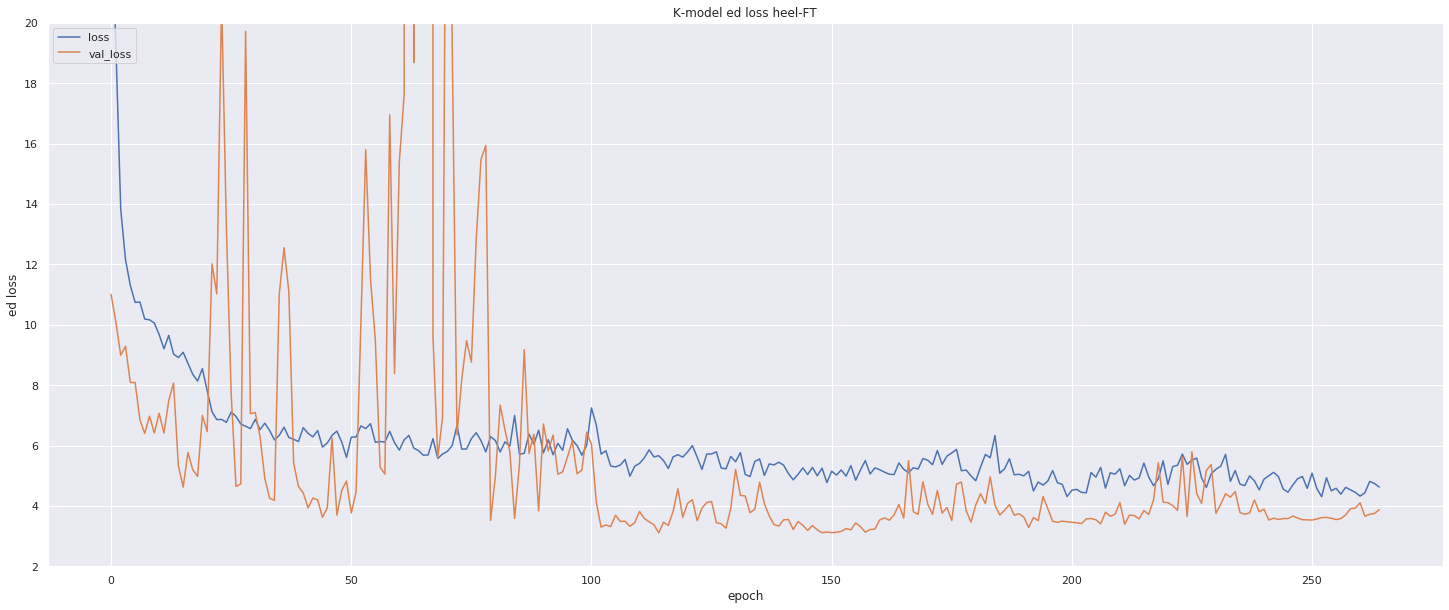

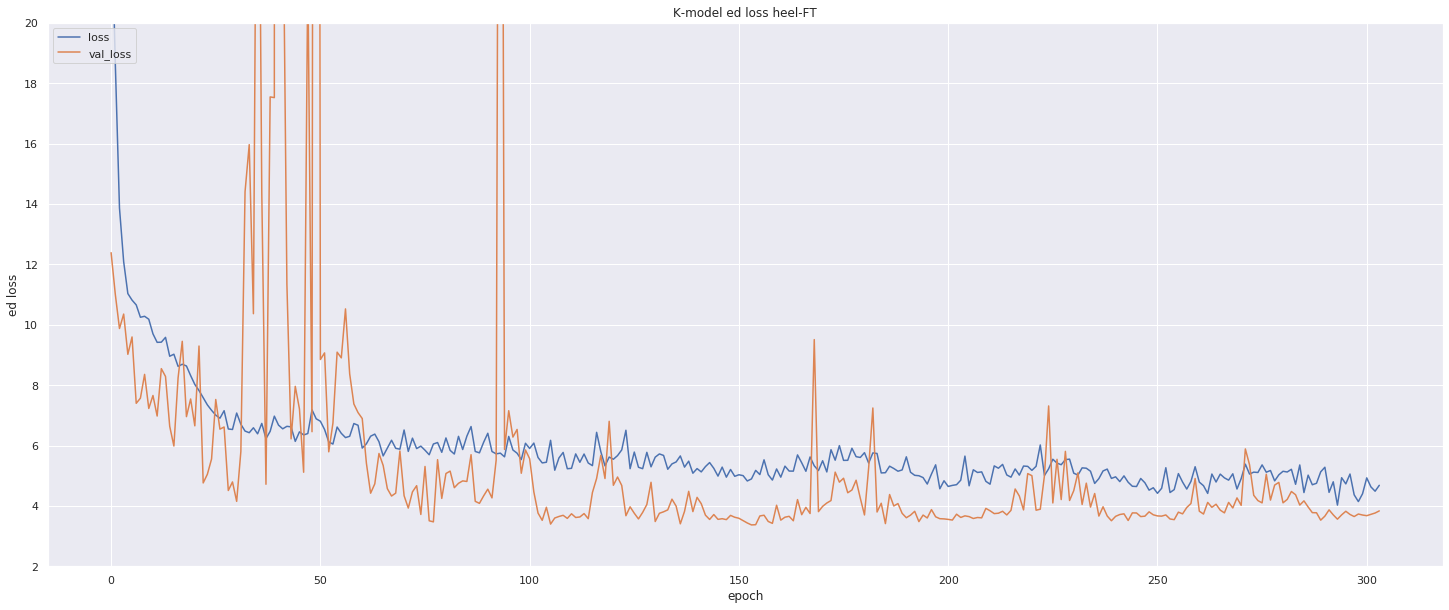

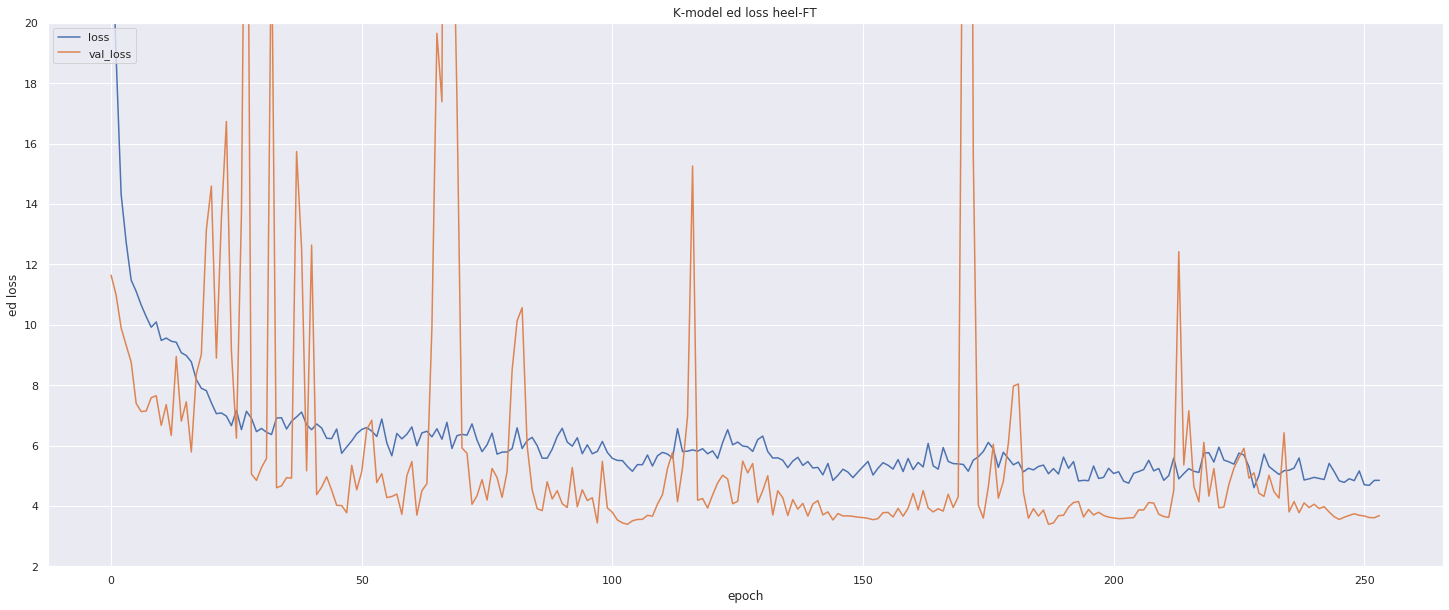

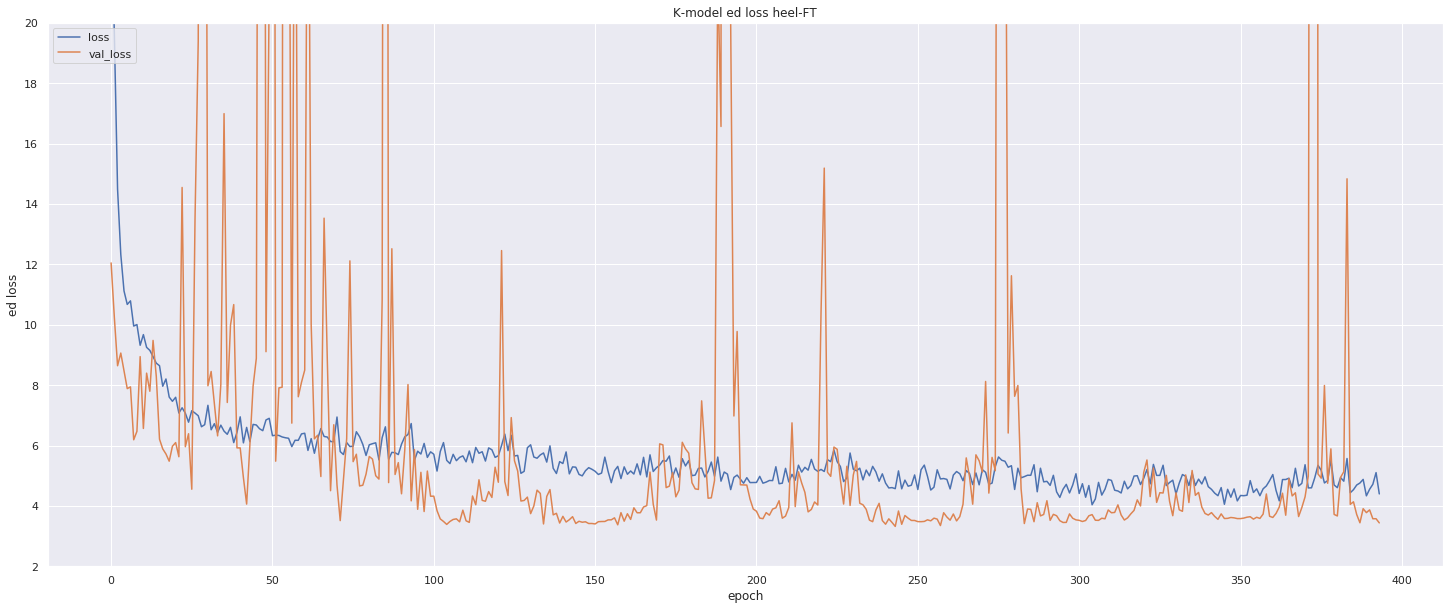

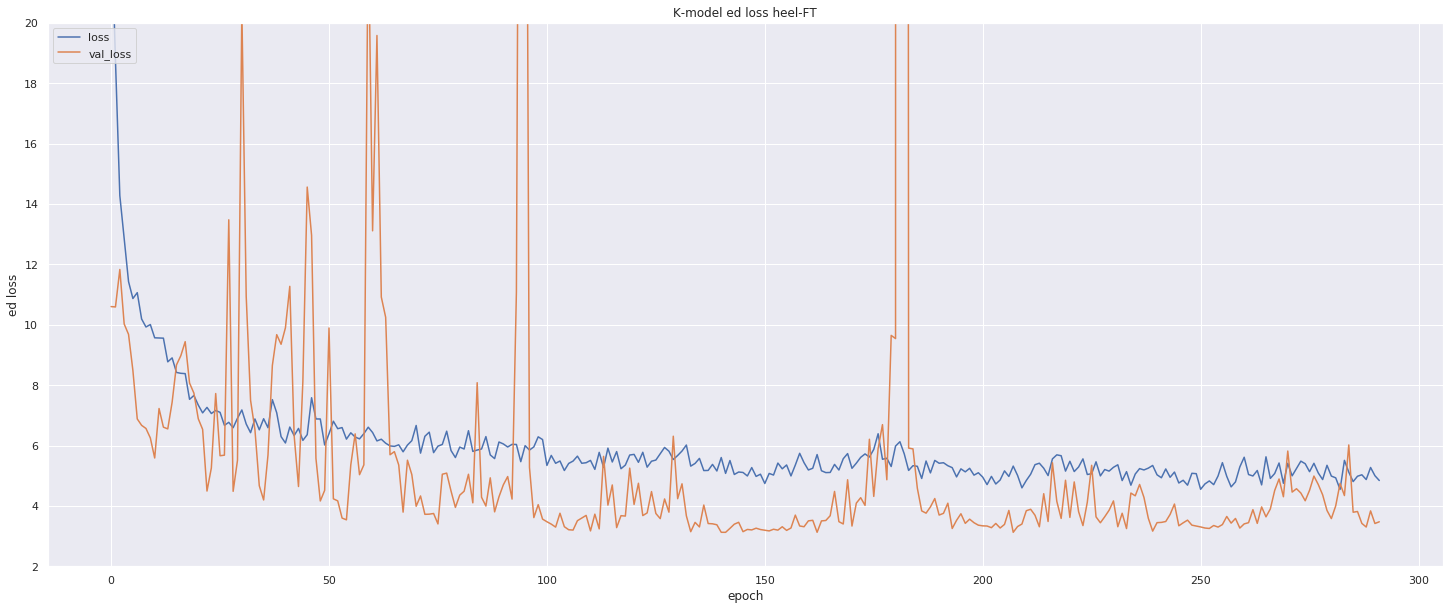

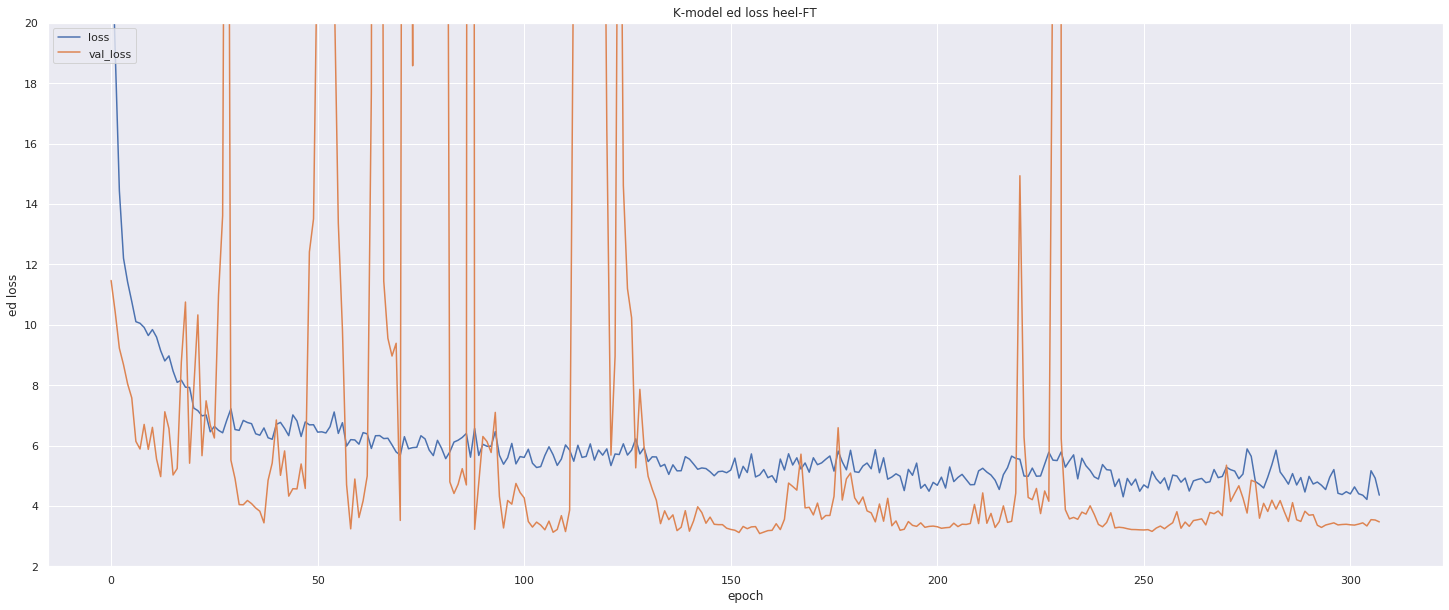

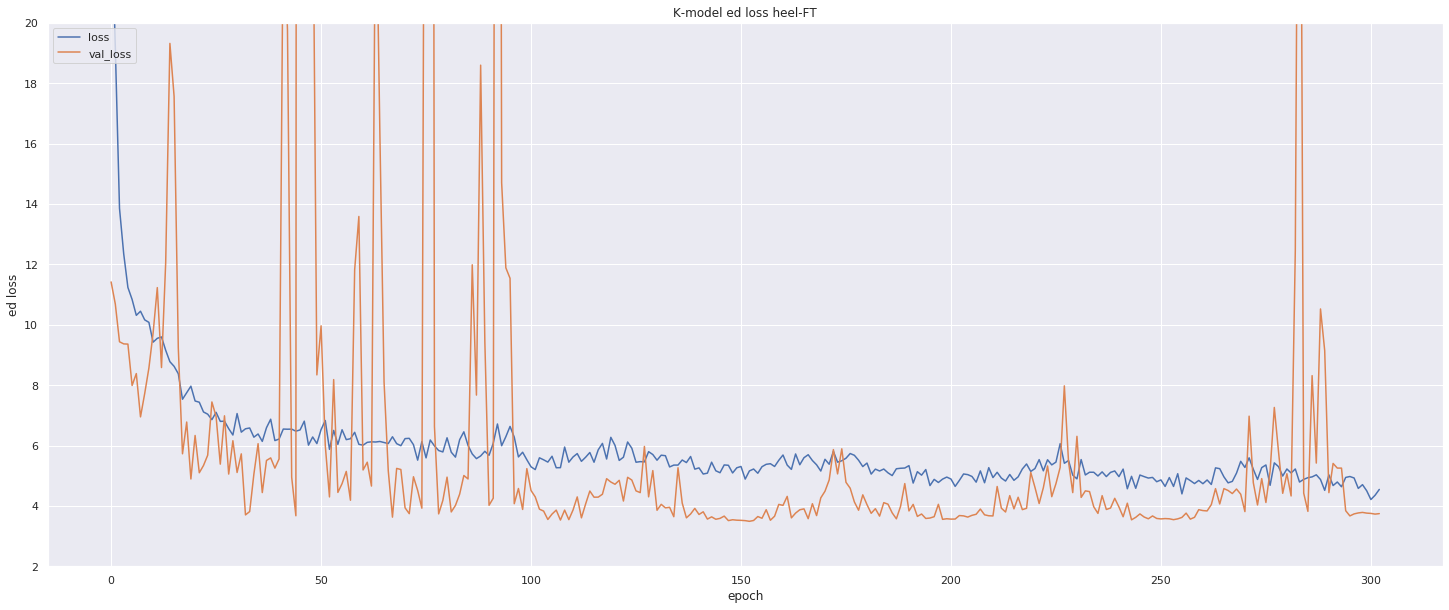

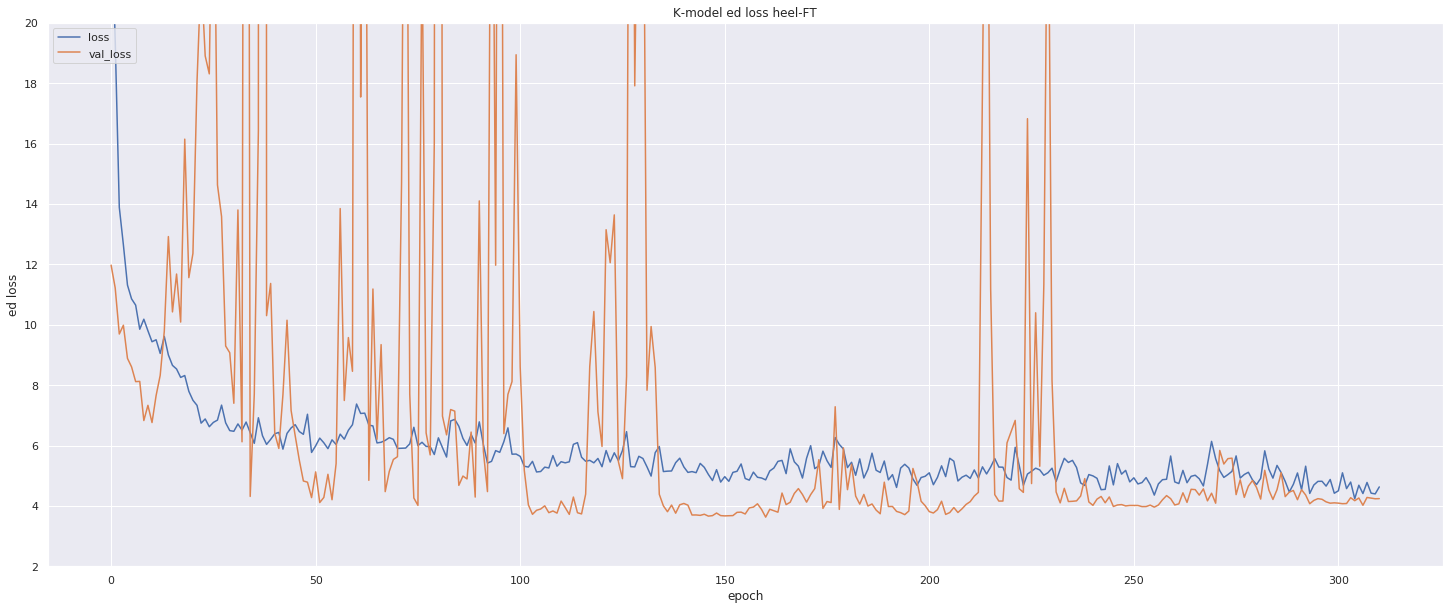

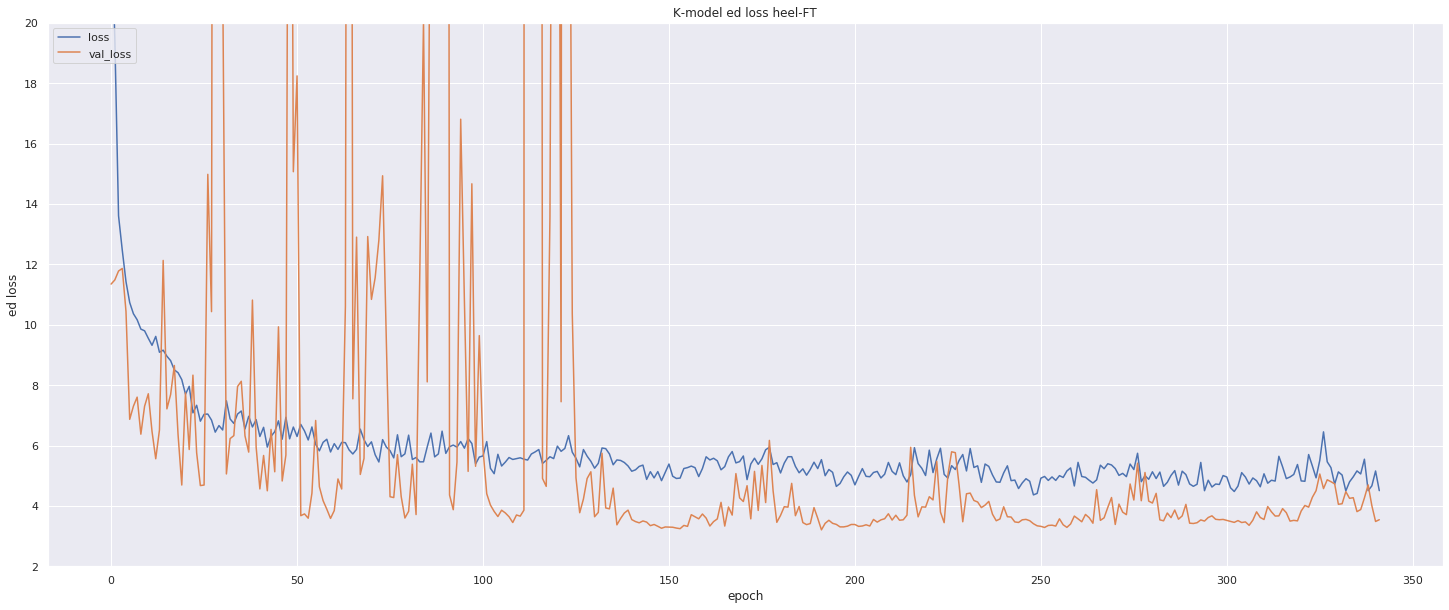

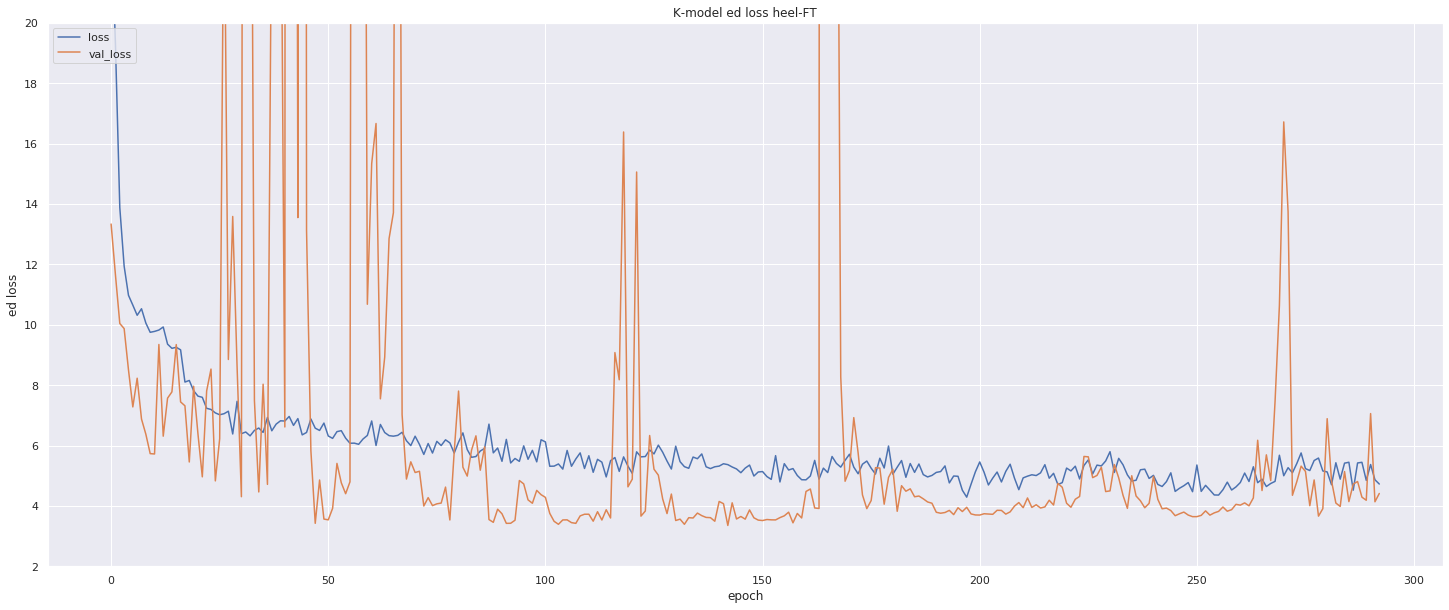

In [109]:
# Single plot loss heel-FT

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])
    plt.title('K-model ed loss heel-FT')
    plt.ylabel('ed loss'), plt.ylim(2, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_heel_finetune[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_K{k}_FT_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

### Ploting your model

In [110]:
# model_toe.summary()

In [111]:
# # show after modl.fit
# model_toe.metrics_names

In [112]:
# # check metrics the model have.
# history_toe.history.keys()

In [113]:
# tf.keras.utils.plot_model(model_toe, show_shapes=True)

In [114]:
# from tensorflow.keras.utils import plot_model
# plot_model(model_toe, to_file='model_toe_conv_layer_blocks.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='model_toe_conv_layer_blocks.png') 

## show pp pred

* we can switch toe/hell by comment it

### EFN Toe

In [115]:
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# # it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [116]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# # image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# pred = model_toe.predict_on_batch(image_batch) #predictions
# # pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [117]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:5]

In [118]:
# np.abs(neg)[:5]

In [119]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2D

In [120]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

### EFN Heel

In [121]:
# # it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [122]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# # image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# pred = model_heel.predict_on_batch(image_batch) #predictions
# # pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [123]:
# pred[:5]

In [124]:
# label_batch[:5]

In [125]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:10]

In [126]:
# np.abs(neg)[:10]

In [127]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2d

In [128]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

# Merg Toe/Heel model and predict the Test data at once

### Create TEST DS

In [129]:
ts = 'test_submission.csv'
df_ts = pd.read_csv(ts)
df_ts.head(5)

images  x1  y1  x2  y2
0  image_0001.png NaN NaN NaN NaN
1  image_0002.png NaN NaN NaN NaN
2  image_0003.png NaN NaN NaN NaN
3  image_0004.png NaN NaN NaN NaN
4  image_0005.png NaN NaN NaN NaN

In [130]:
df_ts['images']

0      image_0001.png
1      image_0002.png
2      image_0003.png
3      image_0004.png
4      image_0005.png
            ...      
995    image_0996.png
996    image_0997.png
997    image_0998.png
998    image_0999.png
999    image_1000.png
Name: images, Length: 1000, dtype: object

In [131]:
# from dataframe
list_ds_test = tf.data.Dataset.from_tensor_slices(df_ts['images'])


In [132]:
len(list_ds_test)#.shape() #take(1)

1000

In [133]:
# check The type specification of an element of this dataset.
list_ds_test.element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

In [134]:
for f in list_ds_test.take(5):
    print(f'take test sample: {f}')

take test sample: b'image_0001.png'
take test sample: b'image_0002.png'
take test sample: b'image_0003.png'
take test sample: b'image_0004.png'
take test sample: b'image_0005.png'


### TEST DS: Process TEST path to image tensor

In [135]:
## TEST-DS: re-used from train/val-ds

im_test = 'test_images/'

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe_test(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe_test(file_name):
    file_path = im_test + file_name
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe_test(img)
    return img, file_name

#
# map list to ds, Heel part.
#

def decode_crop_png_heel_test(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel_test(file_name):
    file_path = im_test + file_name
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel_test(img)
    return img, file_name


#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [136]:
# TEST Toe ds
test_ds_map_toe = list_ds_test.map(process_path_toe_test, num_parallel_calls=AUTOTUNE)

# TEST Heel ds
test_ds_map_heel = list_ds_test.map(process_path_heel_test, num_parallel_calls=AUTOTUNE)

In [137]:
for img, file_name in test_ds_map_toe.take(5):
    print(f'take sample: {img.shape} {file_name}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

take sample: (120, 120, 3) b'image_0001.png'
take sample: (120, 120, 3) b'image_0002.png'
take sample: (120, 120, 3) b'image_0003.png'
take sample: (120, 120, 3) b'image_0004.png'
take sample: (120, 120, 3) b'image_0005.png'


### prepare TEST_ds_pre

In [138]:
def configure_for_performance_cache_test(ds, cache=True):

    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
#     if augment:
# #         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
# #         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(1000)# 1k for foot test images #MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    return ds


In [139]:
"""
Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
"""
# TEST Toe ds_pre
test_ds_pre_toe = configure_for_performance_cache_test(test_ds_map_toe)

# TEST Heel ds_pre
test_ds_pre_heel = configure_for_performance_cache_test(test_ds_map_heel)

Check cache in memory:Y True
Check cache in memory:Y True


# Load Best-K-models

In [140]:
# if K-models are in last time frame
# best_model_name = get_best_model_name(th, K=str(k))

predictions_toe = []
predictions_heel = []

for k in range(KFlodNum):
    print(f'K:{k}')
    best_model_toe_name = get_best_model_name('toe', K=str(k))
    best_model_heel_name = get_best_model_name('heel', K=str(k))

# # if models are in last time frame
# best_model_toe_name = get_best_model_name('toe')
# best_model_heel_name = get_best_model_name('heel')

# # if toe/heel are in different time frame
# best_model_toe_name = '20210118-212454/toe_EfficientNetB0_bs64_w120_best_val_loss.h5'#6.3318 @e393
# best_model_heel_name = '20210122-084854/heel_EfficientNetB0_bs64_w120_best_val_loss.h5'#3.27979@152




    print(best_model_toe_name)
    print(best_model_heel_name)
    # log_dir_name + '/' + 'leaf-2020-12-01-EfficientNetB7_top-layer50_lr_lrfn_val-acc.8352_wh512_e37.h5'

    best_model_toe = tf.keras.models.load_model(best_model_toe_name,compile=False)
    best_model_heel = tf.keras.models.load_model(best_model_heel_name,compile=False)
    
    best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
                loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
                #metrics=['mae', 'accuracy'])
    best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
                loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
                #metrics=['mae', 'accuracy'])
        
        
    pred_toe = best_model_toe.predict(test_ds_pre_toe)
    pred_toe[:,1] = pred_toe[:,1] + y_offset_toe
    predictions_toe.append(pred_toe)
    
    pred_heel = best_model_heel.predict(test_ds_pre_heel)
    pred_heel[:,1] = pred_heel[:,1] + y_offset_heel
    predictions_heel.append(pred_heel)
    
    

K:0
./20210302-234745/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-234745/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
K:1
./20210302-234745/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-234745/heel_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
K:2
./20210302-234745/toe_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-234745/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
K:3
./20210302-234745/toe_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-234745/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
K:4
./20210302-234745/toe_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-234745/heel_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
K:5
./20210302-234745/toe_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-234745/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
K:6
./20210302-234745/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-234745/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5


K:7
./20210302-234745/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-234745/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
K:8
./20210302-234745/toe_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-234745/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
K:9
./20210302-234745/toe_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-234745/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5


In [141]:
len(predictions_toe[0])

1000

In [142]:
# make sure we got the k-pred as k models.
for i, _ in enumerate(predictions_toe):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [143]:
np.shape(predictions_toe)

(10, 1000, 2)

In [144]:
predictions_toe[0]

array([[ 57.015503, 134.14214 ],
       [ 54.995575, 141.68626 ],
       [ 53.003983, 146.83682 ],
       ...,
       [ 66.079384, 134.38928 ],
       [ 61.55612 , 120.23596 ],
       [ 59.211426, 119.43943 ]], dtype=float32)

In [145]:
predictions_toe[1]

array([[ 56.19802 , 134.01465 ],
       [ 51.652435, 142.15009 ],
       [ 49.335655, 144.09834 ],
       ...,
       [ 61.331886, 132.33992 ],
       [ 65.81157 , 120.13275 ],
       [ 61.749035, 119.848114]], dtype=float32)

In [146]:
predictions_heel[0]

array([[ 80.84874 , 380.15292 ],
       [ 21.608486, 374.36212 ],
       [ 78.32963 , 384.3692  ],
       ...,
       [ 29.5844  , 381.12094 ],
       [ 74.79403 , 381.9076  ],
       [ 33.8217  , 381.2998  ]], dtype=float32)

In [147]:
predictions_heel[1]

array([[ 79.65335 , 379.30865 ],
       [ 25.217125, 376.06506 ],
       [ 78.15037 , 383.03964 ],
       ...,
       [ 29.1116  , 381.49762 ],
       [ 75.989136, 381.40875 ],
       [ 34.603107, 381.41455 ]], dtype=float32)

In [148]:
# mean the k-predictions
k_predictions_toe = np.mean(predictions_toe, axis=0)
k_predictions_toe

array([[ 56.63368 , 134.81583 ],
       [ 55.836353, 140.85623 ],
       [ 52.586266, 146.34767 ],
       ...,
       [ 63.783833, 134.7362  ],
       [ 63.864758, 121.45516 ],
       [ 60.291023, 120.72408 ]], dtype=float32)

In [149]:
np.shape(k_predictions_toe)

(1000, 2)

In [150]:
# mean the k-predictions
k_predictions_heel = np.mean(predictions_heel, axis=0)
k_predictions_heel

array([[ 80.7238  , 379.4699  ],
       [ 22.971573, 374.86572 ],
       [ 78.5416  , 383.44412 ],
       ...,
       [ 28.307932, 381.29312 ],
       [ 74.77522 , 381.86932 ],
       [ 34.049446, 381.64148 ]], dtype=float32)

### Merge toe/hell pred

In [151]:
predictions_th = np.append(k_predictions_toe, k_predictions_heel, axis=1)#左右接
predictions_th.shape

(1000, 4)

In [152]:
images_name = np.expand_dims(df_ts['images'], axis=1)
images_name.shape

(1000, 1)

In [153]:
predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
predictions_merge.shape

(1000, 5)

In [154]:
df_submission = pd.DataFrame(predictions_merge)
df_submission.columns = ['images','x1','y1','x2','y2']

In [155]:
submi_name = CSVNAME + '.' + log_dir_name +'.csv'

df_submission.to_csv(submi_name, index=False)
print('Save {} as submission CSV.'.format(submi_name))

Save K1345K10L195.20210302-234745.csv as submission CSV.


In [156]:
df_submission.head()

images       x1       y1       x2       y2
0  image_0001.png  56.6337  134.816  80.7238   379.47
1  image_0002.png  55.8364  140.856  22.9716  374.866
2  image_0003.png  52.5863  146.348  78.5416  383.444
3  image_0004.png  57.0634  138.661   28.921  373.447
4  image_0005.png  60.6577    149.9  66.7089  370.705

In [157]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
    h_vl.append(h_v)

t_vl = np.mean(t_vl, axis=0)
h_vl = np.mean(h_vl, axis=0)
print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9
5.665 + 3.30747 = 8.97247


In [158]:
# K134520210224-114845.csv
# 5.63922 + 3.34466 = 8.98389 LB:8.4890610

In [159]:
t_vl

5.664999914169312

In [160]:
h_vl

3.307469630241394

In [161]:
t_timer.toc() #Time elapsed since t.tic()

Elapsed time is 41417.386330 seconds.


### compile the model separately afterwards. to load model with custom loss function

* https://github.com/tensorflow/tensorflow/issues/32348

In [162]:
# best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
# best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])

# best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
# best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])

    

In [163]:
# %%time
# # inference all test_ds once
# predictions_toe = best_model_toe.predict(test_ds_pre_toe)
# predictions_toe.shape

### Offset Toe

In [164]:
# predictions_toe[:,1] = predictions_toe[:,1] + y_offset_toe

# # for [0,1]
# # predictions_toe[:,0] = predictions_toe[:,0]*120
# # predictions_toe[:,1] = predictions_toe[:,1]*120 + y_offset_toe

# # # for [-1,1]
# # # for re-scale back xy 
# # # return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# # # return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] 
# # predictions_toe[:,0] = (predictions_toe[:,0]*60)+60
# # predictions_toe[:,1] = (predictions_toe[:,1]*60)+60 + y_offset_toe

# predictions_toe

In [165]:
# %%time
# # inference all test_ds once
# predictions_heel = best_model_heel.predict(test_ds_pre_heel)
# predictions_heel.shape

### Offset Heel

In [166]:
# predictions_heel[:,1] = predictions_heel[:,1] + y_offset_heel

# # for [0,1]
# # predictions_heel[:,0] = predictions_heel[:,0]*120
# # predictions_heel[:,1] = predictions_heel[:,1]*120 + y_offset_heel

# # # for [-1,1]
# # predictions_heel[:,0] = (predictions_heel[:,0]*60)+60
# # predictions_heel[:,1] = (predictions_heel[:,1]*60)+60 + y_offset_heel

# predictions_heel

### Merge toe/hell pred

In [167]:
# predictions_th = np.append(predictions_toe, predictions_heel, axis=1)#左右接
# predictions_th.shape

In [168]:
# images_name = np.expand_dims(df_ts['images'], axis=1)
# images_name.shape

In [169]:
# predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
# predictions_merge.shape

In [170]:
# df_submission = pd.DataFrame(predictions_merge)
# df_submission.columns = ['images','x1','y1','x2','y2']

In [171]:
# submi_name = '0000_ft_' + log_dir_name +'.csv'
# # submi_name = 'Bth_clr3_2690_XYnorm[0-1]_' + log_dir_name +'.csv'
# df_submission.to_csv(submi_name, index=False)
# print('Save {} as submission CSV.'.format(submi_name))

In [172]:
#Bth_clr3_2690_ed_findtune_20210202-141718.csv

#toe.9.9/heel.4.4 109 trainable LB:9.3411759 比heel保持top-20略高0.04 (9.3084957)

In [173]:
# df_submission.head()

In [174]:
# #ED sum
# def get_valloss(his_v_l):  
#     return np.min(his_v_l), np.argmin(his_v_l)

# t_vl, _ = get_valloss(history_toe_finetune.history['val_loss'])
# h_vl, _ = get_valloss(history_heel_finetune.history['val_loss'])

# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

In [175]:
#

## save model

In [176]:

# best_model_name = './cop_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_e' + str(ep_num) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_.h5'
# # model.save(best_model_name)
# print("Save model: ", best_model_name)

## Reference

multi output model:
https://navoshta.com/end-to-end-deep-learning/

